In [1]:
import gc
import glob
import os
import random
import re
import tarfile

import flash
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import sklearn
import torch
import torchvision
from PIL import Image
from sklearn.datasets import fetch_openml
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/flash/__init__.py:21: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.10/dist-packages/flash/__init__.py:21: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  if not hasattr(numpy, tp_name):


In [2]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


SEED = 2913
fix_seed(SEED)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# GANによる画像生成(DCGAN)

本ノートブックでは、DCGANの実装を行なっていく。Self-Attention GANは別のNotebookにて実装する。

なお、書籍ではMNISTの"7"と"8"の手書きデータのみを学習させているが、せっかくなので全ての文字を学習させてみる。

DCGANの目標は、ある数を入力とした時、手書きっぽい数字の画像を作成すること。この入力とする数を様々に変更することにより、多種多様な出力画像、すなわち手書きの数字の画像を作成できるようになる。

これを実現するため、GANはGenerator(画像生成部)とDiscriminator(画像判別部)を構成する。

細かな実装は以降で説明する。

## データの確認及びDataset, DataLoaderの作成

MNISTは手書きの1桁の数字を扱ったデータ。

ありがたいことにtorchvisionにMNISTがあるので、それを使うことにする。ただし、torchvisionのデータセットは学習用データと検証用データに分かれている。学習フェーズのコードを見れば分かるように、本学習では検証用データは不要なので、train_datasetとval_datasetの両方を学習データとする。PyTorchのデータセットクラスはうまくできていて、2つのデータセットの結合は単純にプラスで演算をしてあげるだけで可能。

MNISTの画像サイズは28x28だが、書籍に合わせて64x64に拡大する。~~これをtransformでやってもいいのかもしれないが、極めて遅くなるので、ミニバッチでの入力前に`torch.nn.functional.interpolate`で拡大することにする。~~->そんなに変わらなかった。

In [4]:
class MnistTransform:
    def __init__(
        self,
    ):
        self.transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize((64, 64)),
                torchvision.transforms.ToTensor(),
            ]
        )

    def __call__(self, x):
        return self.transform(x)

In [5]:
transform = MnistTransform()
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, target_transform=None, download=True
)
val_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    target_transform=None,
    download=True,
)
dataset = train_dataset + val_dataset

In [6]:
display(train_dataset)
print("train_dataset shape:", train_dataset.data.shape)
display(val_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: <__main__.MnistTransform object at 0x7fcbbb23d690>

train_dataset shape: torch.Size([60000, 28, 28])


Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: <__main__.MnistTransform object at 0x7fcbbb23d690>

Text(0.5, 0.98, 'MNIST Dataset')

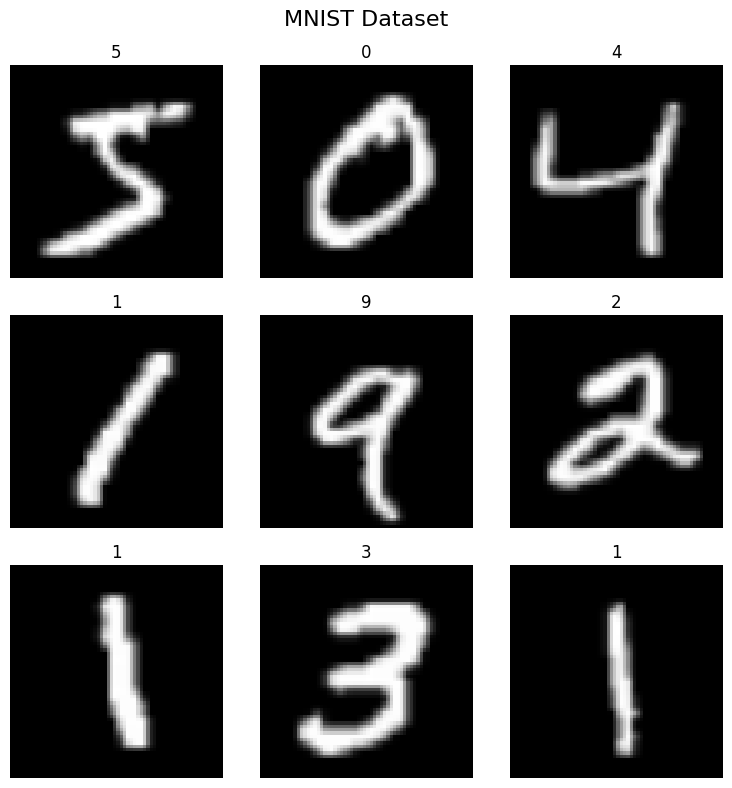

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_dataset[i][0].squeeze(), cmap="gray")
    ax.set_title(train_dataset[i][1])
    ax.set_axis_off()
fig.set_tight_layout(True)
fig.suptitle("MNIST Dataset", fontsize=16)

データの平均と標準偏差を確認。

データは概ね真ん中に密集していることがわかる。そのため、特別な前処理は不要。

Text(0.5, 0.98, 'MNIST Dataset')

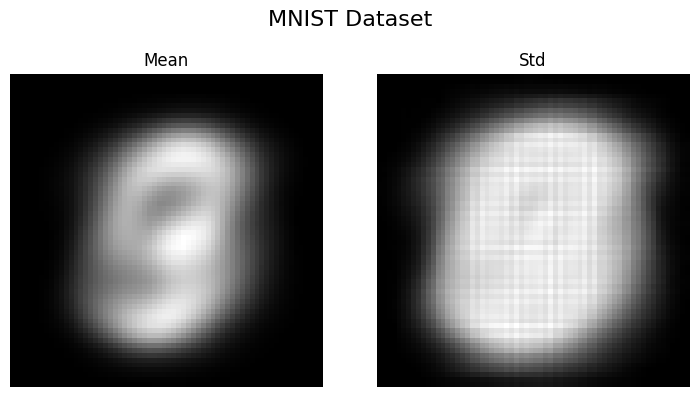

In [8]:
# add all in train_dataset and show heatmap
train_data = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
train_mean = torch.mean(train_data, dim=0)
train_std = torch.std(train_data, dim=0)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(train_mean.squeeze(), cmap="gray")
axes[0].set_title("Mean")
axes[0].set_axis_off()
axes[1].imshow(train_std.squeeze(), cmap="gray")
axes[1].set_title("Std")
axes[1].set_axis_off()
fig.set_tight_layout(True)
fig.suptitle("MNIST Dataset", fontsize=16)

In [9]:
batch_size = 2048
train_data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=True,
    persistent_workers=True,
)

## Genaratorの実装

Generatorは、ある数字から64x64の手書きの数字画像を作成する。つまり、(in_channels, 1, 1)のサイズのテンソルから(1, 64, 64)のサイズのテンソルを作成することになる。

書籍では、すべての実装をGeneratorクラスに書いているが、step-by-stepで動作を確認するため、まずはDeconv2dクラスを作成して実装を確認していく。以下、バッチサイズ(次元0)は省略。

```mermaid:Generator
flowchart LR;
    input( )
    output( )
    d1(Deconv2d)
    d2(Deconv2d)
    d3(Deconv2d)
    d4(Deconv2d)
    d5(Deconv2d)
    input--(in_channels,1,1)-->d1
    subgraph Generator
        d1--(512,4,4)-->d2--(256,8,8)-->d3--(128,16,16)-->d4--(64,32,32)-->d5
    end
    d5--(1,64,64)-->output
```

なお、`ConvTranspose2d`の入出力の次元は[公式ドキュメント](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)から頑張って計算する。

In [10]:
class Deconv2d(torch.nn.Sequential):
    def __init__(self, in_channels, out_channels, with_batch_norm=True, **kwargs):
        super().__init__()
        self.add_module(
            "ConvTranspose2d",
            torch.nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
        )
        if with_batch_norm:
            self.add_module("BatchNorm2d", torch.nn.BatchNorm2d(out_channels))
        self.add_module("ReLU", torch.nn.ReLU(inplace=True))

In [11]:
_batch_size = 4
_in_channels = 20
_inputs = torch.randn(_batch_size, _in_channels, 1, 1)
_outputs = Deconv2d(_in_channels, 512, kernel_size=4, stride=1)(_inputs)
assert _outputs.shape == (_batch_size, 512, 4, 4)
del _batch_size, _in_channels, _inputs, _outputs

In [12]:
_batch_size = 4
_inputs = torch.randn(_batch_size, 512, 4, 4).to(device)
_model = Deconv2d(512, 256, kernel_size=4, stride=2, padding=1).to(device)
_outputs = _model(_inputs)
assert _outputs.shape == (_batch_size, 256, 8, 8)
del _batch_size, _inputs, _outputs
torch.cuda.empty_cache()

In [13]:
class Generator(torch.nn.Sequential):
    def __init__(self, in_channels):
        super().__init__(
            Deconv2d(in_channels, 512, kernel_size=4, stride=1),
            Deconv2d(512, 256, kernel_size=4, stride=2, padding=1),
            Deconv2d(256, 128, kernel_size=4, stride=2, padding=1),
            Deconv2d(128, 64, kernel_size=4, stride=2, padding=1),
            Deconv2d(64, 1, kernel_size=4, stride=2, padding=1, with_batch_norm=False),
        )

未学習のモデルでは、ランダムな画像が生成されることを確認する。

In [14]:
# show generated
z_for_show = None


def show_generated(generator, z_dim, device, title="Generated Images", save_path=None):
    global z_for_show
    if z_for_show is None:
        z_for_show = torch.randn(9, z_dim, 1, 1, device=device)
    outputs = generator(z_for_show).detach()
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(outputs[i].squeeze().cpu().numpy(), cmap="gray")
        ax.set_axis_off()
    fig.set_tight_layout(True)
    fig.suptitle(title, fontsize=16)
    plt.show()
    if save_path is not None:
        fig.savefig(save_path)

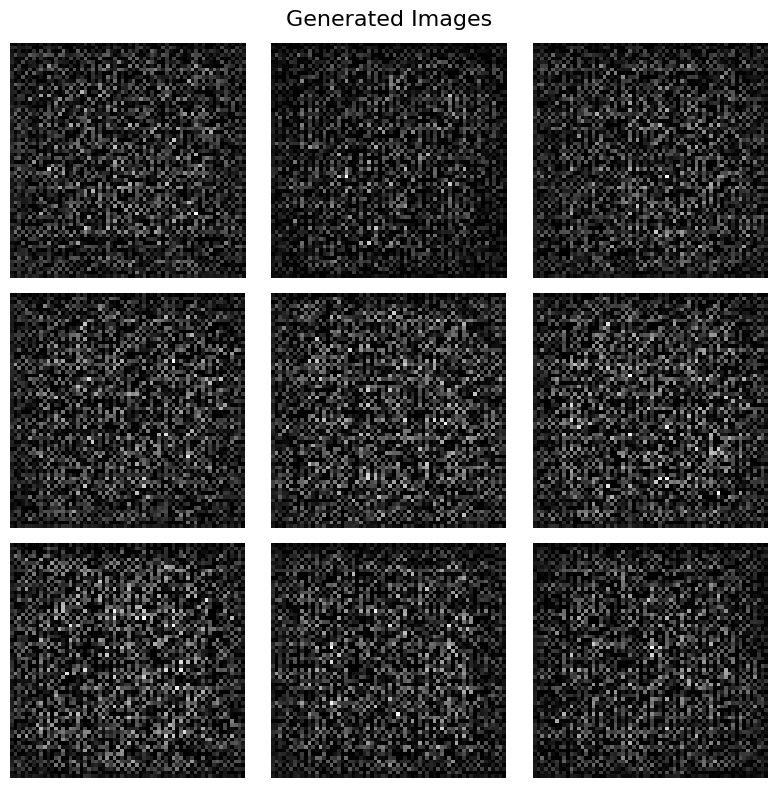

In [15]:
_batch_size = 4
_in_channels = 20
_inputs = torch.randn(_batch_size, _in_channels, 1, 1).to(device)
_generator = Generator(_in_channels).to(device)
_outputs = _generator(_inputs)
show_generated(_generator, 20, device)
assert _outputs.shape == (_batch_size, 1, 64, 64)
del _batch_size, _in_channels, _inputs, _outputs

## Discriminatorの実装

Discriminatorは、Generatorの生成した画像が手書きかどうかを判定すれば良い。実現したい動作は普通のニューラルネットワークと同じなので、単純な実装で良いが、後述のGeneratorのバックプロパゲーションを考慮して活性化函数にはLeakyReLUを使用する。

In [16]:
class Discriminator(torch.nn.Sequential):
    def __init__(self):
        super().__init__(
            torch.nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        # convert (batch_size, 1, 1, 1) to (batch_size)
        return super().forward(x).view(-1)

In [17]:
_batch_size = 4
_inputs = torch.randn(_batch_size, 1, 64, 64)
_outputs = Discriminator()(_inputs)
assert _outputs.shape == (_batch_size,)
del _batch_size, _inputs, _outputs

## 学習

DiscriminarorをD, GeneratorをGと表すとする。
この時、$G(x)$は生成された画像のテンソルを示し、$D(G(x))$は生成された画像が手書き画像である確率を示す。

Generatorの損失関数は$-\Sigma \log D(G(x))$で表される。つまり、Generatorによる画像が偽物(手書き画像でない)とDiscriminatorによって判定されれば、$D(G(x))$は1未満になり、損失関数は大きな値を取ることになる。

Discriminatorの損失関数は2種類存在する。まず、MNISTのデータセットを入力とする場合は1を出力して欲しいので、損失関数は$-\log D(x)$となる。一方で、入力がGeneratorによる生成画像の場合には、0を出力して欲しいのだから、損失関数は$-\log (1-D(G(x)))$とすれば良い。

Discriminator, Generatorの学習は1つのミニバッチ内で両方行なってしまう(別々にそれぞれ学習するということはしない)。各ミニバッチでは、Discriminatorの学習を行なったのち、Generatorの学習を行う。Discriminatorの学習では、MNISTの教師データのミニバッチ数と同じ数だけGeneratorによる画像を生成する。この時の正解ラベルは、MNISTのデータセットには1、Generatorによる画像には0を与える。一方で、Generatorの学習では、先の生成画像を用いてバックプロバゲーションを行う。

In [18]:
def init_weight(m: torch.nn.Module):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [19]:
gc.collect()
torch.cuda.empty_cache()

In [20]:
generator = Generator(in_channels=20)
discriminator = Discriminator()
generator.apply(init_weight)
discriminator.apply(init_weight)

num_epochs = 1000

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

criterion = torch.nn.BCELoss()
real_label = 1.0
fake_label = 0.0

optimizer_d = flash.core.optimizers.LAMB(discriminator.parameters())
optimizer_g = flash.core.optimizers.LAMB(generator.parameters())

z_dim = 20
batch_size = 64

torch.backends.cudnn.benchmark = True

save_dir = "./results"
os.makedirs(save_dir, exist_ok=True)

Start training


Epoch: 1/1000, d_loss: 1.3347, g_loss: 0.6901, time: 18.4425 sec


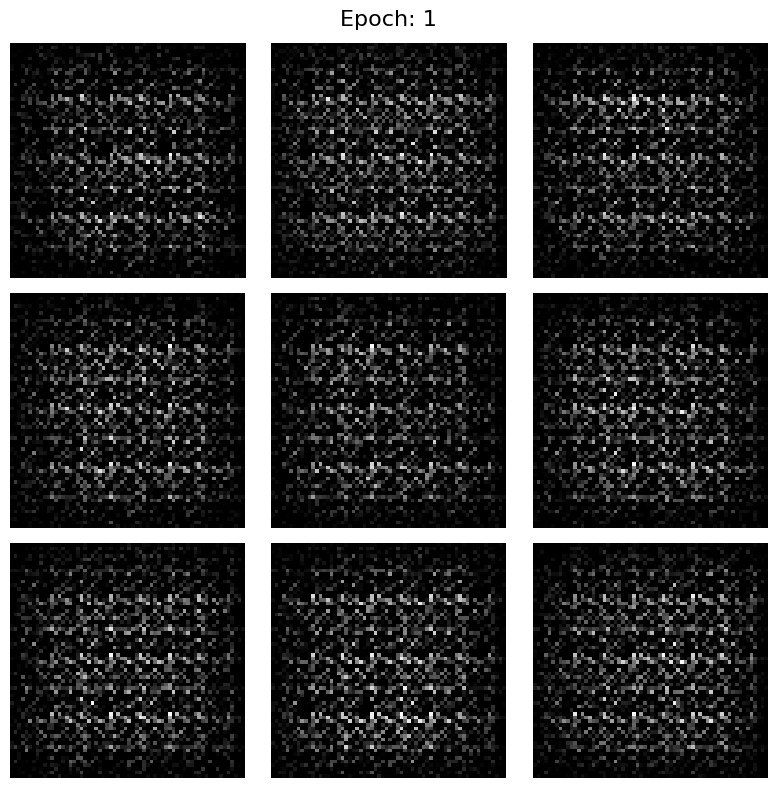

Epoch: 2/1000, d_loss: 1.1744, g_loss: 0.6979, time: 10.9465 sec


Epoch: 3/1000, d_loss: 1.0213, g_loss: 0.7870, time: 10.9260 sec


Epoch: 4/1000, d_loss: 1.0039, g_loss: 0.8114, time: 10.9116 sec


Epoch: 5/1000, d_loss: 1.1460, g_loss: 0.8080, time: 10.9669 sec


Epoch: 6/1000, d_loss: 1.0865, g_loss: 0.9347, time: 10.9237 sec


Epoch: 7/1000, d_loss: 0.8531, g_loss: 1.1141, time: 10.9566 sec


Epoch: 8/1000, d_loss: 0.9567, g_loss: 0.9776, time: 10.9767 sec


Epoch: 9/1000, d_loss: 1.5728, g_loss: 0.7655, time: 10.9567 sec


Epoch: 10/1000, d_loss: 0.8520, g_loss: 1.3785, time: 11.0229 sec


Epoch: 11/1000, d_loss: 0.5952, g_loss: 1.7482, time: 11.0140 sec


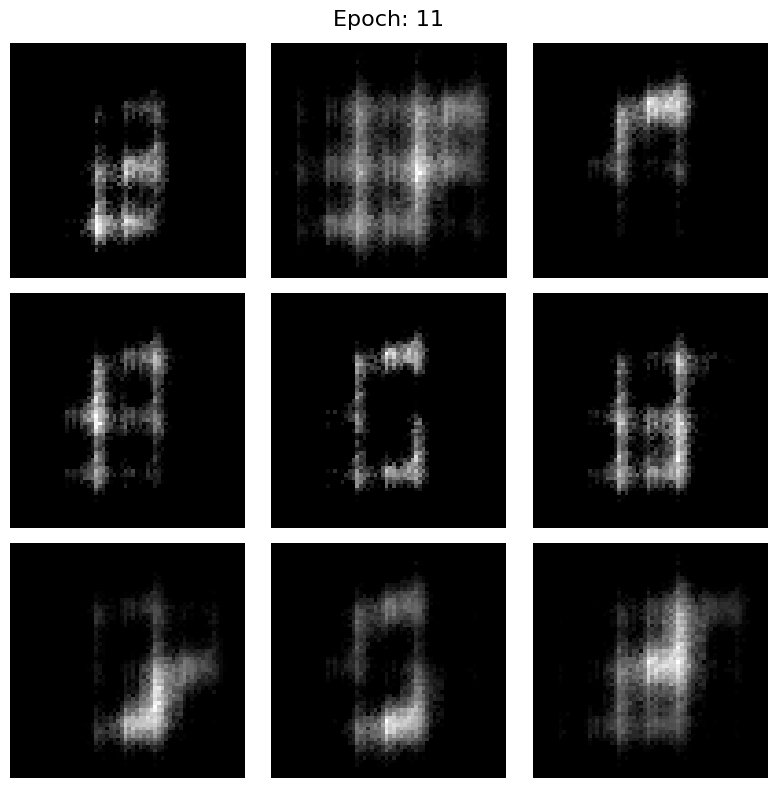

Epoch: 12/1000, d_loss: 1.2191, g_loss: 1.1300, time: 11.0010 sec


Epoch: 13/1000, d_loss: 1.2908, g_loss: 1.0019, time: 11.0290 sec


Epoch: 14/1000, d_loss: 1.1253, g_loss: 1.0860, time: 11.0182 sec


Epoch: 15/1000, d_loss: 0.8156, g_loss: 1.2433, time: 11.0052 sec


Epoch: 16/1000, d_loss: 0.8421, g_loss: 1.2290, time: 10.9926 sec


Epoch: 17/1000, d_loss: 1.5034, g_loss: 0.9162, time: 10.9918 sec


Epoch: 18/1000, d_loss: 1.4759, g_loss: 0.9944, time: 10.9763 sec


Epoch: 19/1000, d_loss: 1.2323, g_loss: 0.9821, time: 11.0192 sec


Epoch: 20/1000, d_loss: 1.0090, g_loss: 1.1255, time: 10.9587 sec


Epoch: 21/1000, d_loss: 0.9286, g_loss: 1.1126, time: 10.9658 sec


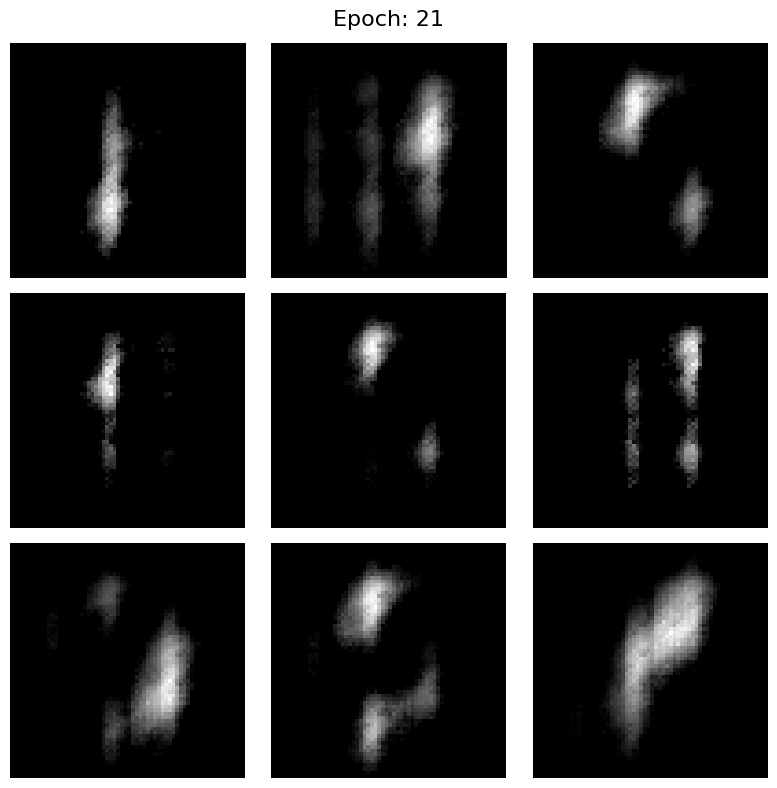

Epoch: 22/1000, d_loss: 1.0503, g_loss: 0.9876, time: 11.0057 sec


Epoch: 23/1000, d_loss: 0.9579, g_loss: 1.1237, time: 10.9717 sec


Epoch: 24/1000, d_loss: 0.9543, g_loss: 1.4477, time: 11.0205 sec


Epoch: 25/1000, d_loss: 0.9348, g_loss: 1.4573, time: 10.9666 sec


Epoch: 26/1000, d_loss: 0.9306, g_loss: 1.4226, time: 10.9956 sec


Epoch: 27/1000, d_loss: 0.6377, g_loss: 1.7105, time: 10.9806 sec


Epoch: 28/1000, d_loss: 0.4502, g_loss: 1.9584, time: 10.9660 sec


Epoch: 29/1000, d_loss: 1.3488, g_loss: 1.2510, time: 11.0092 sec


Epoch: 30/1000, d_loss: 1.3317, g_loss: 1.0302, time: 10.9932 sec


Epoch: 31/1000, d_loss: 0.8188, g_loss: 1.4550, time: 11.0132 sec


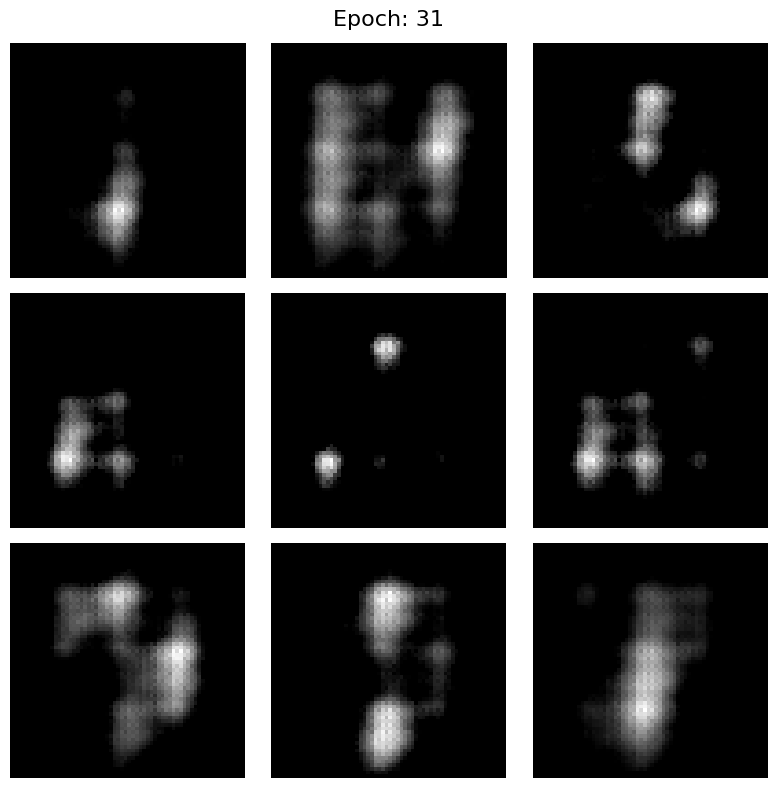

Epoch: 32/1000, d_loss: 1.0495, g_loss: 1.4110, time: 11.0332 sec


Epoch: 33/1000, d_loss: 1.2490, g_loss: 1.0682, time: 10.9901 sec


Epoch: 34/1000, d_loss: 0.7474, g_loss: 1.5197, time: 10.9819 sec


Epoch: 35/1000, d_loss: 0.8619, g_loss: 1.5196, time: 11.0129 sec


Epoch: 36/1000, d_loss: 0.5495, g_loss: 1.9953, time: 11.0186 sec


Epoch: 37/1000, d_loss: 1.4117, g_loss: 0.9088, time: 11.0265 sec


Epoch: 38/1000, d_loss: 0.8964, g_loss: 1.3543, time: 11.0177 sec


Epoch: 39/1000, d_loss: 0.8062, g_loss: 1.4053, time: 10.9768 sec


Epoch: 40/1000, d_loss: 0.6734, g_loss: 1.5345, time: 10.9945 sec


Epoch: 41/1000, d_loss: 0.9962, g_loss: 1.1545, time: 10.9945 sec


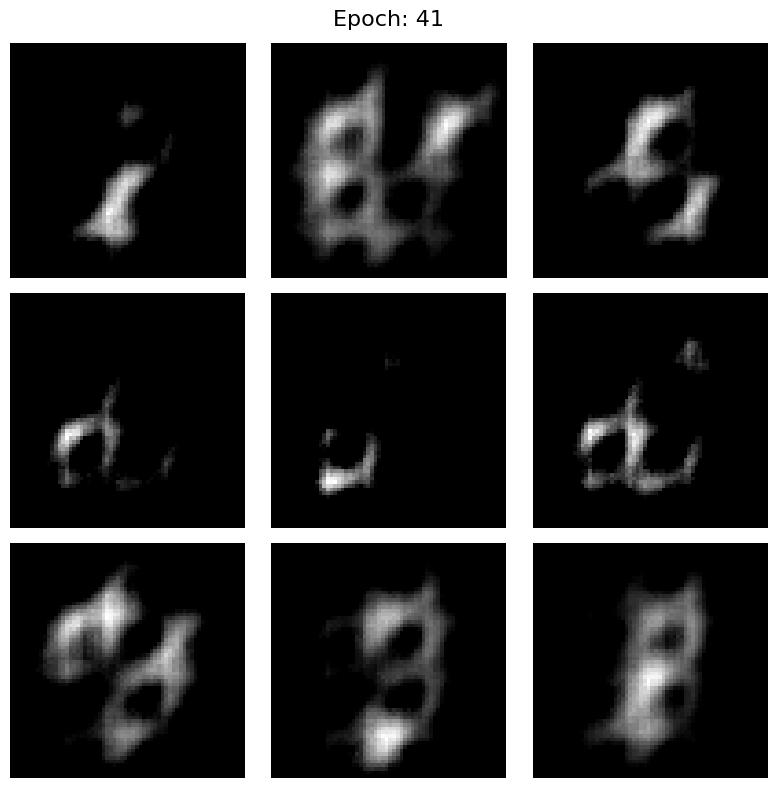

Epoch: 42/1000, d_loss: 1.0851, g_loss: 1.1036, time: 10.9714 sec


Epoch: 43/1000, d_loss: 0.4444, g_loss: 2.0119, time: 11.0969 sec


Epoch: 44/1000, d_loss: 0.3691, g_loss: 2.2352, time: 11.0132 sec


Epoch: 45/1000, d_loss: 0.4385, g_loss: 2.0028, time: 11.1520 sec


Epoch: 46/1000, d_loss: 0.7574, g_loss: 1.8164, time: 10.9754 sec


Epoch: 47/1000, d_loss: 0.7028, g_loss: 2.0456, time: 11.0091 sec


Epoch: 48/1000, d_loss: 0.1505, g_loss: 3.9611, time: 11.0015 sec


Epoch: 49/1000, d_loss: 0.3792, g_loss: 2.5433, time: 11.0039 sec


Epoch: 50/1000, d_loss: 0.6016, g_loss: 1.8052, time: 10.9860 sec


Epoch: 51/1000, d_loss: 0.5270, g_loss: 2.2628, time: 10.9670 sec


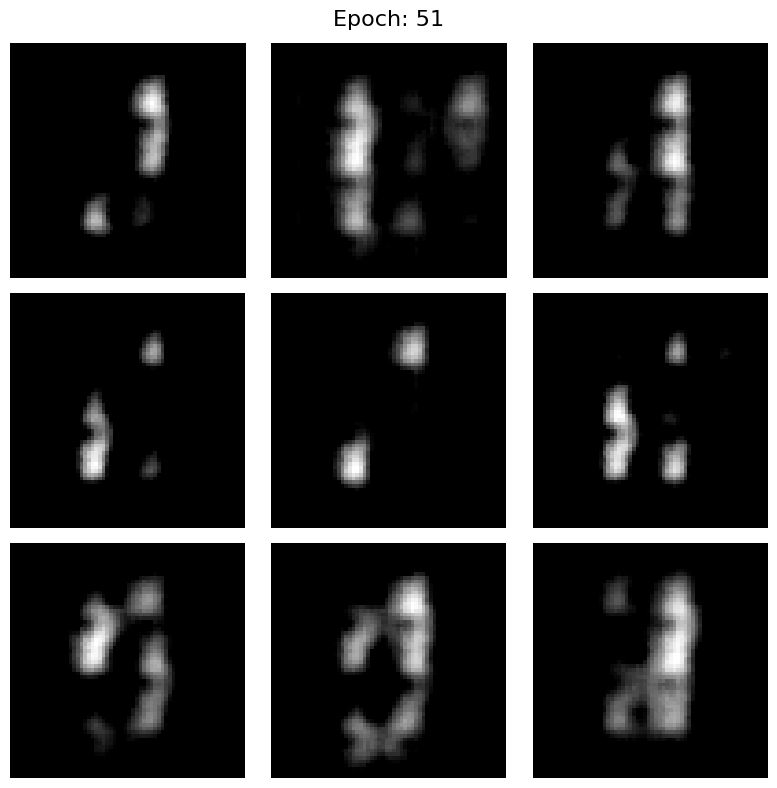

Epoch: 52/1000, d_loss: 0.4741, g_loss: 2.4306, time: 10.9895 sec


Epoch: 53/1000, d_loss: 0.2829, g_loss: 2.7931, time: 10.9921 sec


Epoch: 54/1000, d_loss: 0.2424, g_loss: 3.2407, time: 10.9807 sec


Epoch: 55/1000, d_loss: 0.0911, g_loss: 4.2024, time: 11.0179 sec


Epoch: 56/1000, d_loss: 0.3122, g_loss: 3.5089, time: 10.9794 sec


Epoch: 57/1000, d_loss: 0.2403, g_loss: 3.1429, time: 11.0201 sec


Epoch: 58/1000, d_loss: 0.4317, g_loss: 2.8391, time: 11.0019 sec


Epoch: 59/1000, d_loss: 0.1800, g_loss: 3.6394, time: 10.9738 sec


Epoch: 60/1000, d_loss: 0.0943, g_loss: 4.0183, time: 11.0031 sec


Epoch: 61/1000, d_loss: 0.1083, g_loss: 4.1647, time: 11.0240 sec


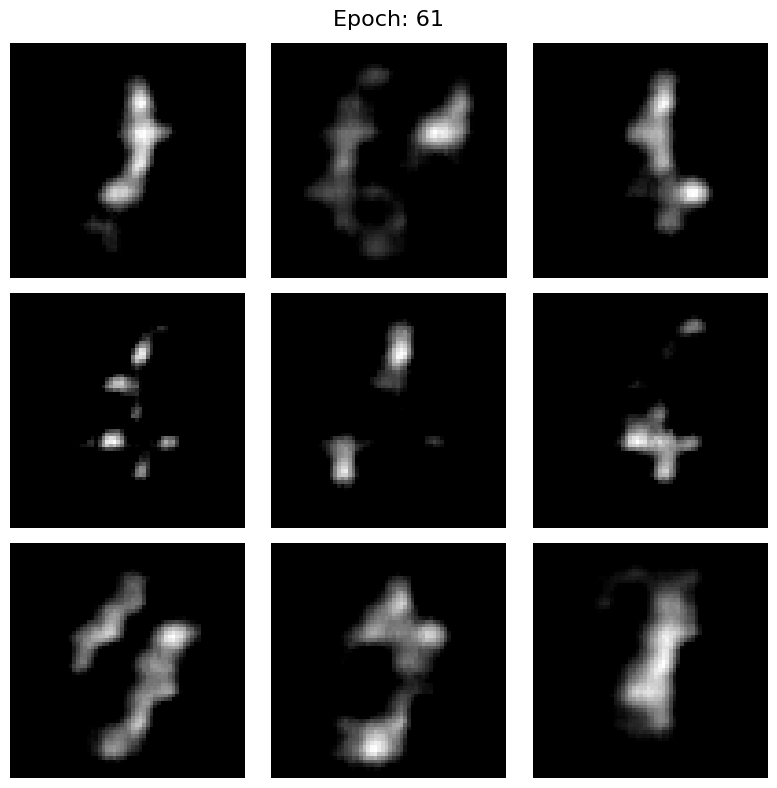

Epoch: 62/1000, d_loss: 0.1392, g_loss: 4.3293, time: 10.9747 sec


Epoch: 63/1000, d_loss: 0.0998, g_loss: 4.3688, time: 11.0187 sec


Epoch: 64/1000, d_loss: 0.1187, g_loss: 4.3310, time: 11.2430 sec


Epoch: 65/1000, d_loss: 0.1446, g_loss: 4.2453, time: 11.0057 sec


Epoch: 66/1000, d_loss: 0.3551, g_loss: 4.1202, time: 10.9902 sec


Epoch: 67/1000, d_loss: 0.1257, g_loss: 4.3740, time: 11.0014 sec


Epoch: 68/1000, d_loss: 0.2085, g_loss: 4.1951, time: 10.9779 sec


Epoch: 69/1000, d_loss: 0.1800, g_loss: 4.2009, time: 10.9806 sec


Epoch: 70/1000, d_loss: 0.0640, g_loss: 5.2040, time: 10.9773 sec


Epoch: 71/1000, d_loss: 0.0589, g_loss: 5.4153, time: 10.9854 sec


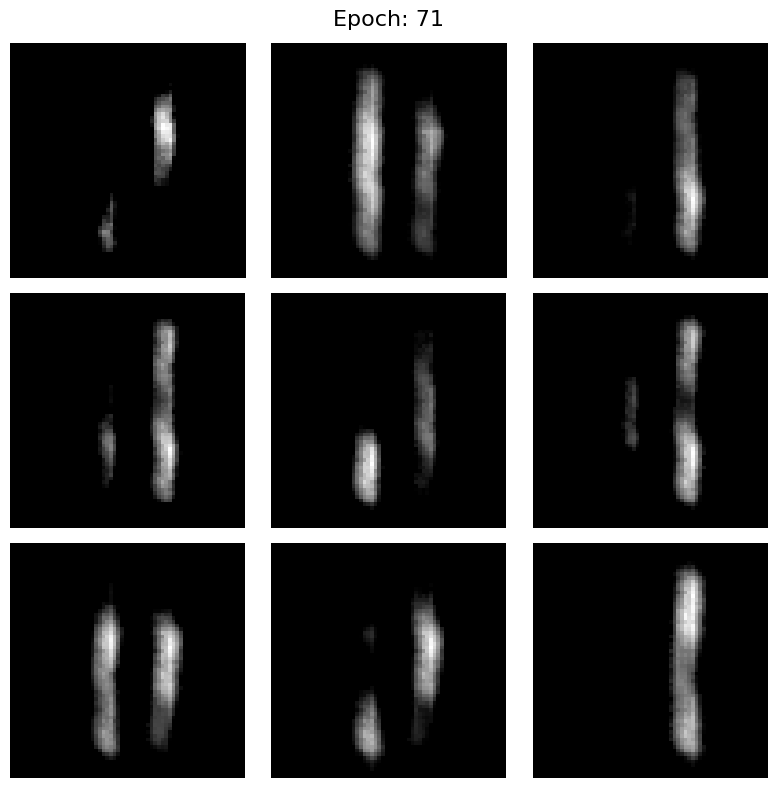

Epoch: 72/1000, d_loss: 0.0115, g_loss: 6.4812, time: 10.9578 sec


Epoch: 73/1000, d_loss: 0.0012, g_loss: 8.2805, time: 10.9960 sec


Epoch: 74/1000, d_loss: 0.0012, g_loss: 12.5025, time: 11.0087 sec


Epoch: 75/1000, d_loss: 0.0194, g_loss: 13.3890, time: 11.0413 sec


Epoch: 76/1000, d_loss: 0.4058, g_loss: 7.4866, time: 10.9721 sec


Epoch: 77/1000, d_loss: 0.3600, g_loss: 4.4763, time: 10.9539 sec


Epoch: 78/1000, d_loss: 0.1002, g_loss: 5.3799, time: 11.0158 sec


Epoch: 79/1000, d_loss: 0.0564, g_loss: 5.9780, time: 11.0434 sec


Epoch: 80/1000, d_loss: 0.0928, g_loss: 5.7608, time: 10.9894 sec


Epoch: 81/1000, d_loss: 0.1923, g_loss: 6.2220, time: 10.9592 sec


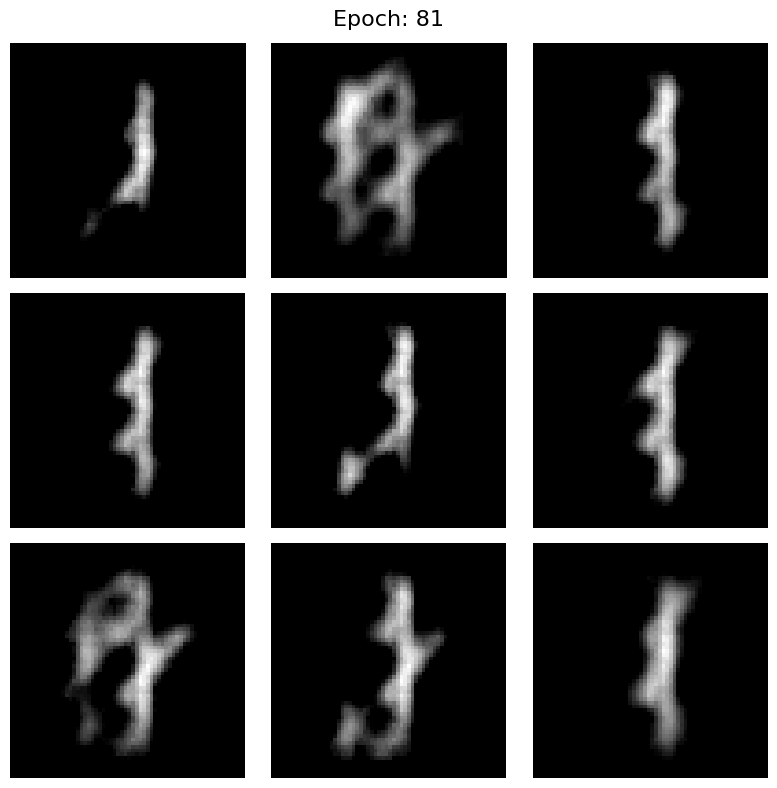

Epoch: 82/1000, d_loss: 0.3786, g_loss: 5.4024, time: 11.0524 sec


Epoch: 83/1000, d_loss: 0.0845, g_loss: 4.8233, time: 11.1040 sec


Epoch: 84/1000, d_loss: 0.1585, g_loss: 4.3951, time: 11.0156 sec


Epoch: 85/1000, d_loss: 0.1016, g_loss: 4.5816, time: 11.0115 sec


Epoch: 86/1000, d_loss: 0.0418, g_loss: 5.4903, time: 11.0454 sec


Epoch: 87/1000, d_loss: 0.0318, g_loss: 6.2514, time: 10.9757 sec


Epoch: 88/1000, d_loss: 0.1103, g_loss: 5.1993, time: 10.9664 sec


Epoch: 89/1000, d_loss: 0.0379, g_loss: 5.7869, time: 10.9680 sec


Epoch: 90/1000, d_loss: 0.1206, g_loss: 7.2837, time: 10.9895 sec


Epoch: 91/1000, d_loss: 0.1016, g_loss: 6.3784, time: 10.9366 sec


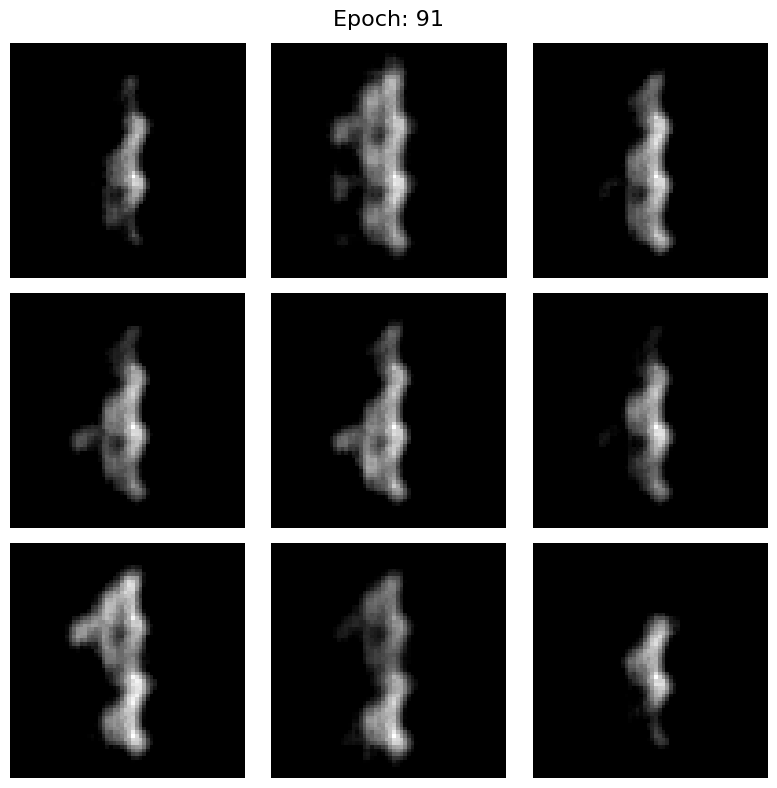

Epoch: 92/1000, d_loss: 0.0849, g_loss: 5.9174, time: 10.9586 sec


Epoch: 93/1000, d_loss: 0.0420, g_loss: 5.8134, time: 11.0036 sec


Epoch: 94/1000, d_loss: 0.0453, g_loss: 6.4354, time: 10.9623 sec


Epoch: 95/1000, d_loss: 0.0530, g_loss: 6.1195, time: 11.0104 sec


Epoch: 96/1000, d_loss: 0.1587, g_loss: 5.3527, time: 10.9709 sec


Epoch: 97/1000, d_loss: 0.0205, g_loss: 6.2845, time: 10.9776 sec


Epoch: 98/1000, d_loss: 0.0056, g_loss: 8.5679, time: 10.9501 sec


Epoch: 99/1000, d_loss: 0.3582, g_loss: 8.3474, time: 10.9517 sec


Epoch: 100/1000, d_loss: 0.6143, g_loss: 4.4964, time: 10.9383 sec


Epoch: 101/1000, d_loss: 0.4245, g_loss: 3.9610, time: 10.9417 sec


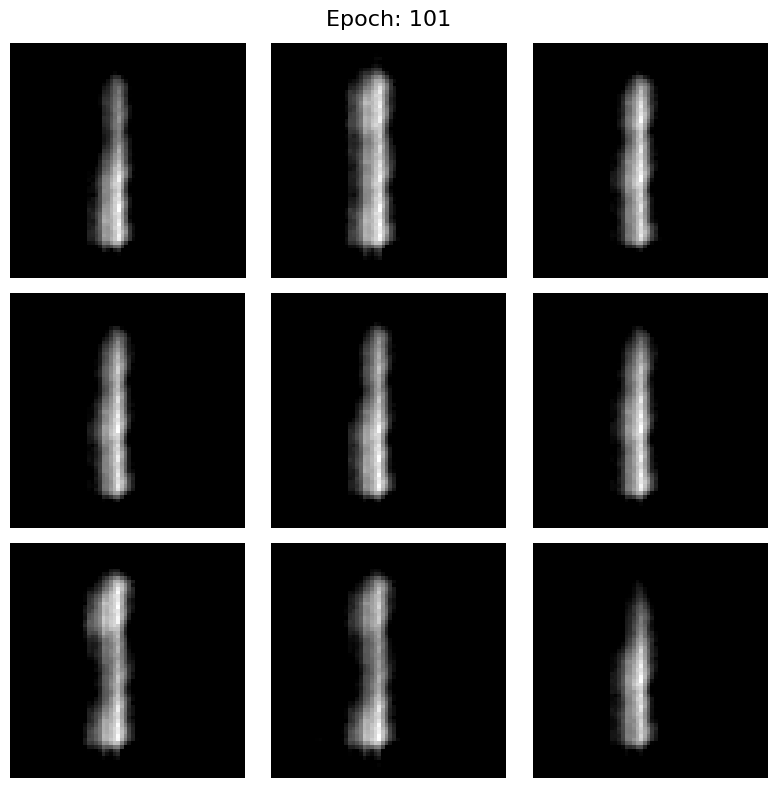

Epoch: 102/1000, d_loss: 0.1160, g_loss: 4.3313, time: 10.9571 sec


Epoch: 103/1000, d_loss: 0.0255, g_loss: 5.5400, time: 10.9577 sec


Epoch: 104/1000, d_loss: 0.0128, g_loss: 7.8981, time: 10.9433 sec


Epoch: 105/1000, d_loss: 0.0057, g_loss: 9.2304, time: 10.9890 sec


Epoch: 106/1000, d_loss: 0.0038, g_loss: 9.8806, time: 10.9918 sec


Epoch: 107/1000, d_loss: 0.0015, g_loss: 10.4578, time: 10.9596 sec


Epoch: 108/1000, d_loss: 0.0107, g_loss: 10.9287, time: 10.9654 sec


Epoch: 109/1000, d_loss: 0.2370, g_loss: 9.6358, time: 10.9460 sec


Epoch: 110/1000, d_loss: 0.1284, g_loss: 5.1288, time: 11.0068 sec


Epoch: 111/1000, d_loss: 0.0297, g_loss: 7.1384, time: 11.0032 sec


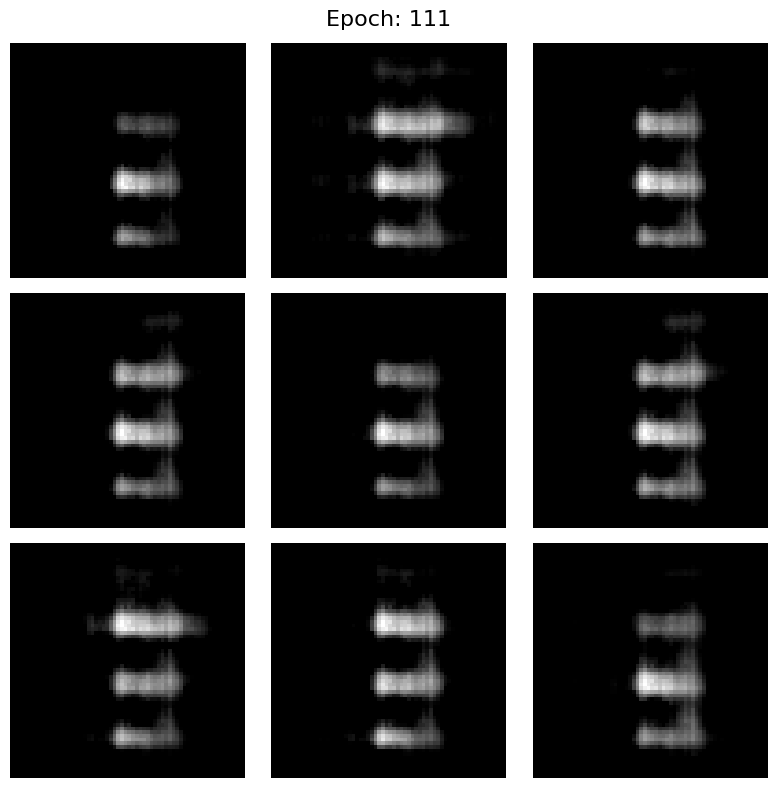

Epoch: 112/1000, d_loss: 0.0036, g_loss: 10.9695, time: 10.9652 sec


Epoch: 113/1000, d_loss: 0.0650, g_loss: 14.1543, time: 10.9757 sec


Epoch: 114/1000, d_loss: 0.0348, g_loss: 10.4696, time: 10.9465 sec


Epoch: 115/1000, d_loss: 0.0022, g_loss: 11.4196, time: 11.0029 sec


Epoch: 116/1000, d_loss: 0.1175, g_loss: 8.7650, time: 10.9639 sec


Epoch: 117/1000, d_loss: 0.2289, g_loss: 5.8781, time: 10.9834 sec


Epoch: 118/1000, d_loss: 0.1416, g_loss: 5.4032, time: 10.9883 sec


Epoch: 119/1000, d_loss: 0.0686, g_loss: 6.2375, time: 10.9521 sec


Epoch: 120/1000, d_loss: 0.0520, g_loss: 6.0136, time: 10.9662 sec


Epoch: 121/1000, d_loss: 0.0573, g_loss: 5.0545, time: 10.9619 sec


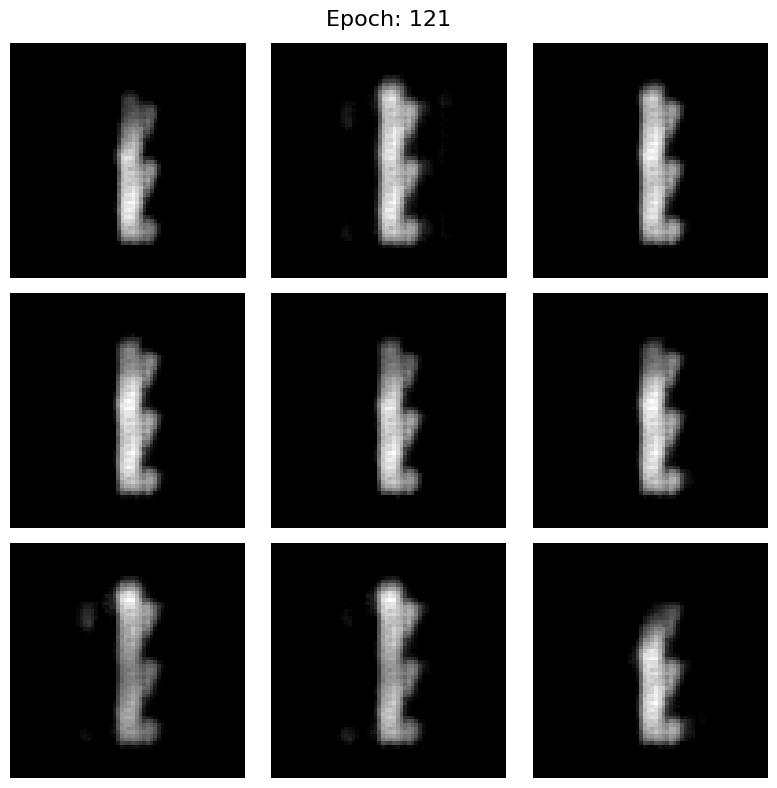

Epoch: 122/1000, d_loss: 0.1213, g_loss: 6.4350, time: 10.9476 sec


Epoch: 123/1000, d_loss: 0.2034, g_loss: 7.1098, time: 10.9995 sec


Epoch: 124/1000, d_loss: 0.0550, g_loss: 6.2429, time: 10.9558 sec


Epoch: 125/1000, d_loss: 0.1274, g_loss: 5.5354, time: 10.9900 sec


Epoch: 126/1000, d_loss: 0.0485, g_loss: 5.3874, time: 11.0028 sec


Epoch: 127/1000, d_loss: 0.0072, g_loss: 7.8604, time: 10.9442 sec


Epoch: 128/1000, d_loss: 0.0363, g_loss: 7.4787, time: 10.9472 sec


Epoch: 129/1000, d_loss: 0.0861, g_loss: 5.7281, time: 10.9835 sec


Epoch: 130/1000, d_loss: 0.0157, g_loss: 6.7735, time: 10.9628 sec


Epoch: 131/1000, d_loss: 0.0090, g_loss: 7.5125, time: 10.9444 sec


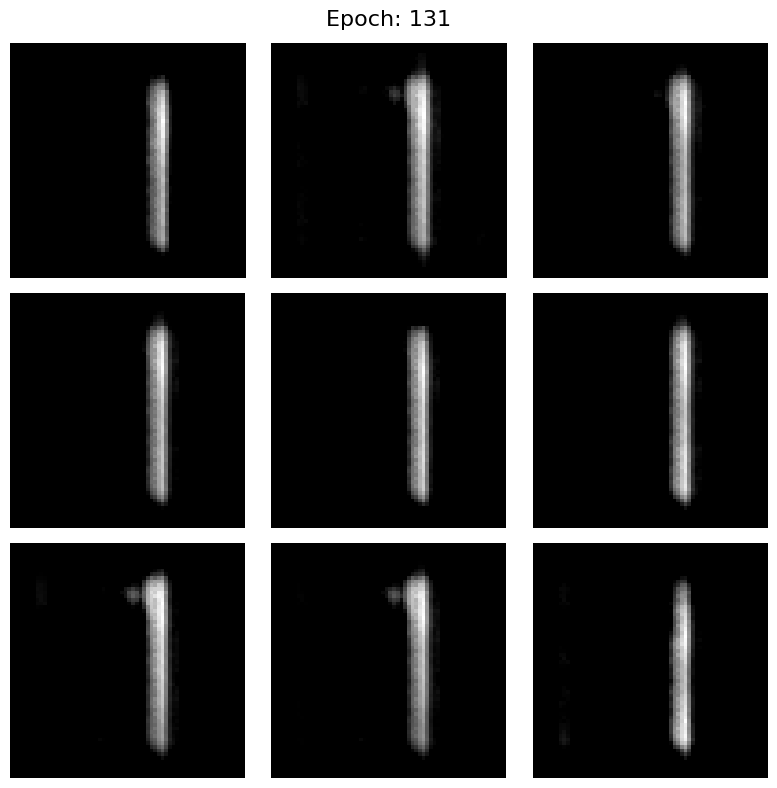

Epoch: 132/1000, d_loss: 0.0003, g_loss: 12.5979, time: 10.9660 sec


Epoch: 133/1000, d_loss: 0.0078, g_loss: 11.5764, time: 10.9913 sec


Epoch: 134/1000, d_loss: 0.0020, g_loss: 9.8775, time: 10.9714 sec


Epoch: 135/1000, d_loss: 0.0215, g_loss: 8.3703, time: 10.9594 sec


Epoch: 136/1000, d_loss: 0.0571, g_loss: 7.4994, time: 11.0041 sec


Epoch: 137/1000, d_loss: 0.0067, g_loss: 9.1569, time: 10.9589 sec


Epoch: 138/1000, d_loss: 0.2368, g_loss: 8.5942, time: 10.9839 sec


Epoch: 139/1000, d_loss: 0.0296, g_loss: 9.8422, time: 10.9684 sec


Epoch: 140/1000, d_loss: 0.0930, g_loss: 10.7913, time: 10.9739 sec


Epoch: 141/1000, d_loss: 0.0082, g_loss: 13.2507, time: 11.0029 sec


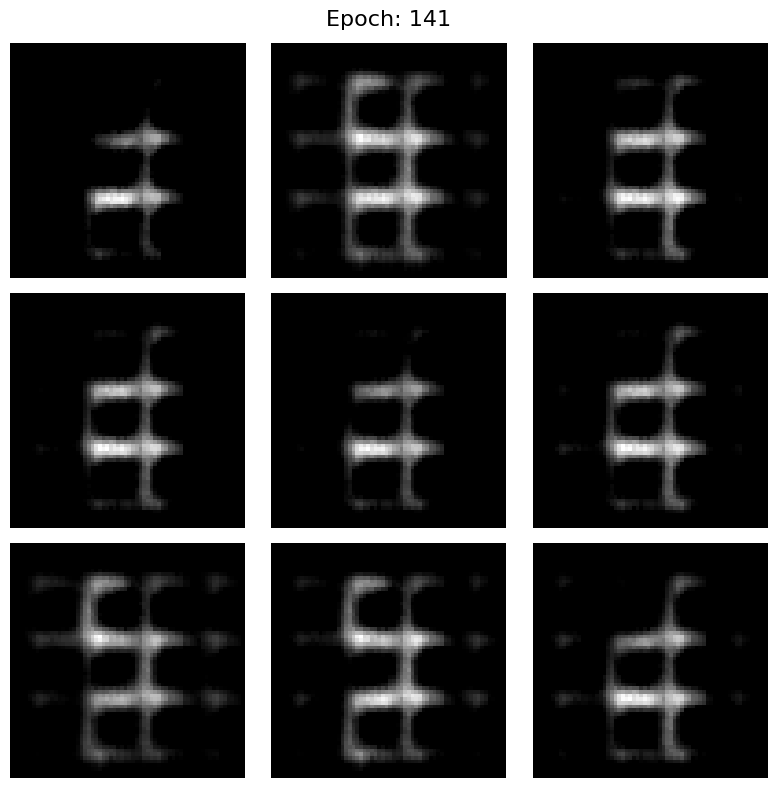

Epoch: 142/1000, d_loss: 0.0016, g_loss: 13.8338, time: 10.9429 sec


Epoch: 143/1000, d_loss: 0.0140, g_loss: 18.8250, time: 10.9632 sec


Epoch: 144/1000, d_loss: 0.0084, g_loss: 12.2191, time: 10.9514 sec


Epoch: 145/1000, d_loss: 0.0206, g_loss: 8.0744, time: 10.9486 sec


Epoch: 146/1000, d_loss: 0.0686, g_loss: 9.3214, time: 10.9775 sec


Epoch: 147/1000, d_loss: 0.0384, g_loss: 9.7863, time: 10.9614 sec


Epoch: 148/1000, d_loss: 0.0076, g_loss: 9.6403, time: 11.0093 sec


Epoch: 149/1000, d_loss: 0.0179, g_loss: 7.6184, time: 10.9753 sec


Epoch: 150/1000, d_loss: 0.0283, g_loss: 6.3399, time: 10.9662 sec


Epoch: 151/1000, d_loss: 0.0035, g_loss: 8.3543, time: 10.9778 sec


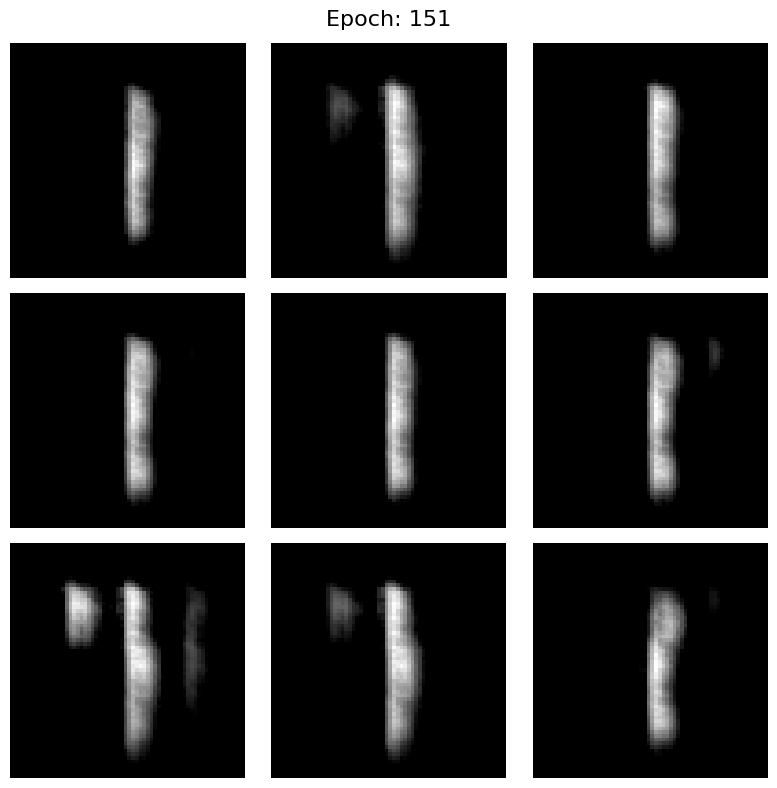

Epoch: 152/1000, d_loss: 0.0938, g_loss: 7.6634, time: 10.9491 sec


Epoch: 153/1000, d_loss: 0.3956, g_loss: 6.3662, time: 10.9685 sec


Epoch: 154/1000, d_loss: 0.1107, g_loss: 5.7977, time: 11.0238 sec


Epoch: 155/1000, d_loss: 0.0471, g_loss: 6.8291, time: 10.9937 sec


Epoch: 156/1000, d_loss: 0.0657, g_loss: 7.2239, time: 10.9596 sec


Epoch: 157/1000, d_loss: 0.4847, g_loss: 6.6129, time: 10.9853 sec


Epoch: 158/1000, d_loss: 0.1384, g_loss: 6.3032, time: 10.9518 sec


Epoch: 159/1000, d_loss: 0.0026, g_loss: 10.3032, time: 11.0017 sec


Epoch: 160/1000, d_loss: 0.0285, g_loss: 9.3955, time: 11.0145 sec


Epoch: 161/1000, d_loss: 0.0420, g_loss: 8.6696, time: 10.9573 sec


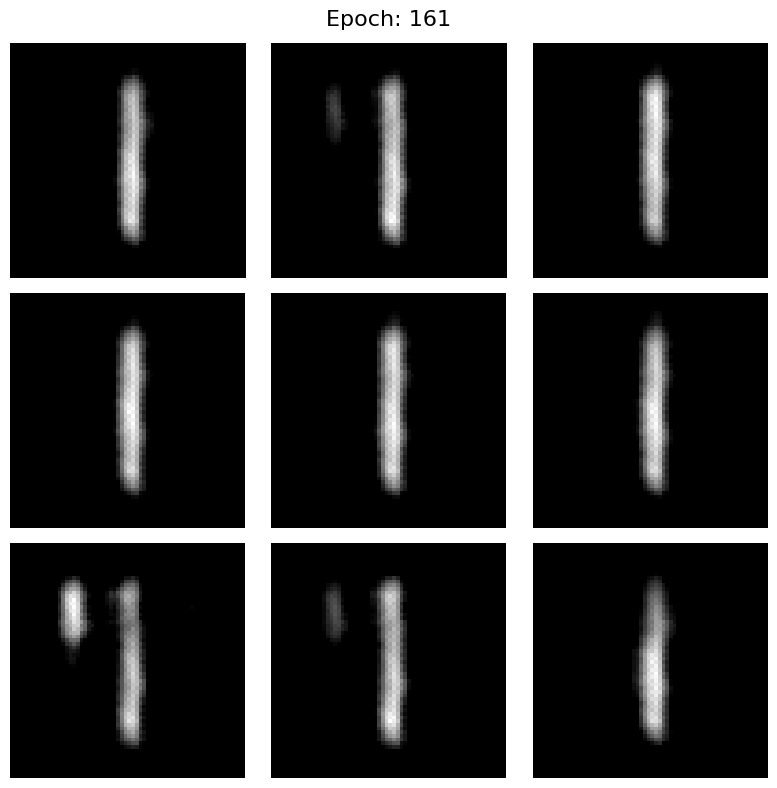

Epoch: 162/1000, d_loss: 0.0450, g_loss: 7.9549, time: 10.9668 sec


Epoch: 163/1000, d_loss: 0.3708, g_loss: 8.2486, time: 10.9656 sec


Epoch: 164/1000, d_loss: 0.1275, g_loss: 5.7830, time: 10.9598 sec


Epoch: 165/1000, d_loss: 0.0071, g_loss: 7.4994, time: 11.0903 sec


Epoch: 166/1000, d_loss: 0.0242, g_loss: 9.0669, time: 10.9742 sec


Epoch: 167/1000, d_loss: 0.1476, g_loss: 7.0038, time: 10.9841 sec


Epoch: 168/1000, d_loss: 0.0722, g_loss: 7.6536, time: 10.9894 sec


Epoch: 169/1000, d_loss: 0.0232, g_loss: 7.9402, time: 10.9571 sec


Epoch: 170/1000, d_loss: 0.0315, g_loss: 7.1001, time: 10.9618 sec


Epoch: 171/1000, d_loss: 0.0049, g_loss: 7.9785, time: 10.9723 sec


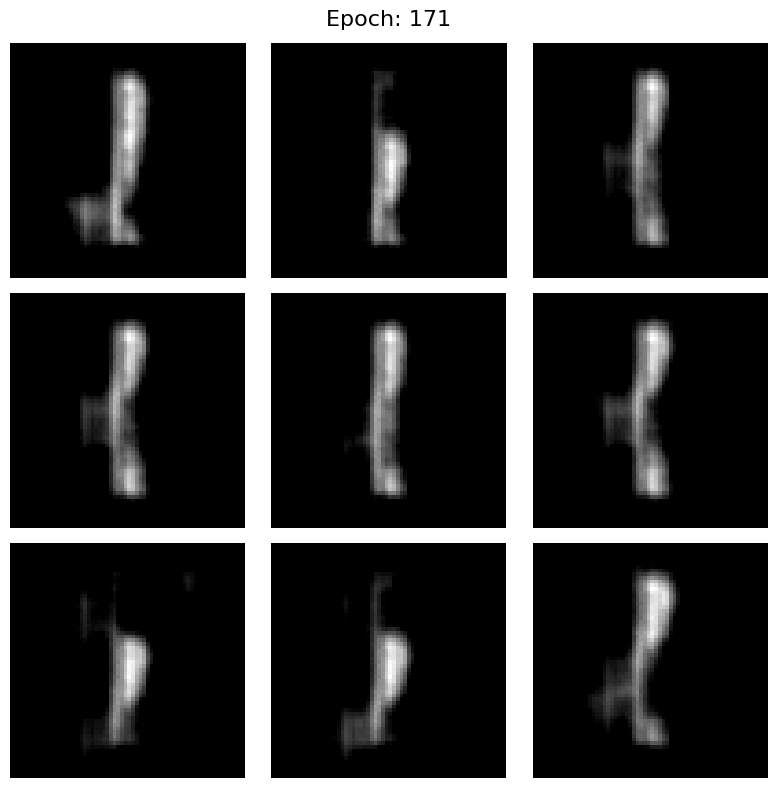

Epoch: 172/1000, d_loss: 0.1125, g_loss: 9.7827, time: 11.0167 sec


Epoch: 173/1000, d_loss: 0.2043, g_loss: 7.5765, time: 10.9890 sec


Epoch: 174/1000, d_loss: 0.1682, g_loss: 5.5238, time: 10.9922 sec


Epoch: 175/1000, d_loss: 0.0101, g_loss: 8.3963, time: 10.9558 sec


Epoch: 176/1000, d_loss: 0.0073, g_loss: 7.9641, time: 10.9866 sec


Epoch: 177/1000, d_loss: 0.0046, g_loss: 8.6104, time: 11.0180 sec


Epoch: 178/1000, d_loss: 0.0048, g_loss: 11.0919, time: 11.0057 sec


Epoch: 179/1000, d_loss: 0.0636, g_loss: 10.8181, time: 10.9915 sec


Epoch: 180/1000, d_loss: 0.1283, g_loss: 9.7875, time: 11.0427 sec


Epoch: 181/1000, d_loss: 0.0580, g_loss: 7.2803, time: 10.9963 sec


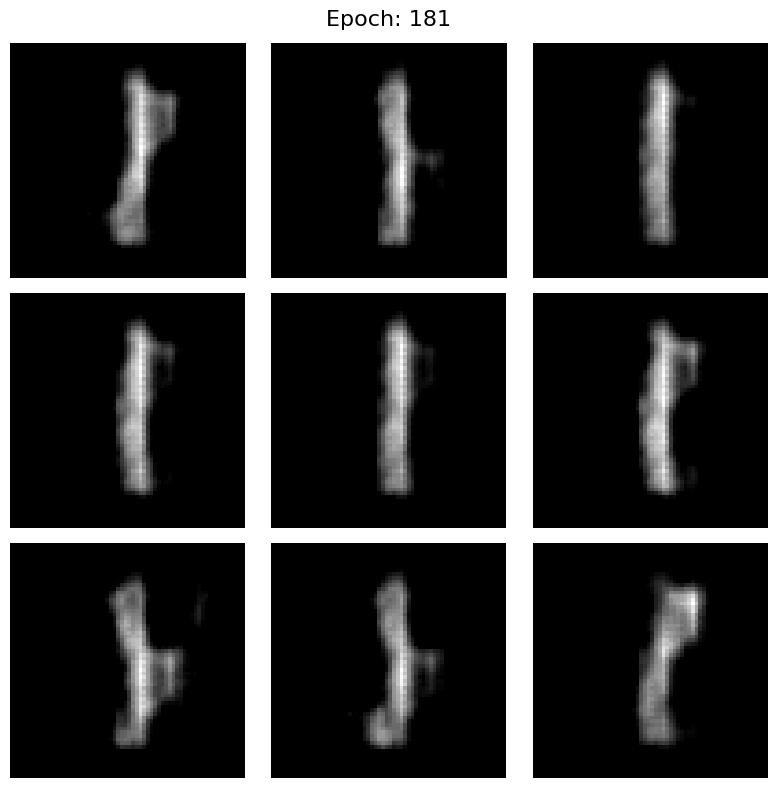

Epoch: 182/1000, d_loss: 0.0381, g_loss: 5.9355, time: 11.0231 sec


Epoch: 183/1000, d_loss: 0.0496, g_loss: 6.2041, time: 10.9563 sec


Epoch: 184/1000, d_loss: 0.2824, g_loss: 6.6425, time: 11.0248 sec


Epoch: 185/1000, d_loss: 0.0787, g_loss: 5.5563, time: 11.0213 sec


Epoch: 186/1000, d_loss: 0.0989, g_loss: 4.3974, time: 11.0695 sec


Epoch: 187/1000, d_loss: 0.1139, g_loss: 5.0725, time: 10.9850 sec


Epoch: 188/1000, d_loss: 0.1471, g_loss: 5.2769, time: 11.0939 sec


Epoch: 189/1000, d_loss: 0.0973, g_loss: 4.4306, time: 10.9948 sec


Epoch: 190/1000, d_loss: 0.2541, g_loss: 5.7727, time: 10.9360 sec


Epoch: 191/1000, d_loss: 0.0734, g_loss: 4.7688, time: 10.9564 sec


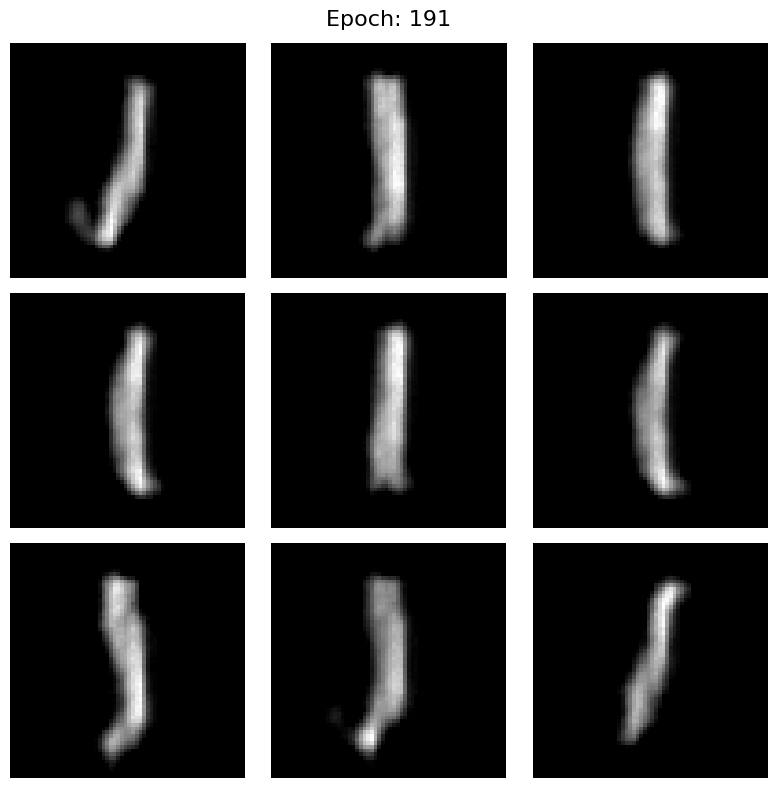

Epoch: 192/1000, d_loss: 0.1014, g_loss: 5.3745, time: 10.9578 sec


Epoch: 193/1000, d_loss: 0.1265, g_loss: 5.4604, time: 10.9367 sec


Epoch: 194/1000, d_loss: 0.0923, g_loss: 5.2154, time: 10.9794 sec


Epoch: 195/1000, d_loss: 0.1376, g_loss: 4.5667, time: 10.9881 sec


Epoch: 196/1000, d_loss: 0.0447, g_loss: 5.3884, time: 10.9391 sec


Epoch: 197/1000, d_loss: 0.0552, g_loss: 5.2871, time: 10.9549 sec


Epoch: 198/1000, d_loss: 0.1545, g_loss: 5.1847, time: 10.9483 sec


Epoch: 199/1000, d_loss: 0.1741, g_loss: 4.5837, time: 10.9390 sec


Epoch: 200/1000, d_loss: 0.1322, g_loss: 4.7530, time: 11.0029 sec


Epoch: 201/1000, d_loss: 0.1076, g_loss: 4.6571, time: 10.9554 sec


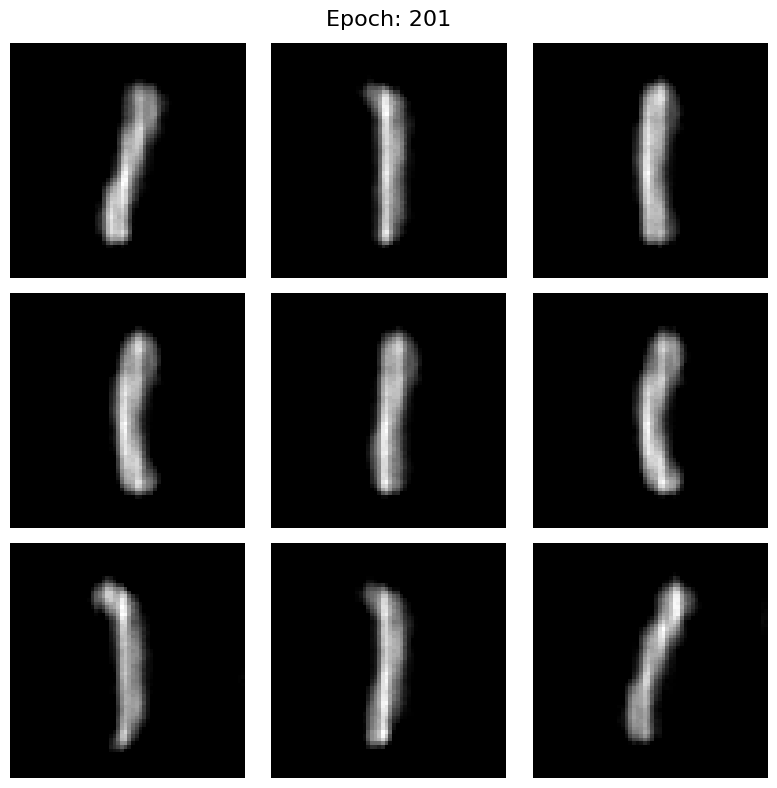

Epoch: 202/1000, d_loss: 0.1521, g_loss: 4.6503, time: 11.0158 sec


Epoch: 203/1000, d_loss: 0.1000, g_loss: 4.3252, time: 10.9538 sec


Epoch: 204/1000, d_loss: 0.1285, g_loss: 4.1277, time: 10.9629 sec


Epoch: 205/1000, d_loss: 0.1784, g_loss: 5.2764, time: 10.9873 sec


Epoch: 206/1000, d_loss: 0.2028, g_loss: 5.1000, time: 10.9769 sec


Epoch: 207/1000, d_loss: 0.1190, g_loss: 4.6605, time: 10.9356 sec


Epoch: 208/1000, d_loss: 0.1255, g_loss: 4.3803, time: 10.9920 sec


Epoch: 209/1000, d_loss: 0.0987, g_loss: 4.5304, time: 10.9673 sec


Epoch: 210/1000, d_loss: 0.1697, g_loss: 5.3767, time: 11.0096 sec


Epoch: 211/1000, d_loss: 0.1665, g_loss: 4.3232, time: 10.9707 sec


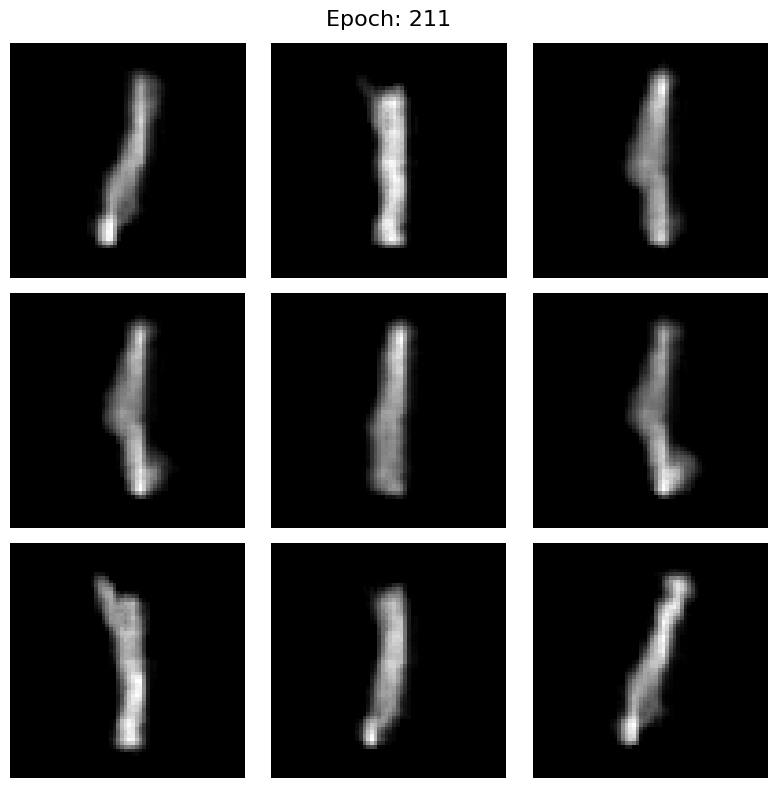

Epoch: 212/1000, d_loss: 0.1207, g_loss: 4.2074, time: 11.0376 sec


Epoch: 213/1000, d_loss: 0.1986, g_loss: 4.3002, time: 10.9646 sec


Epoch: 214/1000, d_loss: 0.1921, g_loss: 4.1374, time: 10.9442 sec


Epoch: 215/1000, d_loss: 0.1873, g_loss: 4.0501, time: 10.9434 sec


Epoch: 216/1000, d_loss: 0.1358, g_loss: 4.4834, time: 10.9656 sec


Epoch: 217/1000, d_loss: 0.1524, g_loss: 3.7769, time: 10.9709 sec


Epoch: 218/1000, d_loss: 0.1163, g_loss: 4.1121, time: 10.9530 sec


Epoch: 219/1000, d_loss: 0.1640, g_loss: 4.0745, time: 11.0091 sec


Epoch: 220/1000, d_loss: 0.0612, g_loss: 5.1031, time: 10.9509 sec


Epoch: 221/1000, d_loss: 0.1582, g_loss: 5.3296, time: 10.9674 sec


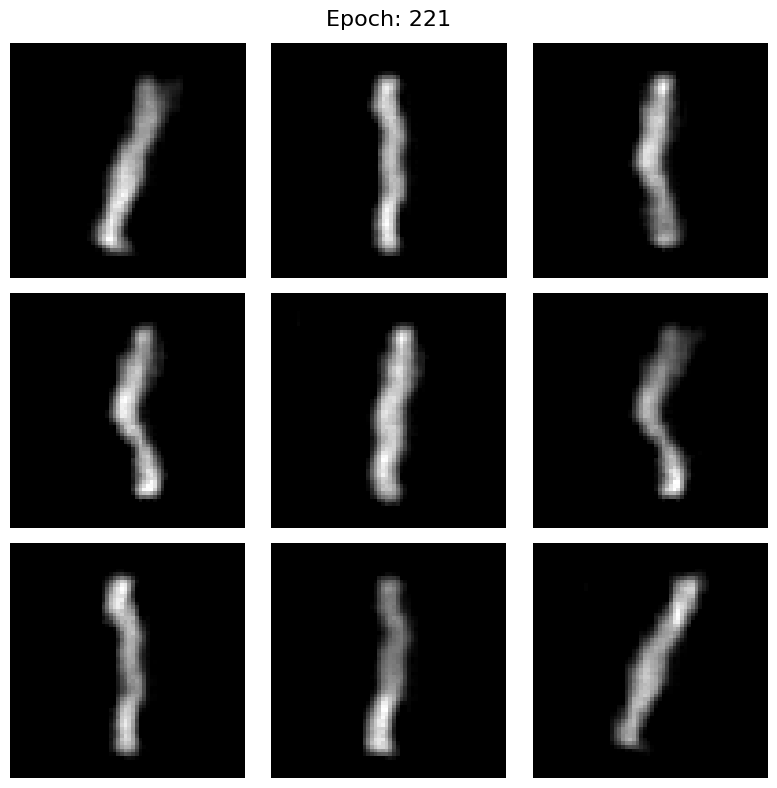

Epoch: 222/1000, d_loss: 0.2166, g_loss: 4.4347, time: 10.9745 sec


Epoch: 223/1000, d_loss: 0.2058, g_loss: 3.5673, time: 10.9947 sec


Epoch: 224/1000, d_loss: 0.1675, g_loss: 3.6227, time: 10.9461 sec


Epoch: 225/1000, d_loss: 0.1419, g_loss: 3.9814, time: 10.9375 sec


Epoch: 226/1000, d_loss: 0.1816, g_loss: 3.8839, time: 10.9561 sec


Epoch: 227/1000, d_loss: 0.1738, g_loss: 4.3322, time: 10.9266 sec


Epoch: 228/1000, d_loss: 0.2066, g_loss: 4.2656, time: 10.9314 sec


Epoch: 229/1000, d_loss: 0.1048, g_loss: 5.0983, time: 10.9855 sec


Epoch: 230/1000, d_loss: 0.1546, g_loss: 3.9047, time: 10.9645 sec


Epoch: 231/1000, d_loss: 0.2650, g_loss: 4.7584, time: 10.9350 sec


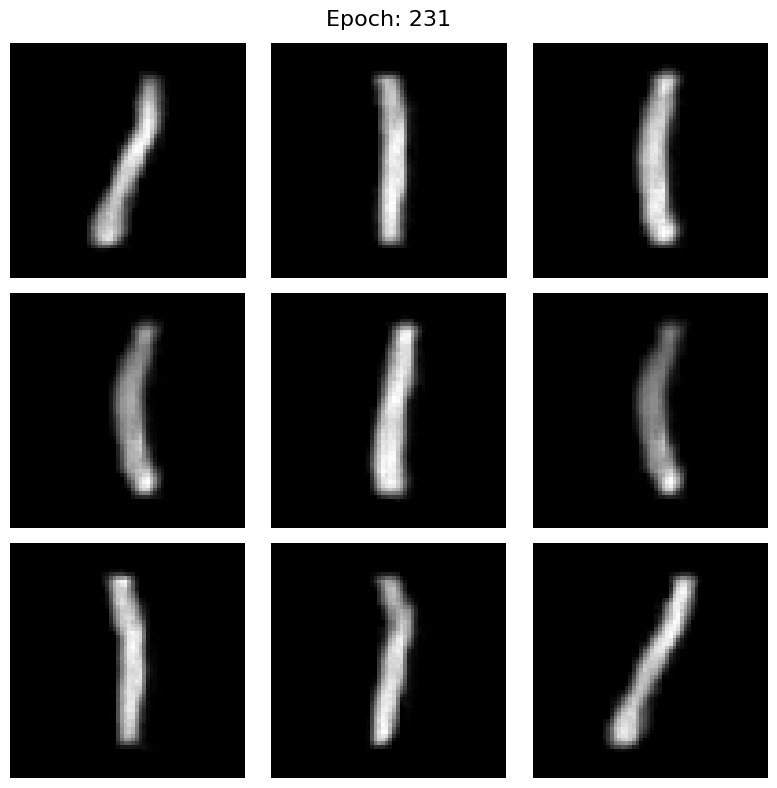

Epoch: 232/1000, d_loss: 0.2632, g_loss: 4.1930, time: 11.0984 sec


Epoch: 233/1000, d_loss: 0.1948, g_loss: 3.9317, time: 10.9597 sec


Epoch: 234/1000, d_loss: 0.1469, g_loss: 3.5223, time: 10.9849 sec


Epoch: 235/1000, d_loss: 0.1848, g_loss: 4.2205, time: 10.9444 sec


Epoch: 236/1000, d_loss: 0.2181, g_loss: 3.9112, time: 10.9446 sec


Epoch: 237/1000, d_loss: 0.1814, g_loss: 3.5757, time: 10.9710 sec


Epoch: 238/1000, d_loss: 0.1814, g_loss: 3.5783, time: 10.9750 sec


Epoch: 239/1000, d_loss: 0.1490, g_loss: 3.7515, time: 10.9468 sec


Epoch: 240/1000, d_loss: 0.1983, g_loss: 3.8289, time: 10.9540 sec


Epoch: 241/1000, d_loss: 0.1281, g_loss: 3.7634, time: 11.0104 sec


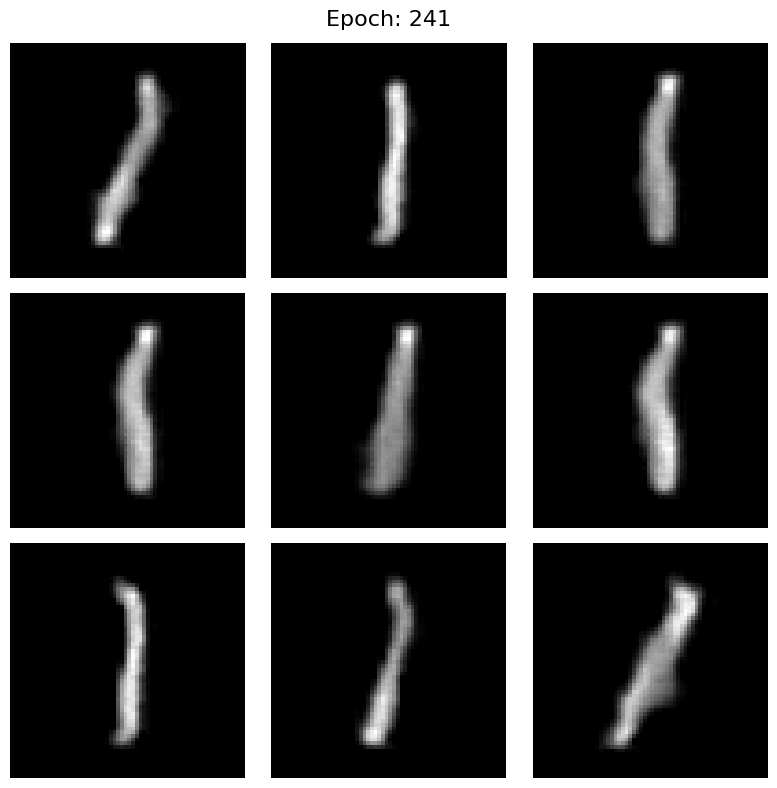

Epoch: 242/1000, d_loss: 0.1748, g_loss: 3.8720, time: 10.9594 sec


Epoch: 243/1000, d_loss: 0.1856, g_loss: 3.7303, time: 10.9553 sec


Epoch: 244/1000, d_loss: 0.2783, g_loss: 4.2269, time: 11.0307 sec


Epoch: 245/1000, d_loss: 0.2529, g_loss: 3.6494, time: 10.9498 sec


Epoch: 246/1000, d_loss: 0.2811, g_loss: 3.1614, time: 10.9933 sec


Epoch: 247/1000, d_loss: 0.1331, g_loss: 3.5601, time: 10.9531 sec


Epoch: 248/1000, d_loss: 0.1333, g_loss: 4.0507, time: 10.9796 sec


Epoch: 249/1000, d_loss: 0.2207, g_loss: 4.3656, time: 10.9387 sec


Epoch: 250/1000, d_loss: 0.2027, g_loss: 3.5898, time: 10.9514 sec


Epoch: 251/1000, d_loss: 0.1896, g_loss: 3.5142, time: 10.9593 sec


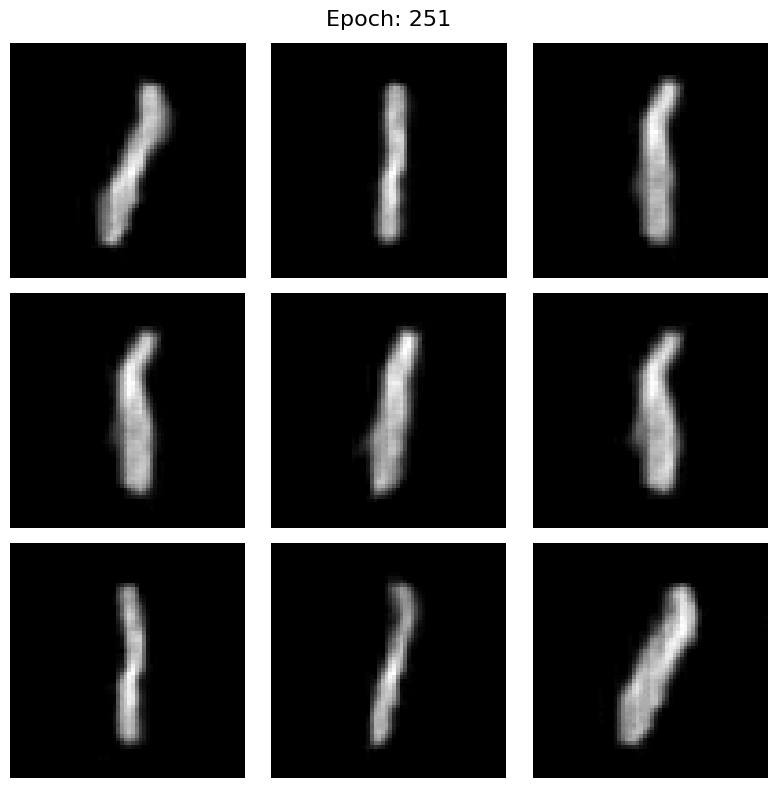

Epoch: 252/1000, d_loss: 0.1626, g_loss: 3.5695, time: 10.9733 sec


Epoch: 253/1000, d_loss: 0.2084, g_loss: 3.6856, time: 11.0247 sec


Epoch: 254/1000, d_loss: 0.2023, g_loss: 3.5215, time: 11.0059 sec


Epoch: 255/1000, d_loss: 0.2391, g_loss: 3.5147, time: 10.9614 sec


Epoch: 256/1000, d_loss: 0.2021, g_loss: 3.7529, time: 11.0041 sec


Epoch: 257/1000, d_loss: 0.1693, g_loss: 3.8471, time: 10.9279 sec


Epoch: 258/1000, d_loss: 0.1678, g_loss: 3.6463, time: 10.9454 sec


Epoch: 259/1000, d_loss: 0.1708, g_loss: 3.6661, time: 11.0221 sec


Epoch: 260/1000, d_loss: 0.1539, g_loss: 3.8994, time: 10.9293 sec


Epoch: 261/1000, d_loss: 0.2781, g_loss: 4.3485, time: 10.9578 sec


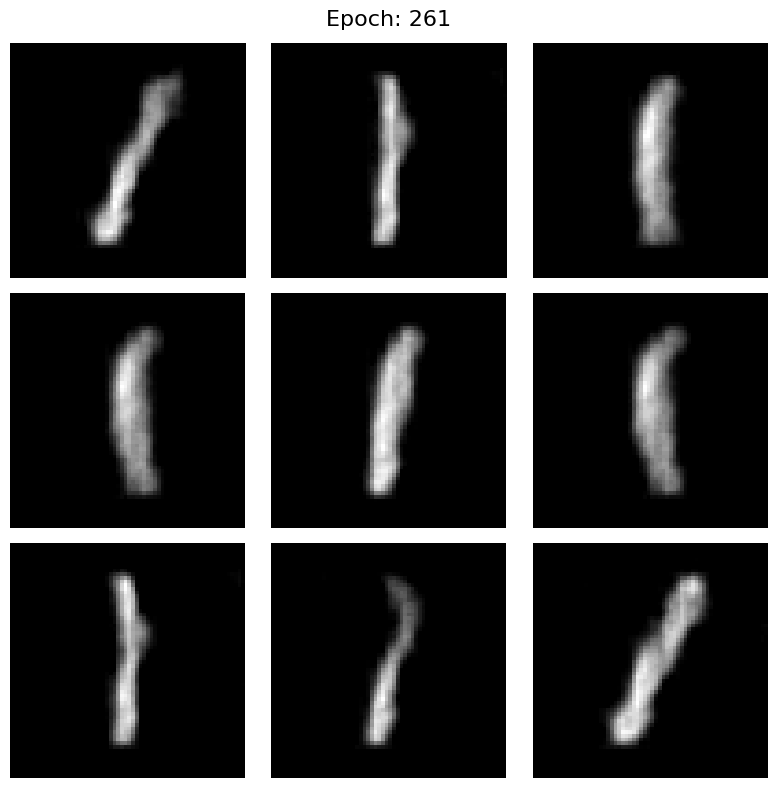

Epoch: 262/1000, d_loss: 0.2773, g_loss: 3.9943, time: 10.9589 sec


Epoch: 263/1000, d_loss: 0.1461, g_loss: 4.0637, time: 10.9455 sec


Epoch: 264/1000, d_loss: 0.2501, g_loss: 3.6132, time: 10.9645 sec


Epoch: 265/1000, d_loss: 0.1921, g_loss: 3.7293, time: 10.9252 sec


Epoch: 266/1000, d_loss: 0.1090, g_loss: 4.6153, time: 10.9664 sec


Epoch: 267/1000, d_loss: 0.1282, g_loss: 3.9321, time: 10.9614 sec


Epoch: 268/1000, d_loss: 0.1231, g_loss: 4.0427, time: 10.9545 sec


Epoch: 269/1000, d_loss: 0.0902, g_loss: 4.4313, time: 10.9389 sec


Epoch: 270/1000, d_loss: 0.1457, g_loss: 4.7531, time: 11.0033 sec


Epoch: 271/1000, d_loss: 0.1620, g_loss: 3.9627, time: 10.9591 sec


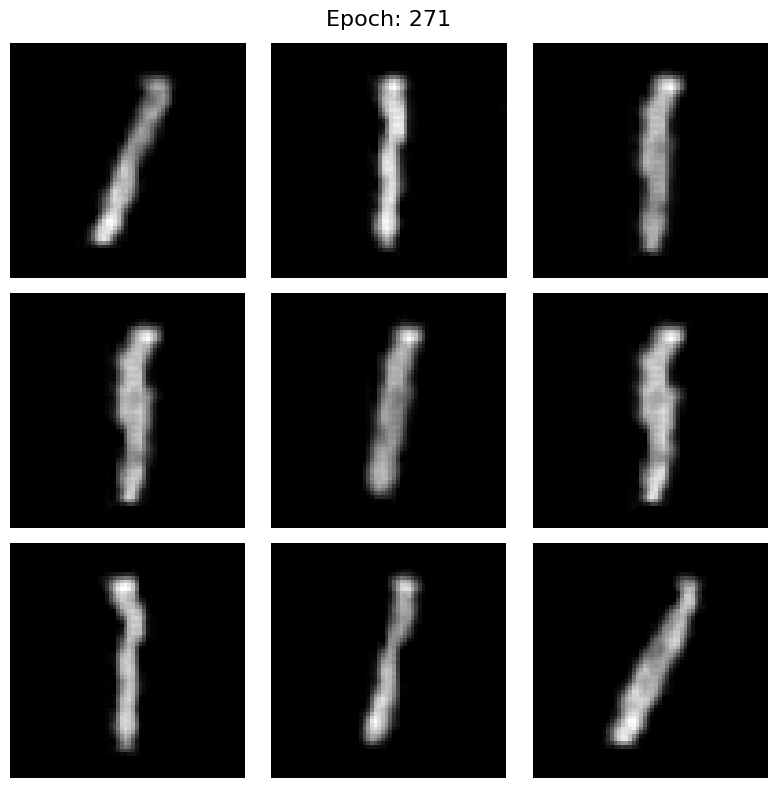

Epoch: 272/1000, d_loss: 0.2626, g_loss: 4.1361, time: 10.9899 sec


Epoch: 273/1000, d_loss: 0.1994, g_loss: 3.7972, time: 11.0089 sec


Epoch: 274/1000, d_loss: 0.1648, g_loss: 3.4971, time: 10.9614 sec


Epoch: 275/1000, d_loss: 0.2077, g_loss: 3.7328, time: 10.9953 sec


Epoch: 276/1000, d_loss: 0.3312, g_loss: 4.4524, time: 10.9288 sec


Epoch: 277/1000, d_loss: 0.2945, g_loss: 4.0169, time: 11.0041 sec


Epoch: 278/1000, d_loss: 0.1940, g_loss: 3.3614, time: 10.9564 sec


Epoch: 279/1000, d_loss: 0.1452, g_loss: 3.4923, time: 10.9962 sec


Epoch: 280/1000, d_loss: 0.2144, g_loss: 3.3557, time: 10.9637 sec


Epoch: 281/1000, d_loss: 0.2922, g_loss: 3.2997, time: 10.9715 sec


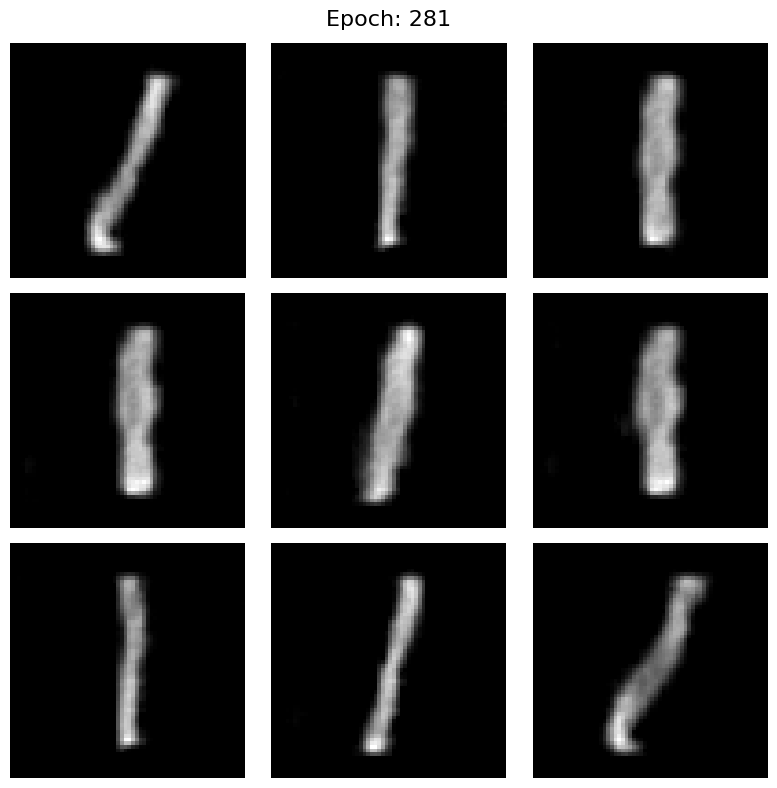

Epoch: 282/1000, d_loss: 0.2388, g_loss: 3.3747, time: 10.9621 sec


Epoch: 283/1000, d_loss: 0.1848, g_loss: 3.4897, time: 10.9589 sec


Epoch: 284/1000, d_loss: 0.1436, g_loss: 3.5729, time: 10.9636 sec


Epoch: 285/1000, d_loss: 0.1580, g_loss: 3.7189, time: 10.9571 sec


Epoch: 286/1000, d_loss: 0.1700, g_loss: 3.7895, time: 10.9394 sec


Epoch: 287/1000, d_loss: 0.1833, g_loss: 3.4707, time: 10.9922 sec


Epoch: 288/1000, d_loss: 0.1774, g_loss: 3.6056, time: 10.9652 sec


Epoch: 289/1000, d_loss: 0.2481, g_loss: 3.5816, time: 10.9950 sec


Epoch: 290/1000, d_loss: 0.2792, g_loss: 3.6812, time: 10.9601 sec


Epoch: 291/1000, d_loss: 0.3086, g_loss: 3.8776, time: 11.0331 sec


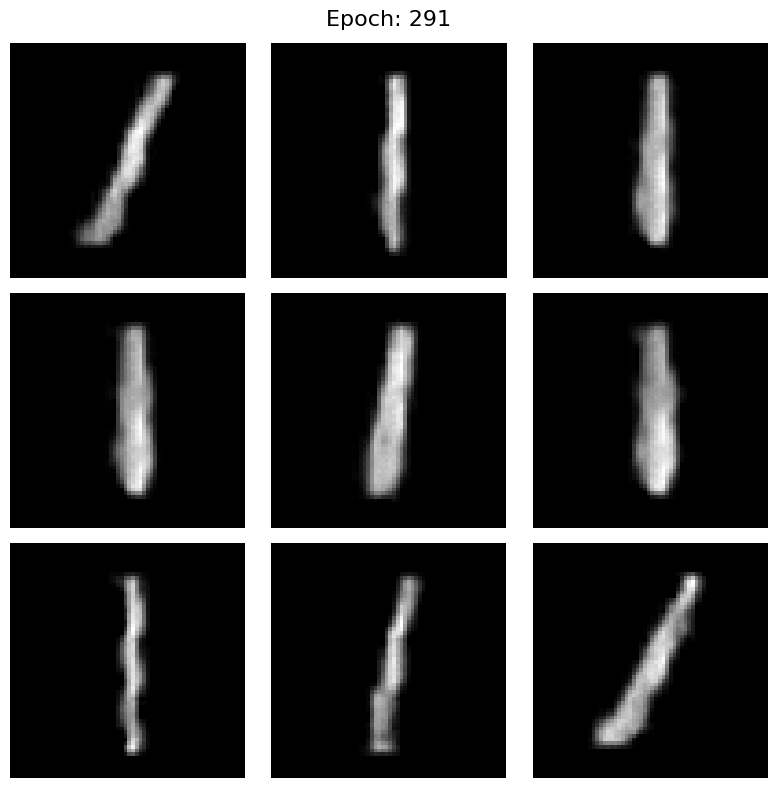

Epoch: 292/1000, d_loss: 0.2483, g_loss: 3.5835, time: 10.9529 sec


Epoch: 293/1000, d_loss: 0.2124, g_loss: 3.4955, time: 10.9812 sec


Epoch: 294/1000, d_loss: 0.1905, g_loss: 3.3360, time: 10.9715 sec


Epoch: 295/1000, d_loss: 0.2225, g_loss: 3.6245, time: 10.9505 sec


Epoch: 296/1000, d_loss: 0.1766, g_loss: 3.4661, time: 10.9735 sec


Epoch: 297/1000, d_loss: 0.1719, g_loss: 3.4683, time: 10.9890 sec


Epoch: 298/1000, d_loss: 0.3014, g_loss: 3.3672, time: 10.9820 sec


Epoch: 299/1000, d_loss: 0.3076, g_loss: 3.2297, time: 10.9657 sec


Epoch: 300/1000, d_loss: 0.2029, g_loss: 3.7522, time: 11.0173 sec


Epoch: 301/1000, d_loss: 0.1694, g_loss: 3.7499, time: 10.9462 sec


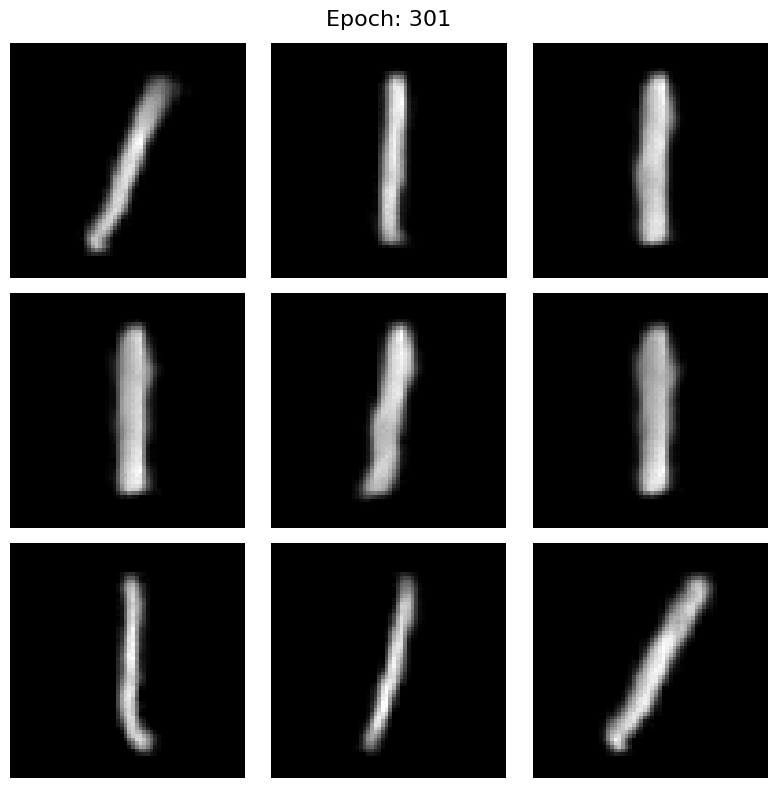

Epoch: 302/1000, d_loss: 0.2297, g_loss: 3.7171, time: 10.9148 sec


Epoch: 303/1000, d_loss: 0.3709, g_loss: 3.6873, time: 10.9790 sec


Epoch: 304/1000, d_loss: 0.2493, g_loss: 3.1070, time: 10.9372 sec


Epoch: 305/1000, d_loss: 0.1935, g_loss: 3.2478, time: 10.9271 sec


Epoch: 306/1000, d_loss: 0.1943, g_loss: 3.4333, time: 10.9970 sec


Epoch: 307/1000, d_loss: 0.2009, g_loss: 3.4964, time: 10.9446 sec


Epoch: 308/1000, d_loss: 0.2445, g_loss: 3.5116, time: 10.9739 sec


Epoch: 309/1000, d_loss: 0.2839, g_loss: 3.4137, time: 11.0084 sec


Epoch: 310/1000, d_loss: 0.3363, g_loss: 3.4048, time: 10.9539 sec


Epoch: 311/1000, d_loss: 0.2901, g_loss: 3.1652, time: 11.0071 sec


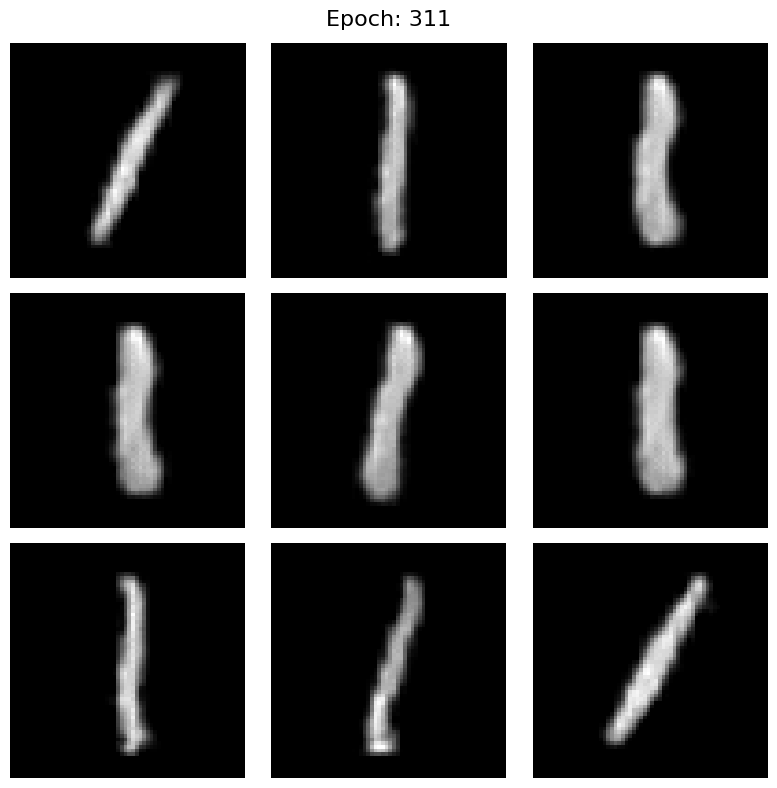

Epoch: 312/1000, d_loss: 0.2493, g_loss: 3.0728, time: 10.9862 sec


Epoch: 313/1000, d_loss: 0.2545, g_loss: 3.1149, time: 10.9850 sec


Epoch: 314/1000, d_loss: 0.2184, g_loss: 3.1439, time: 11.0223 sec


Epoch: 315/1000, d_loss: 0.2324, g_loss: 3.2344, time: 11.0184 sec


Epoch: 316/1000, d_loss: 0.3053, g_loss: 3.0301, time: 10.9811 sec


Epoch: 317/1000, d_loss: 0.2813, g_loss: 3.3078, time: 10.9672 sec


Epoch: 318/1000, d_loss: 0.2831, g_loss: 3.2043, time: 10.9650 sec


Epoch: 319/1000, d_loss: 0.2843, g_loss: 3.3459, time: 11.0209 sec


Epoch: 320/1000, d_loss: 0.3098, g_loss: 2.9839, time: 10.9502 sec


Epoch: 321/1000, d_loss: 0.2112, g_loss: 3.1496, time: 10.9628 sec


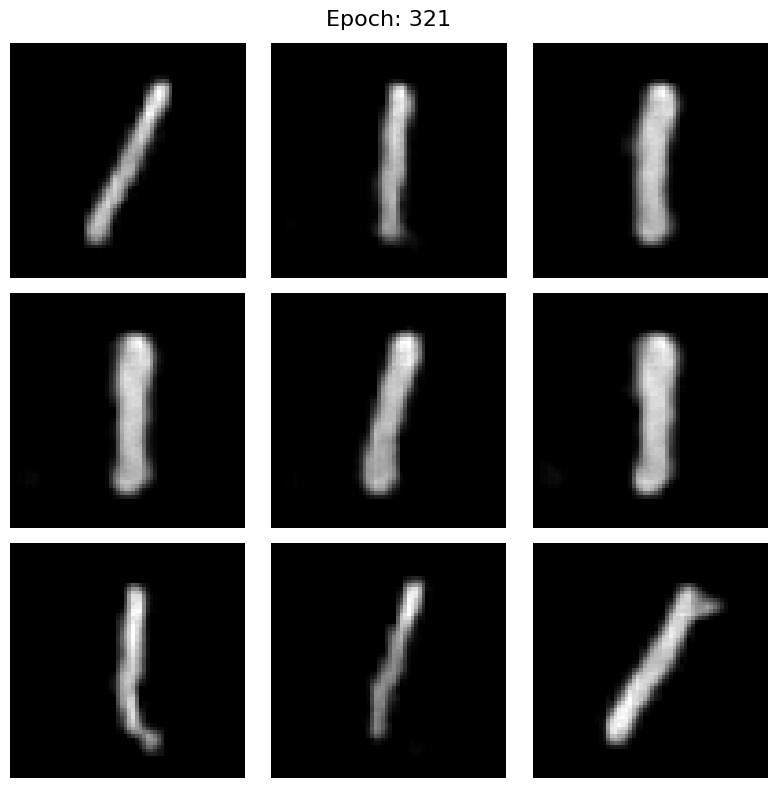

Epoch: 322/1000, d_loss: 0.2175, g_loss: 3.2761, time: 11.0057 sec


Epoch: 323/1000, d_loss: 0.3212, g_loss: 3.1512, time: 11.0204 sec


Epoch: 324/1000, d_loss: 0.2961, g_loss: 3.1150, time: 10.9434 sec


Epoch: 325/1000, d_loss: 0.2315, g_loss: 3.0924, time: 10.9770 sec


Epoch: 326/1000, d_loss: 0.2316, g_loss: 3.2098, time: 10.9648 sec


Epoch: 327/1000, d_loss: 0.2894, g_loss: 3.1432, time: 11.0023 sec


Epoch: 328/1000, d_loss: 0.2359, g_loss: 3.1142, time: 10.9274 sec


Epoch: 329/1000, d_loss: 0.2047, g_loss: 3.1837, time: 10.9858 sec


Epoch: 330/1000, d_loss: 0.2315, g_loss: 3.2261, time: 10.9611 sec


Epoch: 331/1000, d_loss: 0.2836, g_loss: 3.1197, time: 10.9581 sec


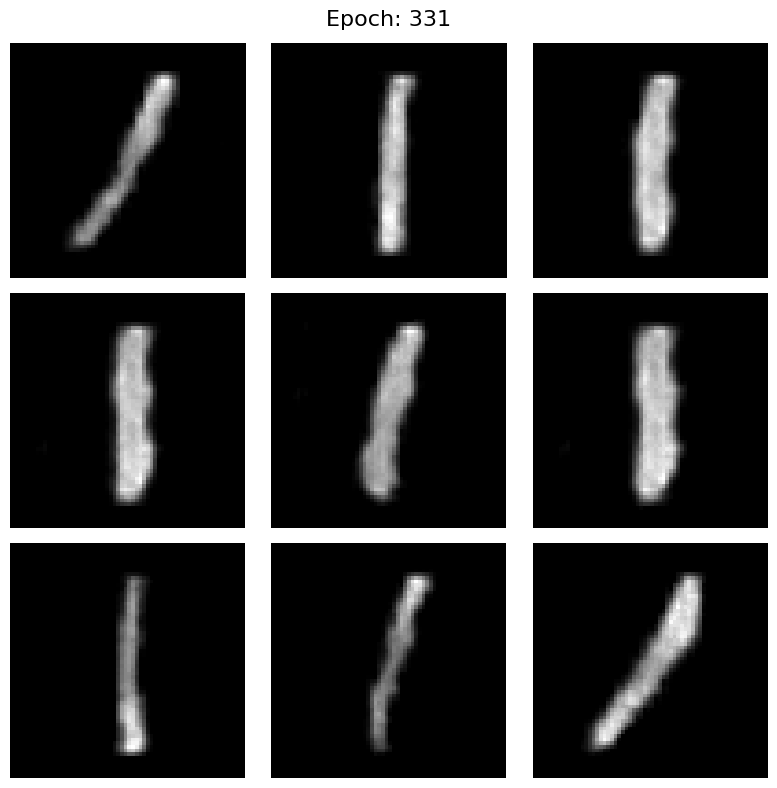

Epoch: 332/1000, d_loss: 0.2772, g_loss: 3.2246, time: 10.9915 sec


Epoch: 333/1000, d_loss: 0.2663, g_loss: 3.8465, time: 10.9693 sec


Epoch: 334/1000, d_loss: 0.2542, g_loss: 3.3894, time: 10.9610 sec


Epoch: 335/1000, d_loss: 0.2658, g_loss: 3.1420, time: 10.9621 sec


Epoch: 336/1000, d_loss: 0.2503, g_loss: 3.0505, time: 10.9528 sec


Epoch: 337/1000, d_loss: 0.2547, g_loss: 3.2122, time: 10.9484 sec


Epoch: 338/1000, d_loss: 0.2449, g_loss: 3.1577, time: 10.9495 sec


Epoch: 339/1000, d_loss: 0.2498, g_loss: 3.2768, time: 10.9936 sec


Epoch: 340/1000, d_loss: 0.2477, g_loss: 3.1568, time: 10.9944 sec


Epoch: 341/1000, d_loss: 0.2585, g_loss: 3.4893, time: 10.9482 sec


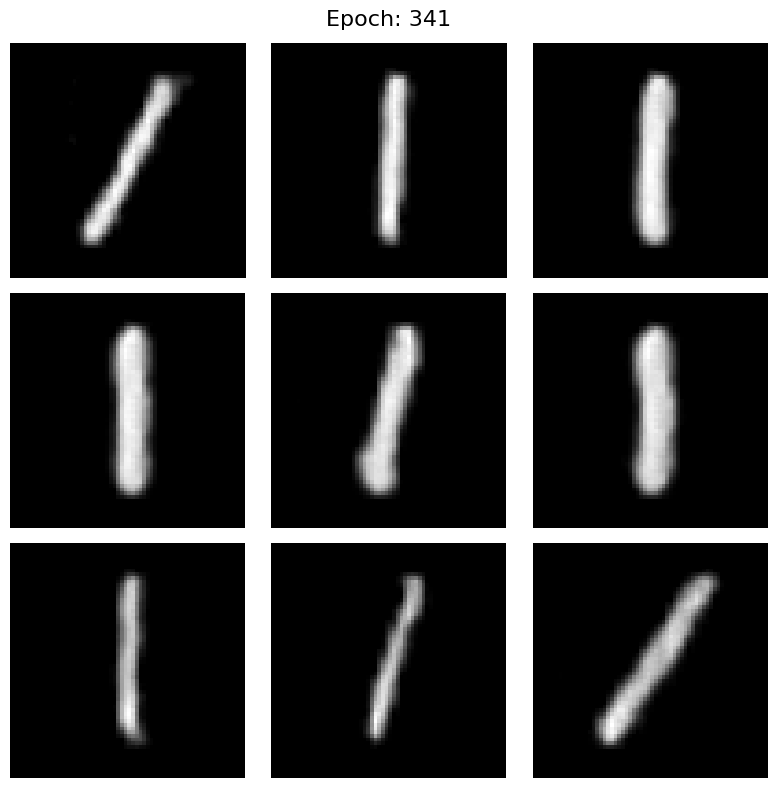

Epoch: 342/1000, d_loss: 0.2560, g_loss: 3.2681, time: 10.9983 sec


Epoch: 343/1000, d_loss: 0.2380, g_loss: 3.3032, time: 10.9730 sec


Epoch: 344/1000, d_loss: 0.2470, g_loss: 3.3382, time: 11.0003 sec


Epoch: 345/1000, d_loss: 0.1715, g_loss: 3.3184, time: 10.9523 sec


Epoch: 346/1000, d_loss: 0.2518, g_loss: 3.5051, time: 11.0524 sec


Epoch: 347/1000, d_loss: 0.1982, g_loss: 3.4865, time: 10.9749 sec


Epoch: 348/1000, d_loss: 0.2578, g_loss: 3.2654, time: 10.9321 sec


Epoch: 349/1000, d_loss: 0.2098, g_loss: 3.3753, time: 10.9309 sec


Epoch: 350/1000, d_loss: 0.3057, g_loss: 3.5749, time: 10.9169 sec


Epoch: 351/1000, d_loss: 0.2738, g_loss: 3.3537, time: 10.9345 sec


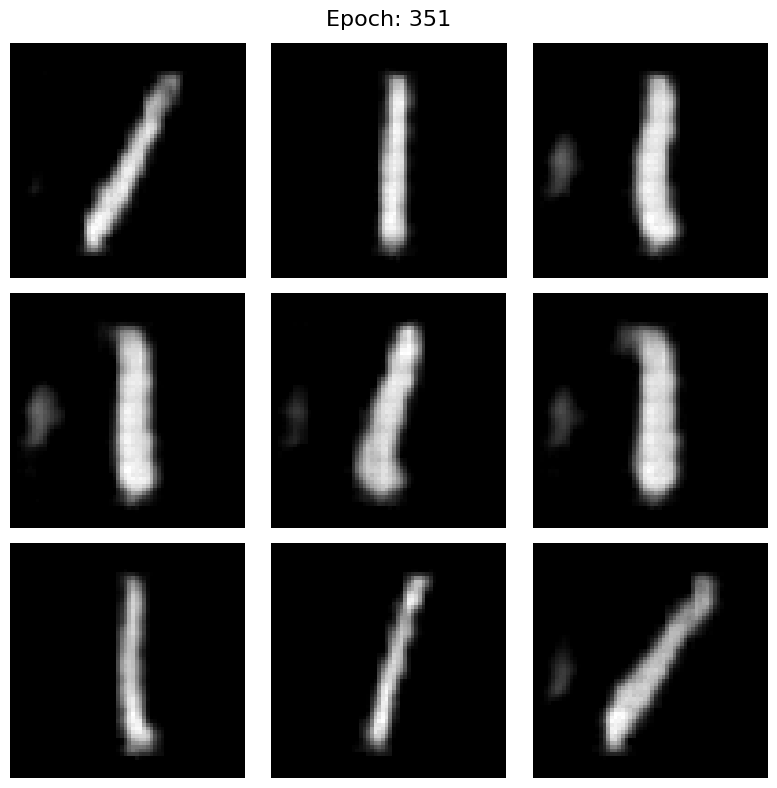

Epoch: 352/1000, d_loss: 0.3705, g_loss: 3.1224, time: 10.9633 sec


Epoch: 353/1000, d_loss: 0.1790, g_loss: 3.1320, time: 10.9715 sec


Epoch: 354/1000, d_loss: 0.1769, g_loss: 3.7049, time: 11.0070 sec


Epoch: 355/1000, d_loss: 0.3665, g_loss: 3.1017, time: 10.9448 sec


Epoch: 356/1000, d_loss: 0.2522, g_loss: 2.9867, time: 11.1873 sec


Epoch: 357/1000, d_loss: 0.2051, g_loss: 3.1799, time: 10.9393 sec


Epoch: 358/1000, d_loss: 0.2587, g_loss: 3.5362, time: 10.9705 sec


Epoch: 359/1000, d_loss: 0.2357, g_loss: 3.1792, time: 10.9582 sec


Epoch: 360/1000, d_loss: 0.2755, g_loss: 3.3421, time: 10.9909 sec


Epoch: 361/1000, d_loss: 0.2465, g_loss: 3.2816, time: 10.9520 sec


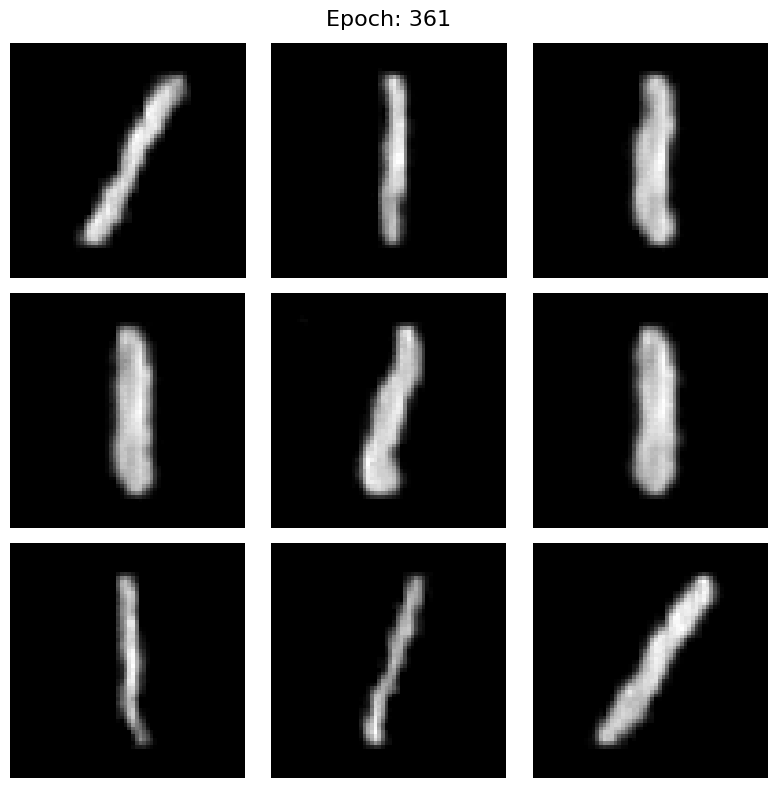

Epoch: 362/1000, d_loss: 0.2549, g_loss: 3.2818, time: 10.9679 sec


Epoch: 363/1000, d_loss: 0.2354, g_loss: 3.3145, time: 10.9543 sec


Epoch: 364/1000, d_loss: 0.2714, g_loss: 3.0891, time: 10.9797 sec


Epoch: 365/1000, d_loss: 0.2722, g_loss: 3.3693, time: 10.9506 sec


Epoch: 366/1000, d_loss: 0.2433, g_loss: 3.2822, time: 10.9839 sec


Epoch: 367/1000, d_loss: 0.2206, g_loss: 3.0916, time: 10.9398 sec


Epoch: 368/1000, d_loss: 0.2703, g_loss: 3.4580, time: 10.9992 sec


Epoch: 369/1000, d_loss: 0.2560, g_loss: 3.2276, time: 10.9782 sec


Epoch: 370/1000, d_loss: 0.2860, g_loss: 3.0907, time: 10.9540 sec


Epoch: 371/1000, d_loss: 0.2684, g_loss: 3.1806, time: 10.9656 sec


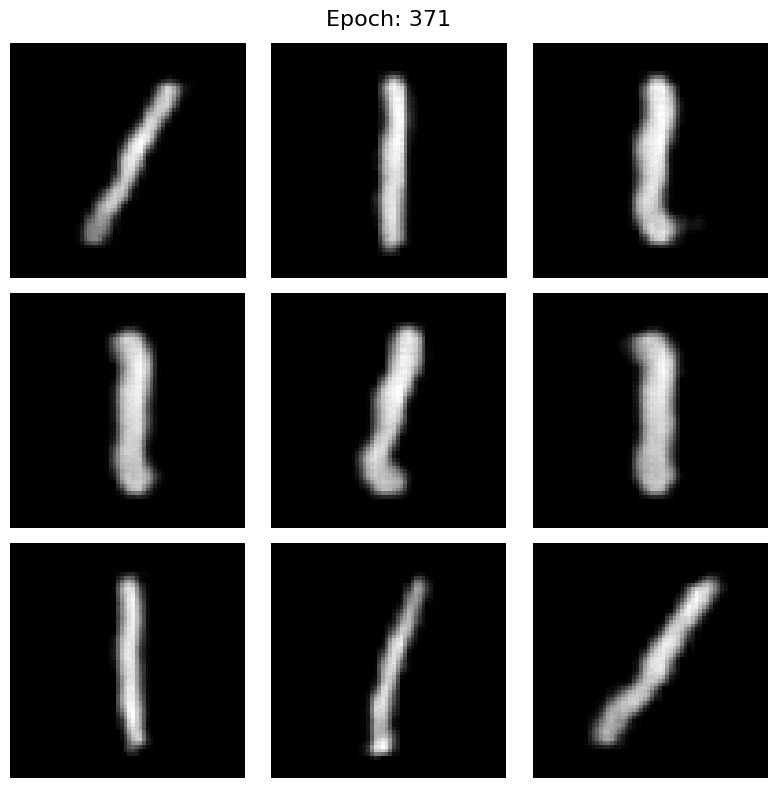

Epoch: 372/1000, d_loss: 0.2601, g_loss: 2.9911, time: 10.9775 sec


Epoch: 373/1000, d_loss: 0.2225, g_loss: 3.2289, time: 10.9804 sec


Epoch: 374/1000, d_loss: 0.2616, g_loss: 3.1345, time: 11.0362 sec


Epoch: 375/1000, d_loss: 0.2285, g_loss: 3.0690, time: 10.9969 sec


Epoch: 376/1000, d_loss: 0.2849, g_loss: 3.1369, time: 11.0020 sec


Epoch: 377/1000, d_loss: 0.2871, g_loss: 3.1455, time: 10.9492 sec


Epoch: 378/1000, d_loss: 0.3074, g_loss: 2.9736, time: 10.9519 sec


Epoch: 379/1000, d_loss: 0.2772, g_loss: 3.0459, time: 10.9915 sec


Epoch: 380/1000, d_loss: 0.2641, g_loss: 3.1499, time: 11.0030 sec


Epoch: 381/1000, d_loss: 0.2529, g_loss: 3.1515, time: 11.0035 sec


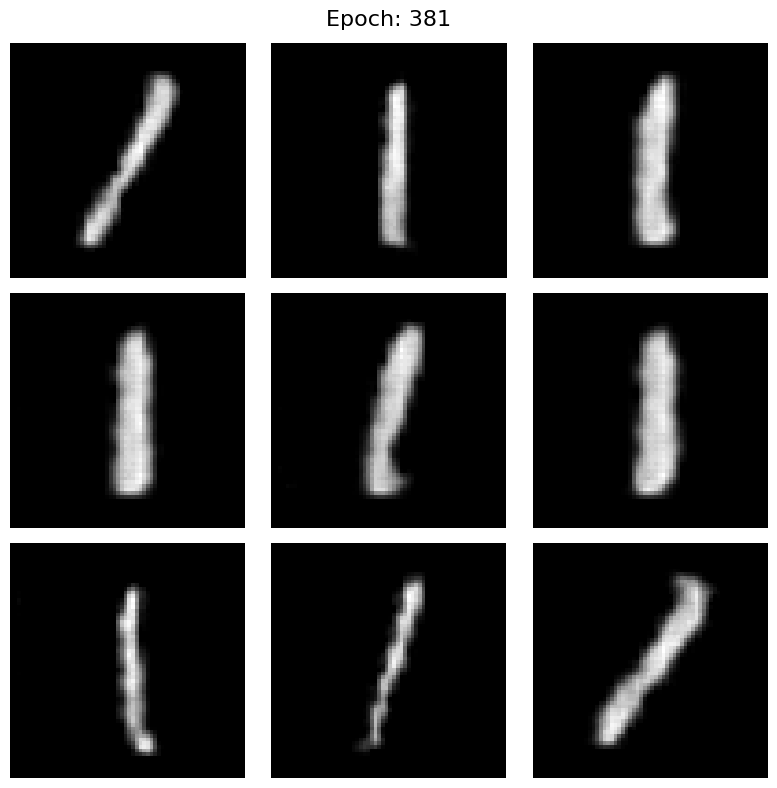

Epoch: 382/1000, d_loss: 0.2966, g_loss: 2.9923, time: 11.0061 sec


Epoch: 383/1000, d_loss: 0.2638, g_loss: 3.0106, time: 10.9590 sec


Epoch: 384/1000, d_loss: 0.2160, g_loss: 3.1748, time: 10.9695 sec


Epoch: 385/1000, d_loss: 0.3323, g_loss: 3.8036, time: 10.9507 sec


Epoch: 386/1000, d_loss: 0.3001, g_loss: 3.1414, time: 10.9774 sec


Epoch: 387/1000, d_loss: 0.3101, g_loss: 2.8737, time: 10.9739 sec


Epoch: 388/1000, d_loss: 0.2983, g_loss: 2.8846, time: 10.9516 sec


Epoch: 389/1000, d_loss: 0.2730, g_loss: 2.7828, time: 10.9922 sec


Epoch: 390/1000, d_loss: 0.2603, g_loss: 2.9100, time: 10.9990 sec


Epoch: 391/1000, d_loss: 0.2597, g_loss: 2.9584, time: 11.0010 sec


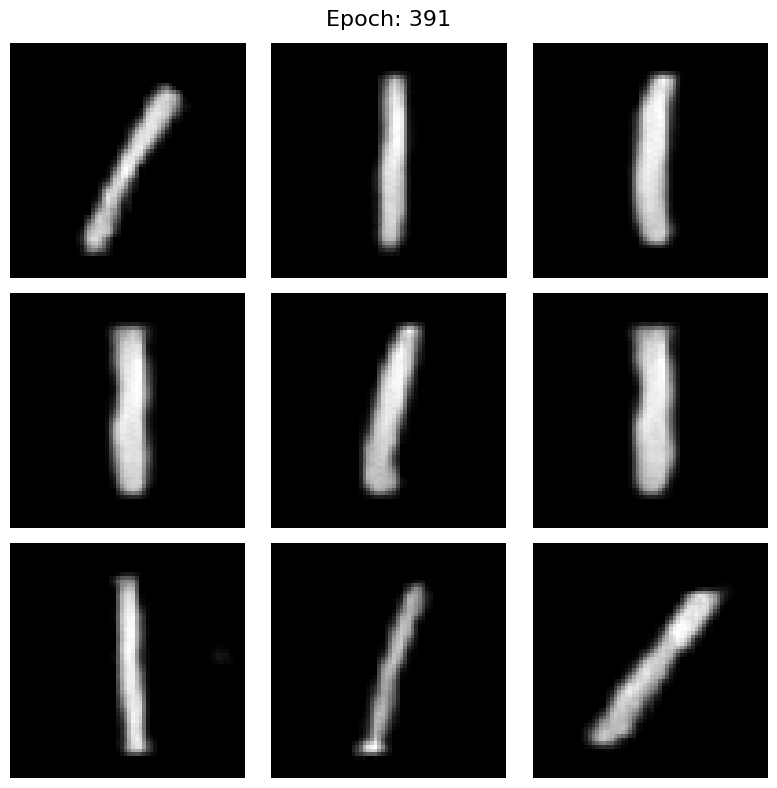

Epoch: 392/1000, d_loss: 0.2613, g_loss: 3.0320, time: 11.0307 sec


Epoch: 393/1000, d_loss: 0.2531, g_loss: 3.1621, time: 10.9877 sec


Epoch: 394/1000, d_loss: 0.2849, g_loss: 3.0815, time: 10.9957 sec


Epoch: 395/1000, d_loss: 0.2936, g_loss: 3.1143, time: 10.9506 sec


Epoch: 396/1000, d_loss: 0.2778, g_loss: 2.9633, time: 10.9429 sec


Epoch: 397/1000, d_loss: 0.2726, g_loss: 3.0011, time: 11.0601 sec


Epoch: 398/1000, d_loss: 0.2583, g_loss: 3.0985, time: 11.0194 sec


Epoch: 399/1000, d_loss: 0.2983, g_loss: 3.1793, time: 10.9688 sec


Epoch: 400/1000, d_loss: 0.2288, g_loss: 3.0443, time: 10.9486 sec


Epoch: 401/1000, d_loss: 0.2767, g_loss: 3.2068, time: 11.0018 sec


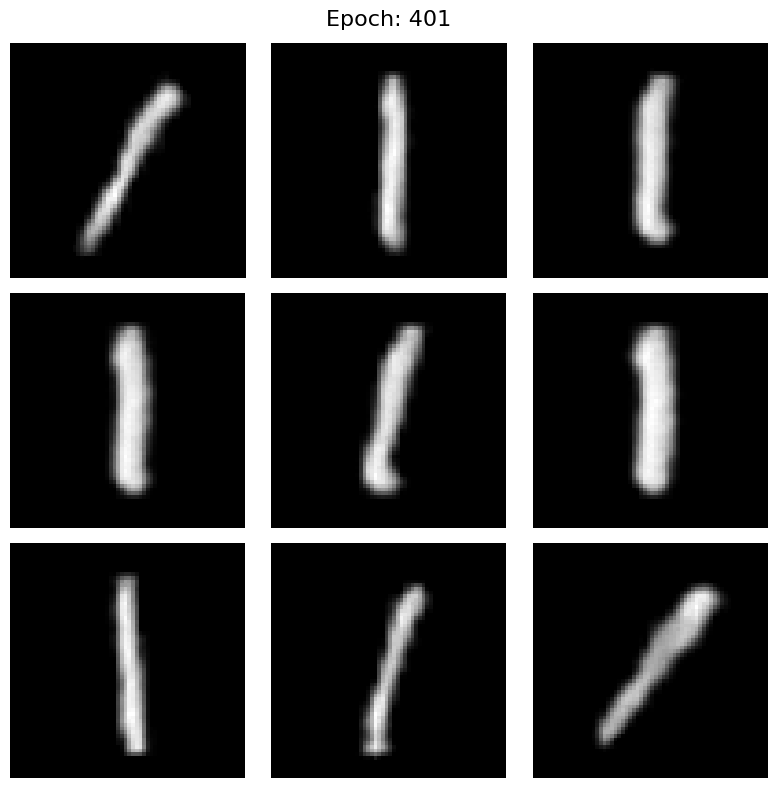

Epoch: 402/1000, d_loss: 0.2468, g_loss: 3.1405, time: 10.9610 sec


Epoch: 403/1000, d_loss: 0.2677, g_loss: 3.0708, time: 10.9514 sec


Epoch: 404/1000, d_loss: 0.2623, g_loss: 3.1162, time: 10.9781 sec


Epoch: 405/1000, d_loss: 0.2876, g_loss: 3.2121, time: 10.9592 sec


Epoch: 406/1000, d_loss: 0.2966, g_loss: 3.0675, time: 10.9739 sec


Epoch: 407/1000, d_loss: 0.2904, g_loss: 2.8742, time: 10.9711 sec


Epoch: 408/1000, d_loss: 0.2739, g_loss: 2.9796, time: 10.9230 sec


Epoch: 409/1000, d_loss: 0.2506, g_loss: 3.0606, time: 10.9497 sec


Epoch: 410/1000, d_loss: 0.2711, g_loss: 3.0905, time: 11.0076 sec


Epoch: 411/1000, d_loss: 0.2403, g_loss: 3.0679, time: 10.9406 sec


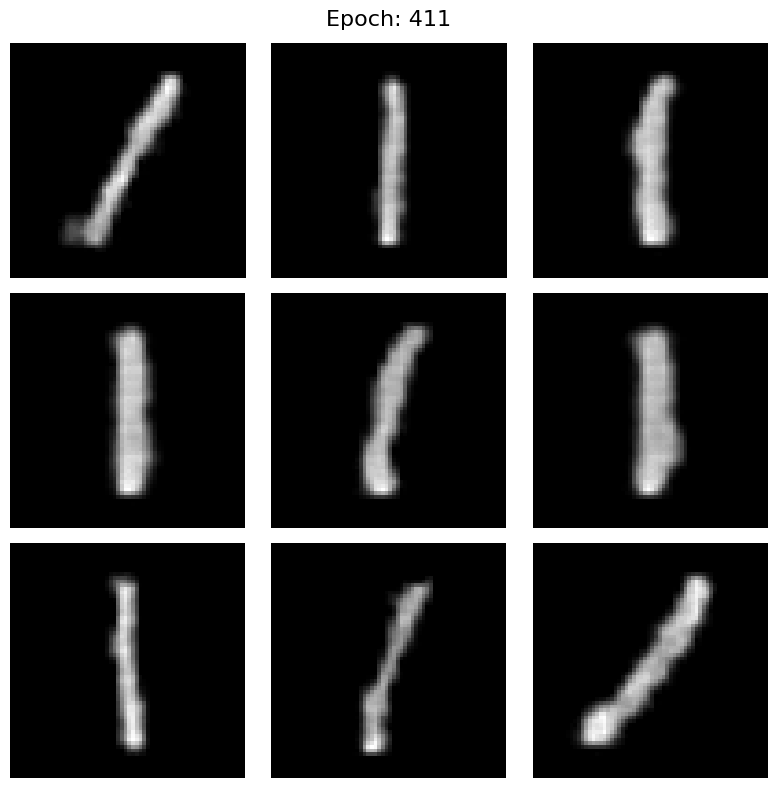

Epoch: 412/1000, d_loss: 0.2535, g_loss: 3.2804, time: 10.9445 sec


Epoch: 413/1000, d_loss: 0.2622, g_loss: 3.0082, time: 10.9643 sec


Epoch: 414/1000, d_loss: 0.2410, g_loss: 3.1505, time: 10.9590 sec


Epoch: 415/1000, d_loss: 0.3037, g_loss: 3.2239, time: 10.9621 sec


Epoch: 416/1000, d_loss: 0.3024, g_loss: 3.2434, time: 10.9440 sec


Epoch: 417/1000, d_loss: 0.2766, g_loss: 2.9351, time: 10.9450 sec


Epoch: 418/1000, d_loss: 0.2123, g_loss: 3.2475, time: 10.9328 sec


Epoch: 419/1000, d_loss: 0.2480, g_loss: 3.1513, time: 11.0293 sec


Epoch: 420/1000, d_loss: 0.2756, g_loss: 3.0667, time: 10.9785 sec


Epoch: 421/1000, d_loss: 0.2626, g_loss: 3.1984, time: 10.9505 sec


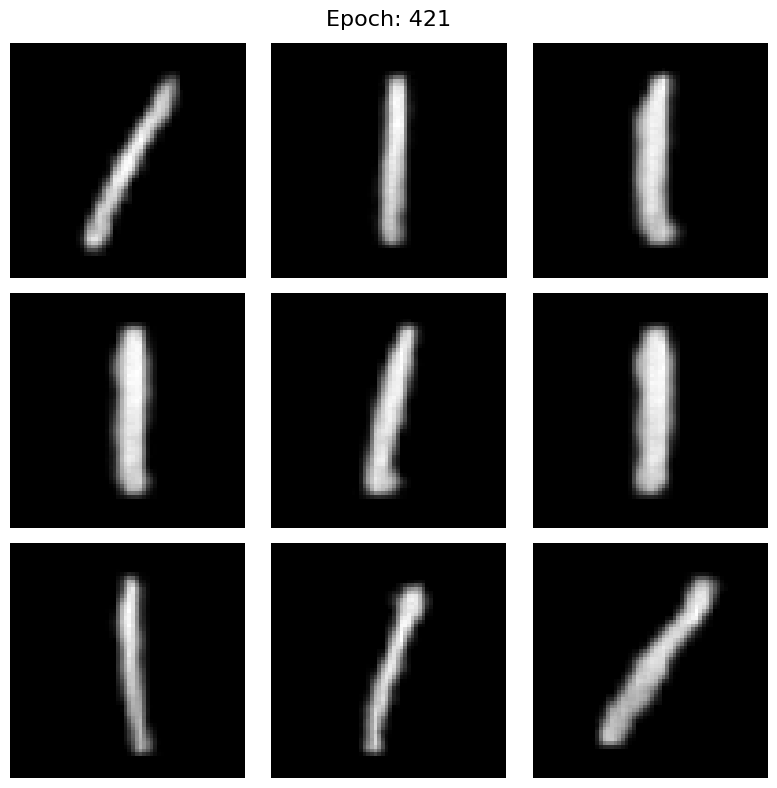

Epoch: 422/1000, d_loss: 0.2431, g_loss: 3.2231, time: 10.9703 sec


Epoch: 423/1000, d_loss: 0.2420, g_loss: 3.1920, time: 10.9823 sec


Epoch: 424/1000, d_loss: 0.3063, g_loss: 3.2208, time: 10.9982 sec


Epoch: 425/1000, d_loss: 0.2451, g_loss: 3.1657, time: 10.9971 sec


Epoch: 426/1000, d_loss: 0.2627, g_loss: 3.1486, time: 10.9394 sec


Epoch: 427/1000, d_loss: 0.2757, g_loss: 3.1258, time: 11.0240 sec


Epoch: 428/1000, d_loss: 0.2395, g_loss: 3.0902, time: 11.0069 sec


Epoch: 429/1000, d_loss: 0.2334, g_loss: 3.1257, time: 10.9858 sec


Epoch: 430/1000, d_loss: 0.3301, g_loss: 3.4341, time: 11.0268 sec


Epoch: 431/1000, d_loss: 0.2816, g_loss: 3.0883, time: 11.0445 sec


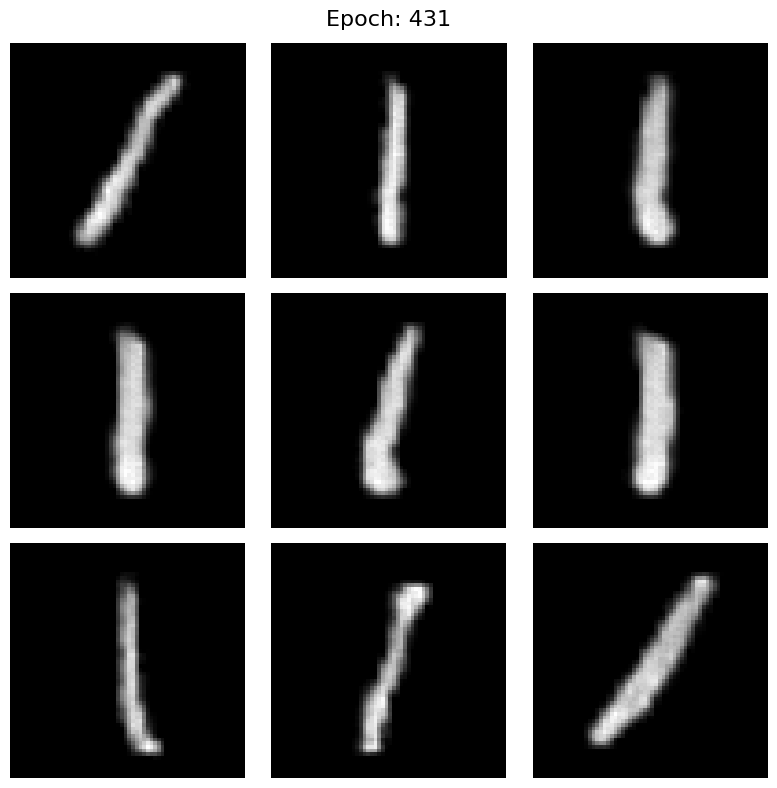

Epoch: 432/1000, d_loss: 0.2621, g_loss: 3.0736, time: 10.9531 sec


Epoch: 433/1000, d_loss: 0.2248, g_loss: 3.2205, time: 10.9880 sec


Epoch: 434/1000, d_loss: 0.2858, g_loss: 3.1042, time: 11.0177 sec


Epoch: 435/1000, d_loss: 0.2577, g_loss: 3.2425, time: 10.9589 sec


Epoch: 436/1000, d_loss: 0.2435, g_loss: 3.0073, time: 10.9692 sec


Epoch: 437/1000, d_loss: 0.3343, g_loss: 3.6471, time: 10.9938 sec


Epoch: 438/1000, d_loss: 0.3079, g_loss: 3.2483, time: 10.9780 sec


Epoch: 439/1000, d_loss: 0.2242, g_loss: 3.0992, time: 10.9963 sec


Epoch: 440/1000, d_loss: 0.2123, g_loss: 3.3262, time: 11.0260 sec


Epoch: 441/1000, d_loss: 0.2551, g_loss: 3.3099, time: 10.9613 sec


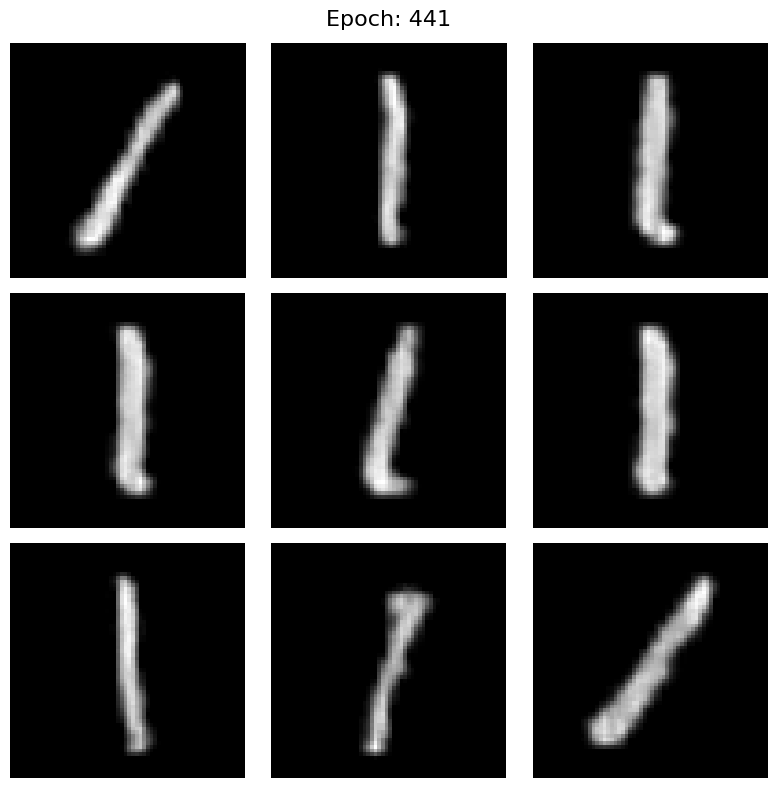

Epoch: 442/1000, d_loss: 0.2468, g_loss: 3.1116, time: 10.9791 sec


Epoch: 443/1000, d_loss: 0.3156, g_loss: 3.1462, time: 10.9907 sec


Epoch: 444/1000, d_loss: 0.2608, g_loss: 3.3629, time: 10.9481 sec


Epoch: 445/1000, d_loss: 0.3105, g_loss: 3.2507, time: 10.9555 sec


Epoch: 446/1000, d_loss: 0.2461, g_loss: 3.0154, time: 10.9576 sec


Epoch: 447/1000, d_loss: 0.2534, g_loss: 3.0474, time: 10.9806 sec


Epoch: 448/1000, d_loss: 0.2709, g_loss: 3.1916, time: 10.9830 sec


Epoch: 449/1000, d_loss: 0.2853, g_loss: 3.3068, time: 10.9817 sec


Epoch: 450/1000, d_loss: 0.2790, g_loss: 3.0875, time: 10.9759 sec


Epoch: 451/1000, d_loss: 0.2490, g_loss: 2.9961, time: 10.9638 sec


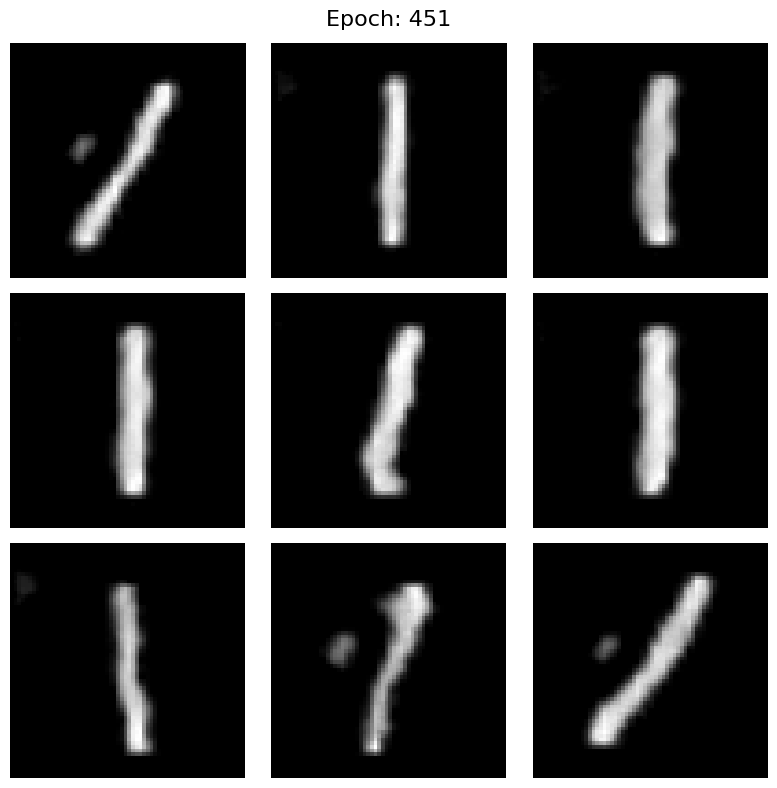

Epoch: 452/1000, d_loss: 0.2730, g_loss: 3.0444, time: 11.0008 sec


Epoch: 453/1000, d_loss: 0.2766, g_loss: 3.0138, time: 10.9440 sec


Epoch: 454/1000, d_loss: 0.2733, g_loss: 3.2082, time: 10.9290 sec


Epoch: 455/1000, d_loss: 0.2588, g_loss: 3.0163, time: 10.9407 sec


Epoch: 456/1000, d_loss: 0.2487, g_loss: 3.1873, time: 10.9518 sec


Epoch: 457/1000, d_loss: 0.3629, g_loss: 3.5961, time: 11.0102 sec


Epoch: 458/1000, d_loss: 0.2876, g_loss: 3.0489, time: 10.9407 sec


Epoch: 459/1000, d_loss: 0.2424, g_loss: 3.1120, time: 10.9342 sec


Epoch: 460/1000, d_loss: 0.2984, g_loss: 3.2009, time: 11.0130 sec


Epoch: 461/1000, d_loss: 0.2744, g_loss: 2.9074, time: 10.9645 sec


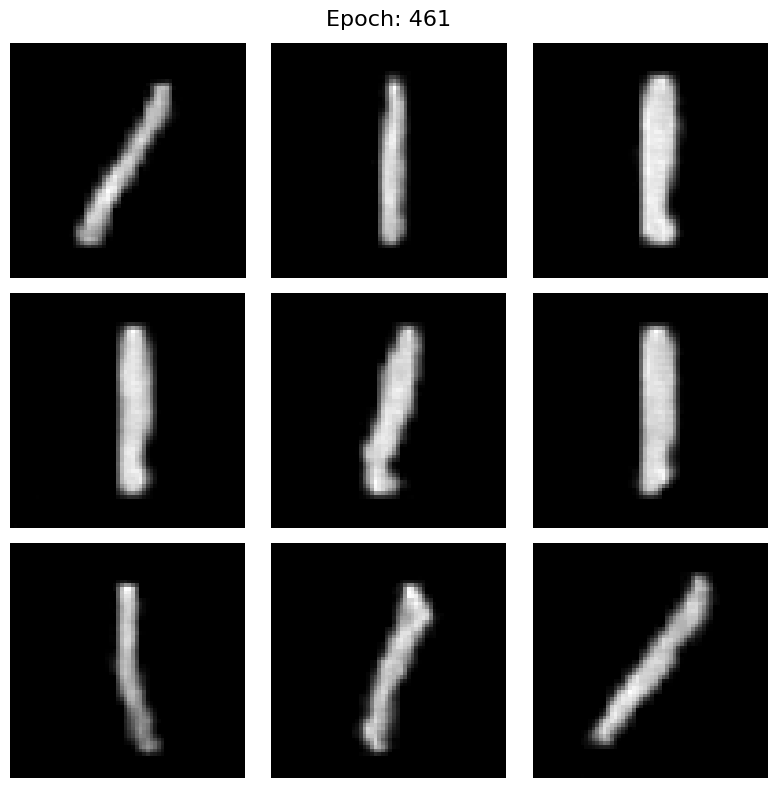

Epoch: 462/1000, d_loss: 0.2686, g_loss: 3.0428, time: 10.9775 sec


Epoch: 463/1000, d_loss: 0.2740, g_loss: 3.3344, time: 10.9995 sec


Epoch: 464/1000, d_loss: 0.2818, g_loss: 2.9332, time: 10.9832 sec


Epoch: 465/1000, d_loss: 0.2741, g_loss: 3.0870, time: 10.9718 sec


Epoch: 466/1000, d_loss: 0.3215, g_loss: 3.3714, time: 10.9505 sec


Epoch: 467/1000, d_loss: 0.2859, g_loss: 2.8787, time: 10.9307 sec


Epoch: 468/1000, d_loss: 0.2688, g_loss: 3.0587, time: 10.9843 sec


Epoch: 469/1000, d_loss: 0.2871, g_loss: 3.0273, time: 11.0142 sec


Epoch: 470/1000, d_loss: 0.2702, g_loss: 2.9124, time: 10.9474 sec


Epoch: 471/1000, d_loss: 0.2932, g_loss: 2.9871, time: 10.9579 sec


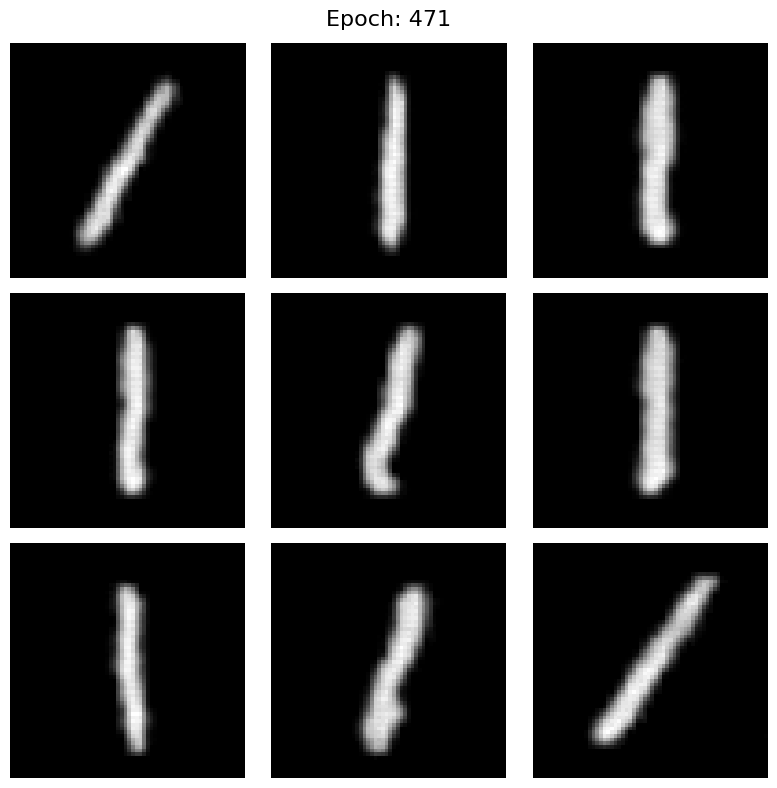

Epoch: 472/1000, d_loss: 0.2803, g_loss: 3.0280, time: 10.9937 sec


Epoch: 473/1000, d_loss: 0.2737, g_loss: 2.9645, time: 10.9614 sec


Epoch: 474/1000, d_loss: 0.2961, g_loss: 3.0144, time: 10.9518 sec


Epoch: 475/1000, d_loss: 0.2670, g_loss: 3.0326, time: 11.0489 sec


Epoch: 476/1000, d_loss: 0.2830, g_loss: 3.0519, time: 10.9518 sec


Epoch: 477/1000, d_loss: 0.2731, g_loss: 3.1079, time: 11.0021 sec


Epoch: 478/1000, d_loss: 0.2786, g_loss: 3.0930, time: 10.9497 sec


Epoch: 479/1000, d_loss: 0.2817, g_loss: 2.8994, time: 10.9659 sec


Epoch: 480/1000, d_loss: 0.3040, g_loss: 3.0001, time: 10.9580 sec


Epoch: 481/1000, d_loss: 0.2765, g_loss: 3.0065, time: 10.9522 sec


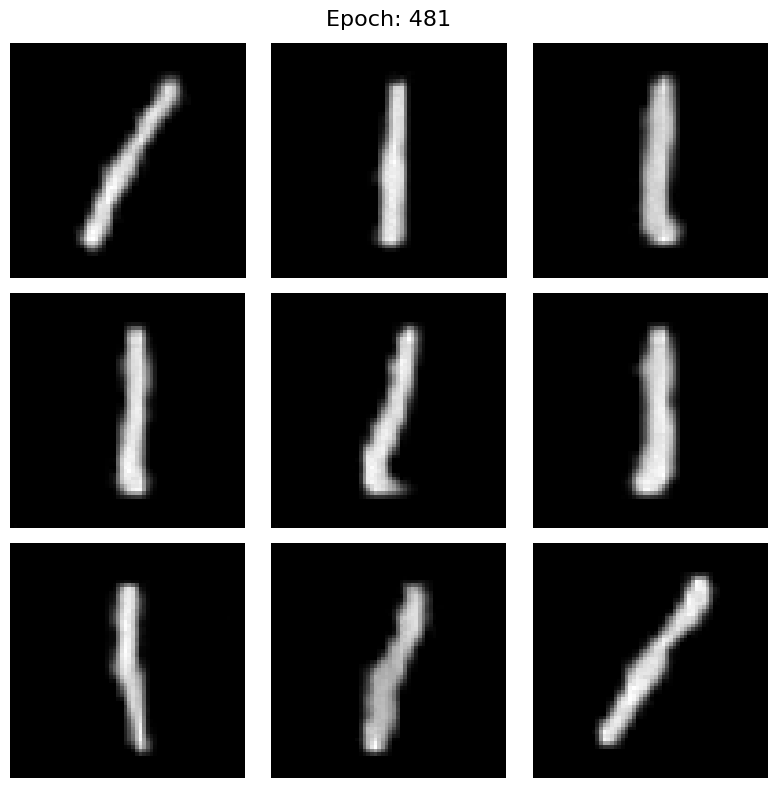

Epoch: 482/1000, d_loss: 0.2939, g_loss: 2.8658, time: 10.9553 sec


Epoch: 483/1000, d_loss: 0.3034, g_loss: 3.1491, time: 10.9462 sec


Epoch: 484/1000, d_loss: 0.2637, g_loss: 3.0602, time: 10.9561 sec


Epoch: 485/1000, d_loss: 0.2929, g_loss: 2.9486, time: 10.9560 sec


Epoch: 486/1000, d_loss: 0.2715, g_loss: 3.3247, time: 10.9314 sec


Epoch: 487/1000, d_loss: 0.4324, g_loss: 3.7312, time: 10.9533 sec


Epoch: 488/1000, d_loss: 0.3063, g_loss: 2.7137, time: 10.9485 sec


Epoch: 489/1000, d_loss: 0.2927, g_loss: 2.8143, time: 10.9862 sec


Epoch: 490/1000, d_loss: 0.2549, g_loss: 2.8763, time: 10.9288 sec


Epoch: 491/1000, d_loss: 0.2882, g_loss: 2.8710, time: 10.9799 sec


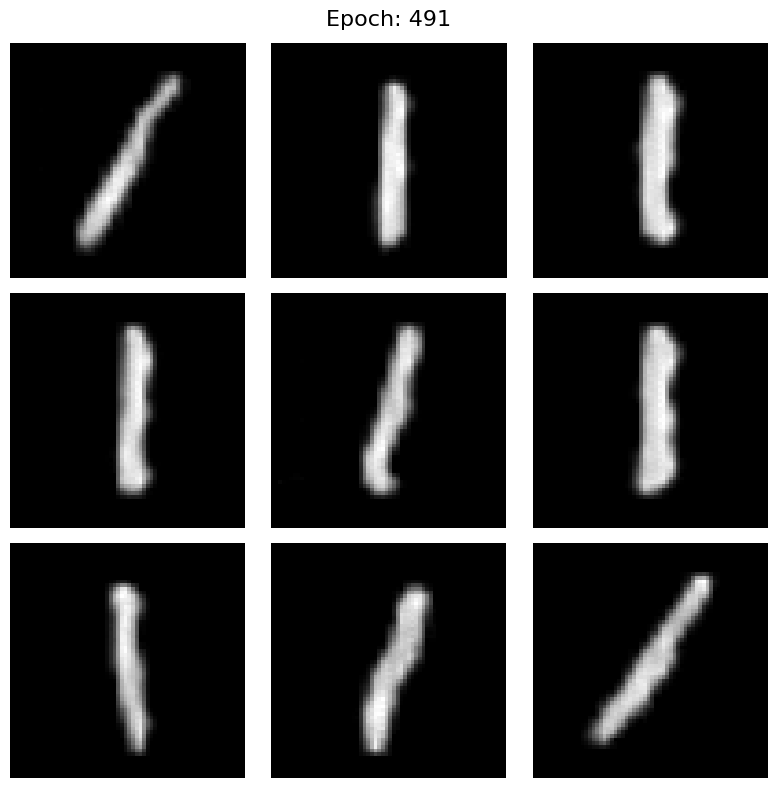

Epoch: 492/1000, d_loss: 0.2909, g_loss: 3.2371, time: 10.9827 sec


Epoch: 493/1000, d_loss: 0.3156, g_loss: 3.3423, time: 10.9557 sec


Epoch: 494/1000, d_loss: 0.2821, g_loss: 2.8752, time: 10.9938 sec


Epoch: 495/1000, d_loss: 0.2880, g_loss: 3.0570, time: 10.9585 sec


Epoch: 496/1000, d_loss: 0.2692, g_loss: 3.0574, time: 11.0345 sec


Epoch: 497/1000, d_loss: 0.3025, g_loss: 3.0491, time: 11.0742 sec


Epoch: 498/1000, d_loss: 0.3012, g_loss: 2.9962, time: 10.9917 sec


Epoch: 499/1000, d_loss: 0.2709, g_loss: 2.9965, time: 10.9459 sec


Epoch: 500/1000, d_loss: 0.2908, g_loss: 2.9879, time: 10.9471 sec


Epoch: 501/1000, d_loss: 0.2801, g_loss: 3.0219, time: 10.9509 sec


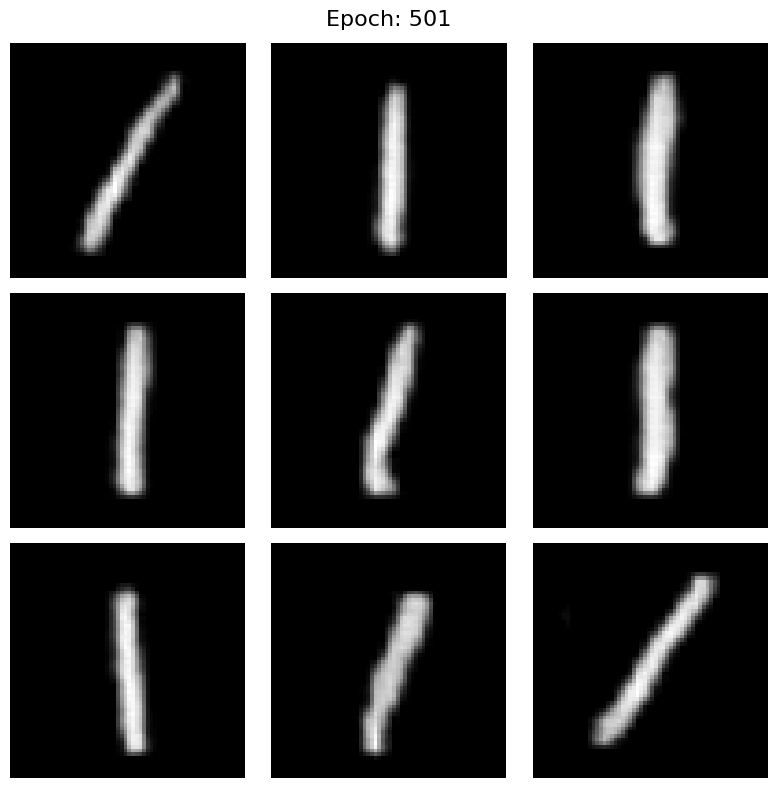

Epoch: 502/1000, d_loss: 0.2866, g_loss: 3.2215, time: 11.0006 sec


Epoch: 503/1000, d_loss: 0.2959, g_loss: 2.9369, time: 10.9553 sec


Epoch: 504/1000, d_loss: 0.3099, g_loss: 3.2000, time: 10.9991 sec


Epoch: 505/1000, d_loss: 0.2916, g_loss: 2.8633, time: 10.9708 sec


Epoch: 506/1000, d_loss: 0.2422, g_loss: 3.0417, time: 11.0524 sec


Epoch: 507/1000, d_loss: 0.3128, g_loss: 2.9987, time: 10.9673 sec


Epoch: 508/1000, d_loss: 0.2875, g_loss: 2.8611, time: 10.9493 sec


Epoch: 509/1000, d_loss: 0.2516, g_loss: 2.9421, time: 10.9983 sec


Epoch: 510/1000, d_loss: 0.3438, g_loss: 3.2265, time: 10.9706 sec


Epoch: 511/1000, d_loss: 0.2575, g_loss: 3.0267, time: 11.2157 sec


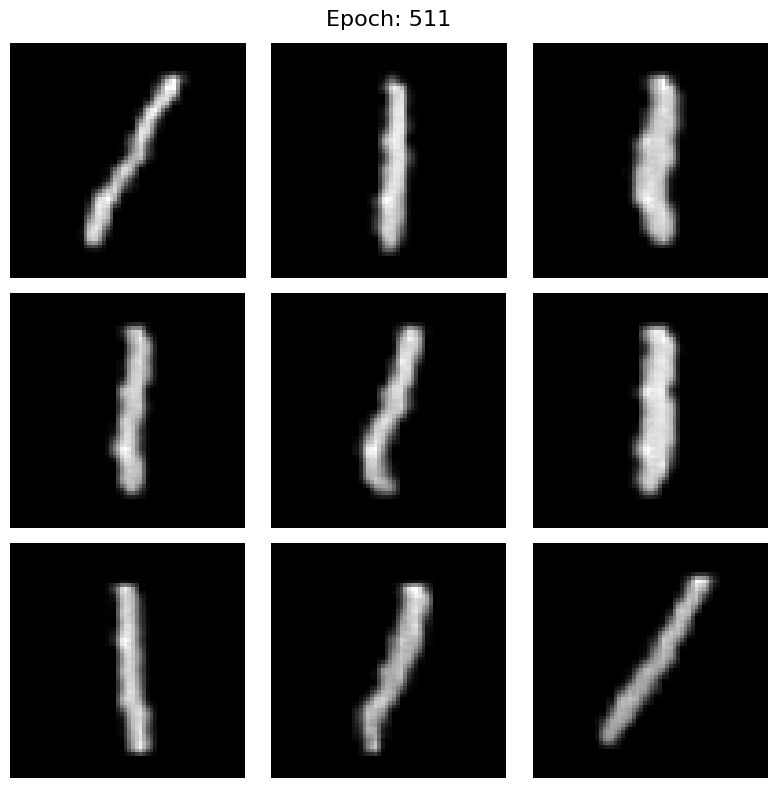

Epoch: 512/1000, d_loss: 0.2590, g_loss: 2.9274, time: 10.9898 sec


Epoch: 513/1000, d_loss: 0.2768, g_loss: 3.1375, time: 10.9558 sec


Epoch: 514/1000, d_loss: 0.2771, g_loss: 3.1702, time: 11.0030 sec


Epoch: 515/1000, d_loss: 0.3293, g_loss: 2.9427, time: 11.0635 sec


Epoch: 516/1000, d_loss: 0.2359, g_loss: 3.1475, time: 10.9772 sec


Epoch: 517/1000, d_loss: 0.3493, g_loss: 3.2594, time: 11.0249 sec


Epoch: 518/1000, d_loss: 0.2752, g_loss: 2.9914, time: 10.9428 sec


Epoch: 519/1000, d_loss: 0.2617, g_loss: 2.9006, time: 11.0102 sec


Epoch: 520/1000, d_loss: 0.2612, g_loss: 3.1349, time: 10.9747 sec


Epoch: 521/1000, d_loss: 0.2615, g_loss: 3.0988, time: 10.9670 sec


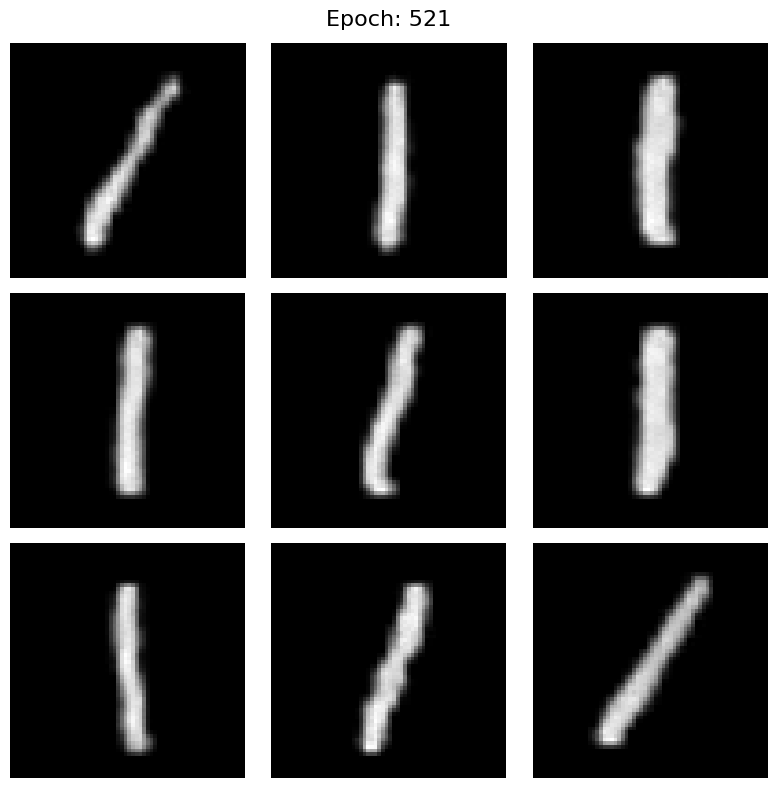

Epoch: 522/1000, d_loss: 0.3059, g_loss: 2.8832, time: 10.9746 sec


Epoch: 523/1000, d_loss: 0.2525, g_loss: 3.1348, time: 10.9938 sec


Epoch: 524/1000, d_loss: 0.2645, g_loss: 3.2904, time: 10.9984 sec


Epoch: 525/1000, d_loss: 0.2745, g_loss: 2.8857, time: 10.9921 sec


Epoch: 526/1000, d_loss: 0.2915, g_loss: 3.2616, time: 10.9873 sec


Epoch: 527/1000, d_loss: 0.2815, g_loss: 3.0112, time: 10.9871 sec


Epoch: 528/1000, d_loss: 0.2463, g_loss: 3.0452, time: 10.9521 sec


Epoch: 529/1000, d_loss: 0.2478, g_loss: 2.9697, time: 10.9463 sec


Epoch: 530/1000, d_loss: 0.3247, g_loss: 3.2648, time: 10.9617 sec


Epoch: 531/1000, d_loss: 0.2384, g_loss: 2.9741, time: 10.9931 sec


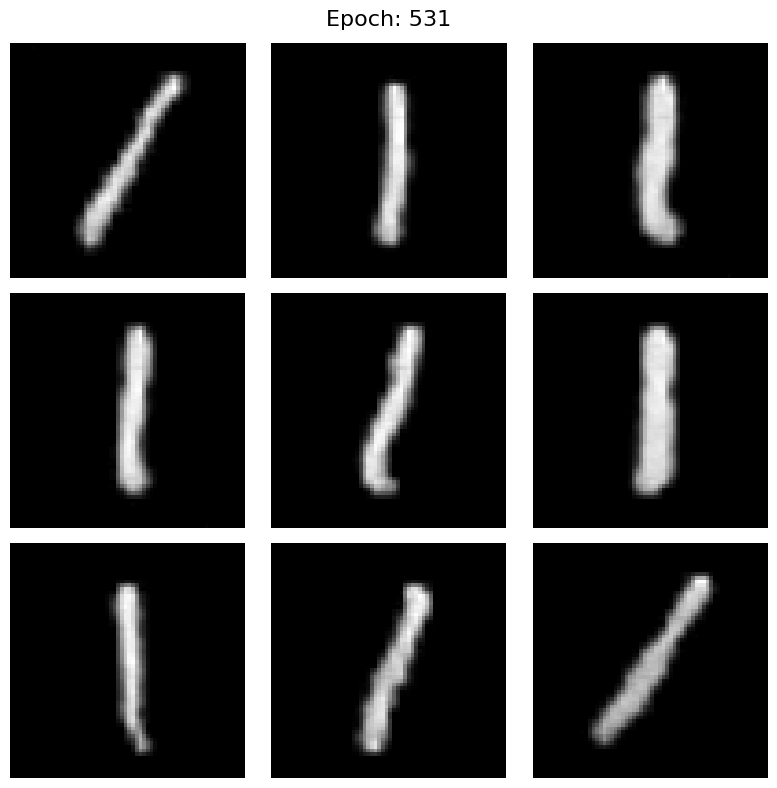

Epoch: 532/1000, d_loss: 0.3273, g_loss: 3.2317, time: 10.9762 sec


Epoch: 533/1000, d_loss: 0.2917, g_loss: 2.9727, time: 10.9760 sec


Epoch: 534/1000, d_loss: 0.2477, g_loss: 3.0891, time: 10.9726 sec


Epoch: 535/1000, d_loss: 0.2845, g_loss: 3.1581, time: 10.9599 sec


Epoch: 536/1000, d_loss: 0.2787, g_loss: 3.1597, time: 10.9873 sec


Epoch: 537/1000, d_loss: 0.2490, g_loss: 3.3295, time: 10.9516 sec


Epoch: 538/1000, d_loss: 0.2666, g_loss: 3.1387, time: 11.0021 sec


Epoch: 539/1000, d_loss: 0.3031, g_loss: 2.8463, time: 11.0131 sec


Epoch: 540/1000, d_loss: 0.2673, g_loss: 3.2057, time: 11.0132 sec


Epoch: 541/1000, d_loss: 0.2435, g_loss: 3.1793, time: 10.9849 sec


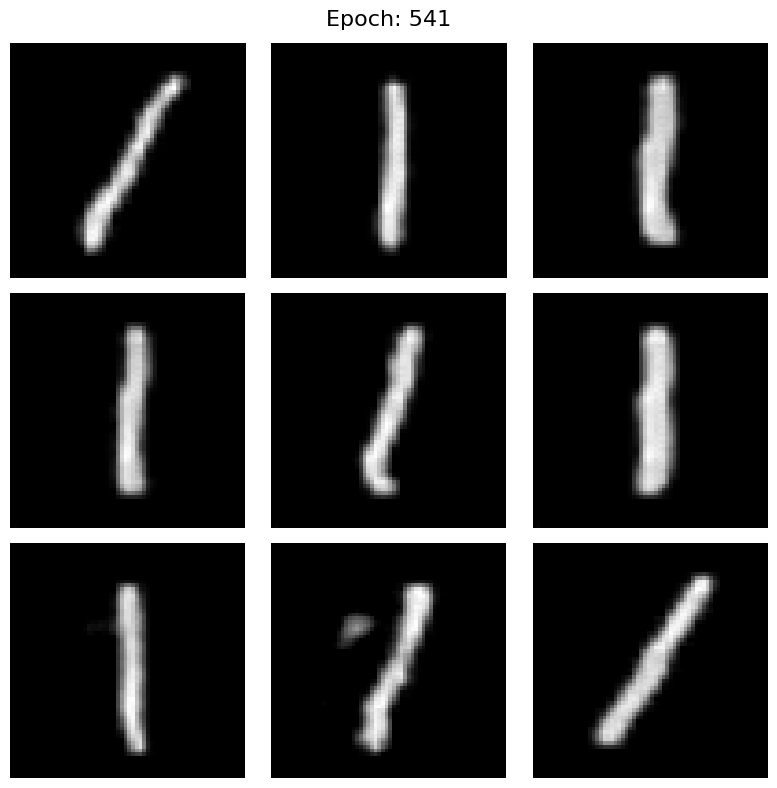

Epoch: 542/1000, d_loss: 0.3221, g_loss: 3.0235, time: 11.0120 sec


Epoch: 543/1000, d_loss: 0.2800, g_loss: 3.2163, time: 10.9709 sec


Epoch: 544/1000, d_loss: 0.3539, g_loss: 3.2780, time: 11.0580 sec


Epoch: 545/1000, d_loss: 0.2758, g_loss: 2.8077, time: 10.9757 sec


Epoch: 546/1000, d_loss: 0.2191, g_loss: 2.9940, time: 10.9473 sec


Epoch: 547/1000, d_loss: 0.3657, g_loss: 3.8288, time: 11.0096 sec


Epoch: 548/1000, d_loss: 0.2834, g_loss: 2.9779, time: 10.9682 sec


Epoch: 549/1000, d_loss: 0.2670, g_loss: 2.7689, time: 10.9957 sec


Epoch: 550/1000, d_loss: 0.2112, g_loss: 3.1659, time: 10.9887 sec


Epoch: 551/1000, d_loss: 0.3954, g_loss: 3.6204, time: 10.9680 sec


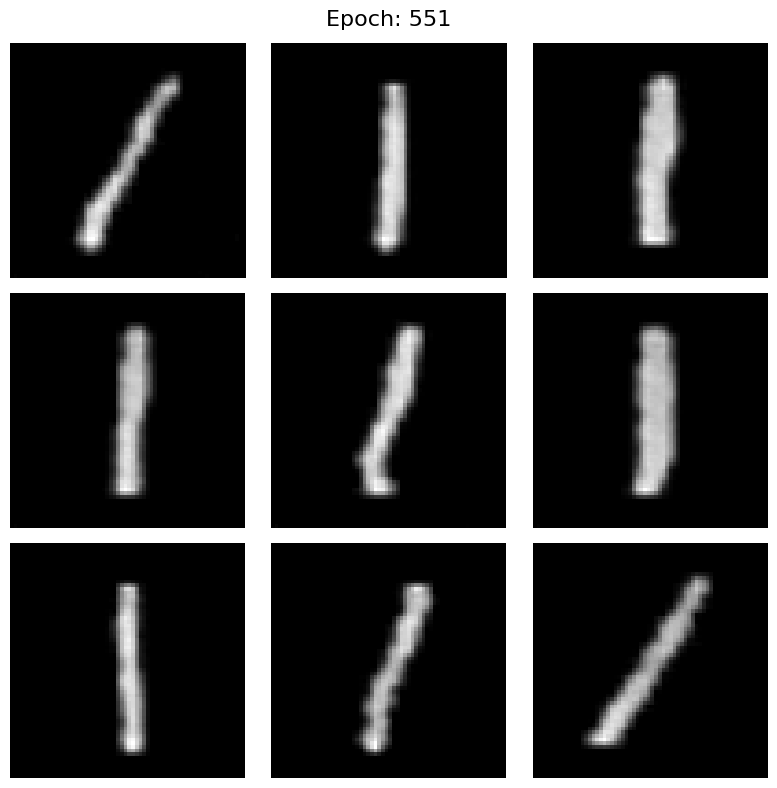

Epoch: 552/1000, d_loss: 0.2590, g_loss: 2.7652, time: 11.0262 sec


Epoch: 553/1000, d_loss: 0.2415, g_loss: 2.9605, time: 11.0015 sec


Epoch: 554/1000, d_loss: 0.2598, g_loss: 3.2324, time: 10.9572 sec


Epoch: 555/1000, d_loss: 0.1820, g_loss: 3.7360, time: 10.9629 sec


Epoch: 556/1000, d_loss: 0.4064, g_loss: 3.9226, time: 11.0380 sec


Epoch: 557/1000, d_loss: 0.2642, g_loss: 3.0541, time: 10.9940 sec


Epoch: 558/1000, d_loss: 0.2519, g_loss: 3.3195, time: 11.0094 sec


Epoch: 559/1000, d_loss: 0.2451, g_loss: 3.0278, time: 10.9656 sec


Epoch: 560/1000, d_loss: 0.2525, g_loss: 3.0317, time: 10.9857 sec


Epoch: 561/1000, d_loss: 0.2869, g_loss: 3.2074, time: 10.9546 sec


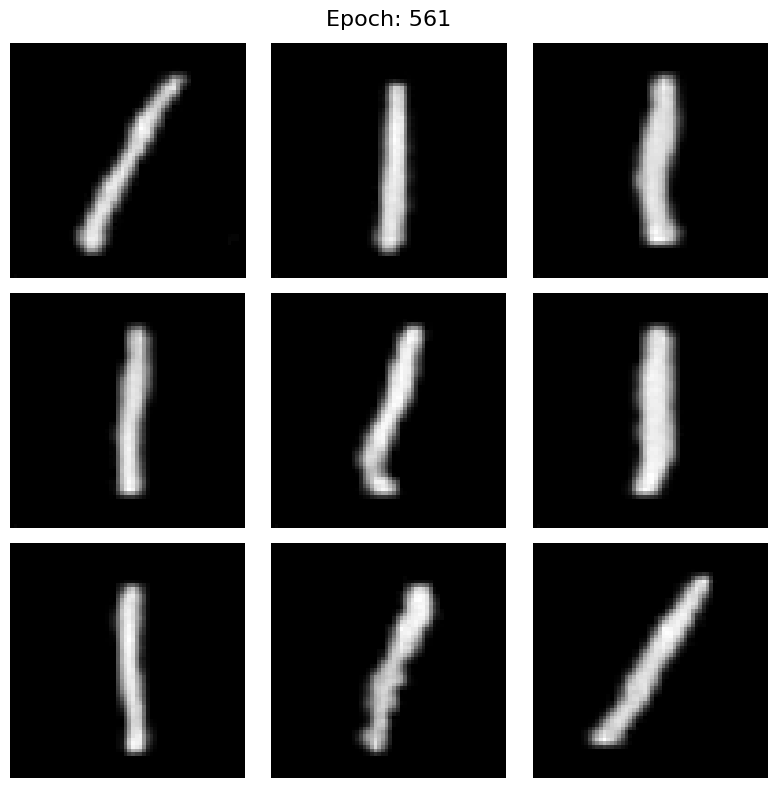

Epoch: 562/1000, d_loss: 0.3046, g_loss: 3.4548, time: 10.9630 sec


Epoch: 563/1000, d_loss: 0.2763, g_loss: 2.7312, time: 10.9409 sec


Epoch: 564/1000, d_loss: 0.2116, g_loss: 3.2488, time: 11.0253 sec


Epoch: 565/1000, d_loss: 0.3291, g_loss: 3.2067, time: 10.9749 sec


Epoch: 566/1000, d_loss: 0.2186, g_loss: 2.9930, time: 10.9677 sec


Epoch: 567/1000, d_loss: 0.2471, g_loss: 3.1489, time: 11.0096 sec


Epoch: 568/1000, d_loss: 0.2887, g_loss: 3.3121, time: 10.9529 sec


Epoch: 569/1000, d_loss: 0.2847, g_loss: 3.2503, time: 10.9785 sec


Epoch: 570/1000, d_loss: 0.1563, g_loss: 3.7566, time: 10.9666 sec


Epoch: 571/1000, d_loss: 0.3209, g_loss: 3.4892, time: 10.9906 sec


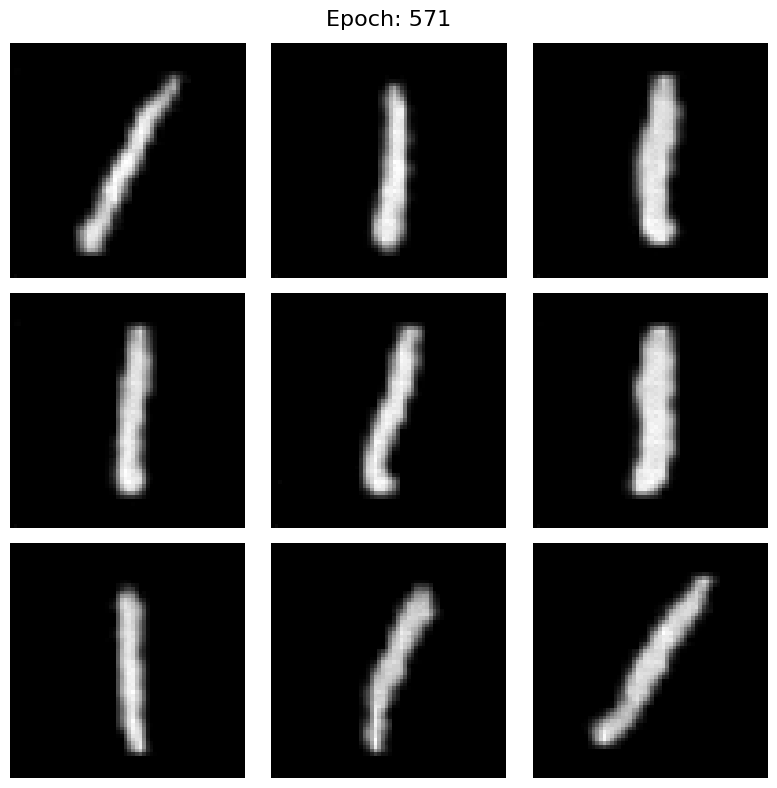

Epoch: 572/1000, d_loss: 0.2607, g_loss: 3.1591, time: 11.0362 sec


Epoch: 573/1000, d_loss: 0.2382, g_loss: 3.4802, time: 10.9847 sec


Epoch: 574/1000, d_loss: 0.2799, g_loss: 3.1588, time: 10.9846 sec


Epoch: 575/1000, d_loss: 0.2731, g_loss: 3.5202, time: 10.9359 sec


Epoch: 576/1000, d_loss: 0.4009, g_loss: 3.4186, time: 10.9298 sec


Epoch: 577/1000, d_loss: 0.2437, g_loss: 2.9899, time: 10.9631 sec


Epoch: 578/1000, d_loss: 0.2233, g_loss: 2.9997, time: 11.0094 sec


Epoch: 579/1000, d_loss: 0.2664, g_loss: 3.2076, time: 11.0462 sec


Epoch: 580/1000, d_loss: 0.2438, g_loss: 3.4090, time: 10.9495 sec


Epoch: 581/1000, d_loss: 0.2914, g_loss: 3.3331, time: 10.9623 sec


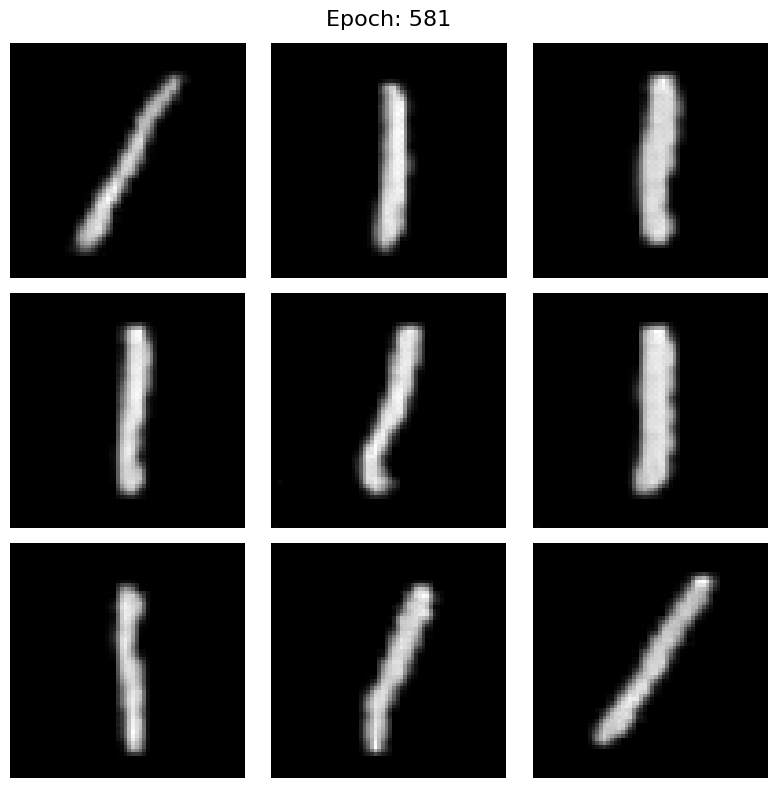

Epoch: 582/1000, d_loss: 0.2485, g_loss: 3.2124, time: 10.9770 sec


Epoch: 583/1000, d_loss: 0.2299, g_loss: 3.2264, time: 10.9475 sec


Epoch: 584/1000, d_loss: 0.2465, g_loss: 3.3185, time: 10.9755 sec


Epoch: 585/1000, d_loss: 0.2266, g_loss: 3.4003, time: 11.0048 sec


Epoch: 586/1000, d_loss: 0.3209, g_loss: 4.4661, time: 11.2640 sec


Epoch: 587/1000, d_loss: 0.4114, g_loss: 3.3866, time: 10.9895 sec


Epoch: 588/1000, d_loss: 0.2297, g_loss: 2.8821, time: 10.9502 sec


Epoch: 589/1000, d_loss: 0.2371, g_loss: 3.7767, time: 10.9782 sec


Epoch: 590/1000, d_loss: 0.3410, g_loss: 3.3066, time: 10.9917 sec


Epoch: 591/1000, d_loss: 0.2418, g_loss: 2.9855, time: 11.0001 sec


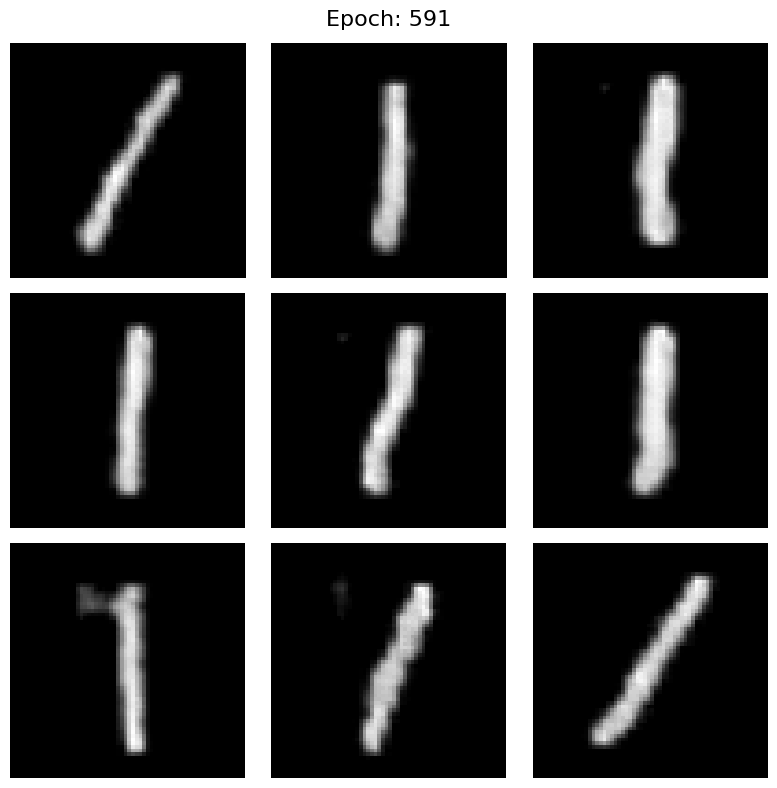

Epoch: 592/1000, d_loss: 0.2301, g_loss: 3.0585, time: 10.9426 sec


Epoch: 593/1000, d_loss: 0.2613, g_loss: 3.5925, time: 10.9938 sec


Epoch: 594/1000, d_loss: 0.3805, g_loss: 3.6883, time: 10.9774 sec


Epoch: 595/1000, d_loss: 0.2459, g_loss: 2.8527, time: 10.9820 sec


Epoch: 596/1000, d_loss: 0.2117, g_loss: 3.1625, time: 10.9312 sec


Epoch: 597/1000, d_loss: 0.2347, g_loss: 3.1506, time: 10.9569 sec


Epoch: 598/1000, d_loss: 0.2353, g_loss: 3.4193, time: 11.0144 sec


Epoch: 599/1000, d_loss: 0.2587, g_loss: 3.2954, time: 10.9539 sec


Epoch: 600/1000, d_loss: 0.2702, g_loss: 3.9872, time: 10.9633 sec


Epoch: 601/1000, d_loss: 0.3212, g_loss: 3.4123, time: 11.0139 sec


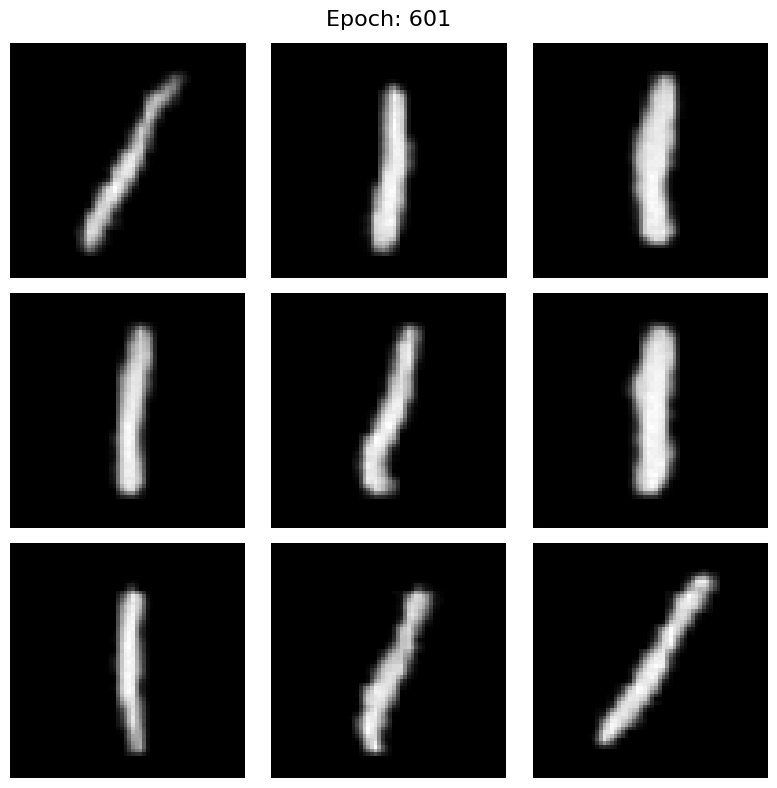

Epoch: 602/1000, d_loss: 0.2142, g_loss: 3.1782, time: 10.9679 sec


Epoch: 603/1000, d_loss: 0.1985, g_loss: 3.4109, time: 10.9938 sec


Epoch: 604/1000, d_loss: 0.2000, g_loss: 3.3942, time: 10.9455 sec


Epoch: 605/1000, d_loss: 0.2992, g_loss: 3.9191, time: 11.0347 sec


Epoch: 606/1000, d_loss: 0.2683, g_loss: 3.4726, time: 10.9580 sec


Epoch: 607/1000, d_loss: 0.2081, g_loss: 3.1458, time: 10.9895 sec


Epoch: 608/1000, d_loss: 0.2239, g_loss: 3.6195, time: 11.0109 sec


Epoch: 609/1000, d_loss: 0.3119, g_loss: 3.6851, time: 10.9637 sec


Epoch: 610/1000, d_loss: 0.2271, g_loss: 3.0754, time: 10.9743 sec


Epoch: 611/1000, d_loss: 0.1905, g_loss: 3.3649, time: 10.9942 sec


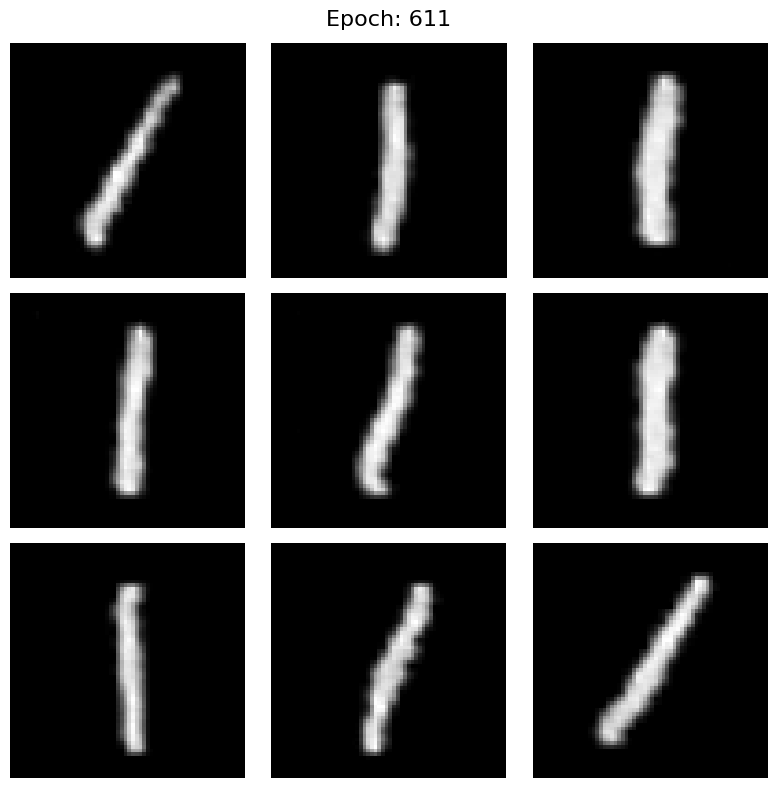

Epoch: 612/1000, d_loss: 0.3229, g_loss: 3.7573, time: 11.0011 sec


Epoch: 613/1000, d_loss: 0.2163, g_loss: 3.2181, time: 10.9775 sec


Epoch: 614/1000, d_loss: 0.1979, g_loss: 3.4499, time: 10.9599 sec


Epoch: 615/1000, d_loss: 0.2488, g_loss: 3.7593, time: 11.0267 sec


Epoch: 616/1000, d_loss: 0.4094, g_loss: 4.2656, time: 11.0514 sec


Epoch: 617/1000, d_loss: 0.2172, g_loss: 3.1281, time: 10.9360 sec


Epoch: 618/1000, d_loss: 0.2466, g_loss: 3.6600, time: 10.9792 sec


Epoch: 619/1000, d_loss: 0.3389, g_loss: 3.5311, time: 10.9676 sec


Epoch: 620/1000, d_loss: 0.2225, g_loss: 3.0950, time: 10.9902 sec


Epoch: 621/1000, d_loss: 0.1689, g_loss: 3.3984, time: 10.9622 sec


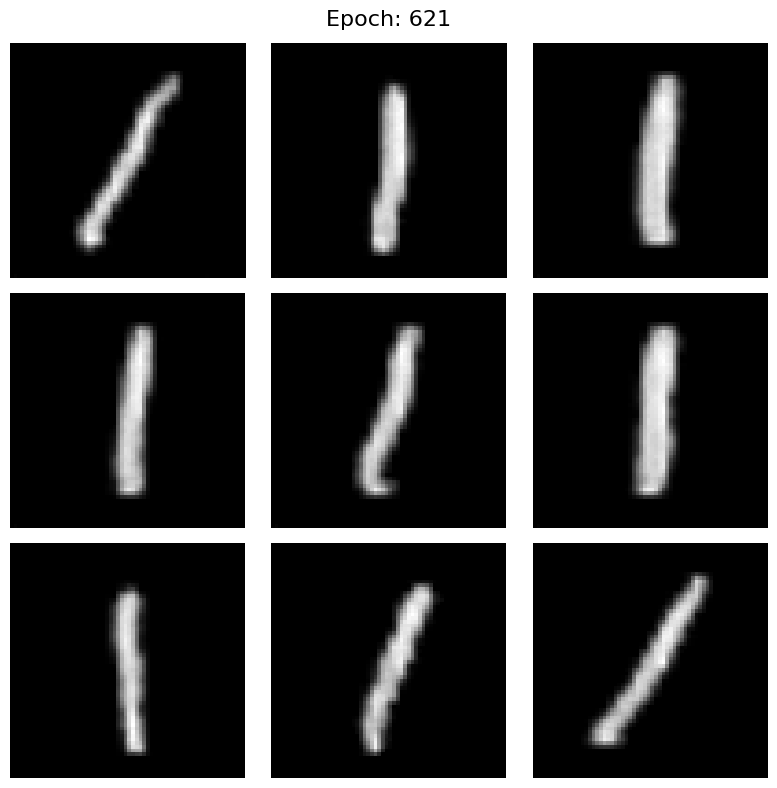

Epoch: 622/1000, d_loss: 0.4009, g_loss: 4.4298, time: 10.9816 sec


Epoch: 623/1000, d_loss: 0.2895, g_loss: 2.9707, time: 10.9734 sec


Epoch: 624/1000, d_loss: 0.1864, g_loss: 3.1558, time: 11.0001 sec


Epoch: 625/1000, d_loss: 0.2059, g_loss: 3.4206, time: 10.9808 sec


Epoch: 626/1000, d_loss: 0.2307, g_loss: 3.6359, time: 10.9497 sec


Epoch: 627/1000, d_loss: 0.3767, g_loss: 4.2017, time: 10.9888 sec


Epoch: 628/1000, d_loss: 0.2322, g_loss: 3.2978, time: 11.0084 sec


Epoch: 629/1000, d_loss: 0.1634, g_loss: 3.7556, time: 10.9898 sec


Epoch: 630/1000, d_loss: 0.3633, g_loss: 3.9087, time: 10.9703 sec


Epoch: 631/1000, d_loss: 0.2565, g_loss: 2.9402, time: 10.9723 sec


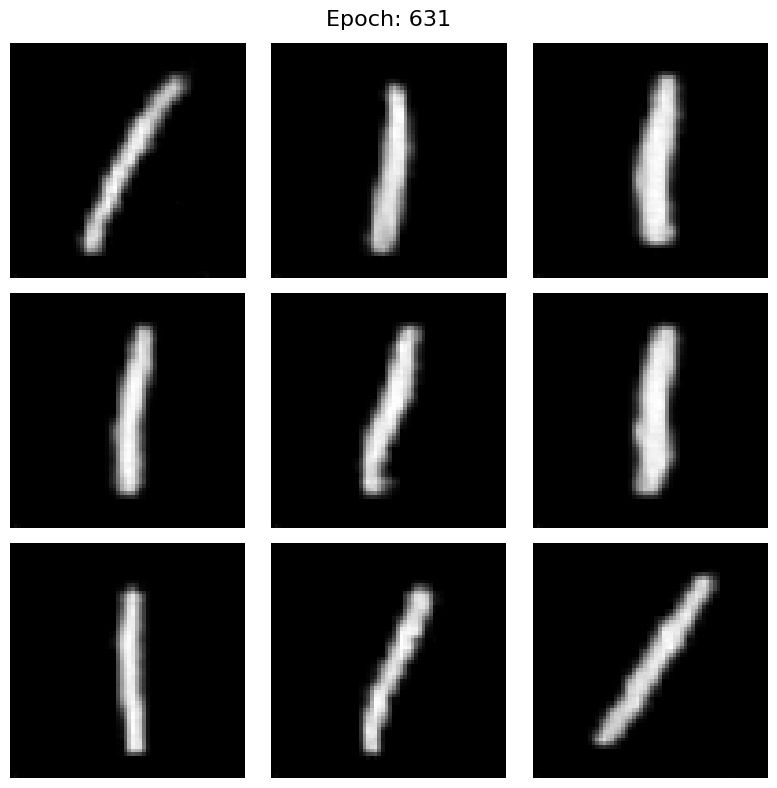

Epoch: 632/1000, d_loss: 0.2079, g_loss: 3.0640, time: 10.9782 sec


Epoch: 633/1000, d_loss: 0.3051, g_loss: 3.7147, time: 10.9867 sec


Epoch: 634/1000, d_loss: 0.2324, g_loss: 3.2026, time: 10.9991 sec


Epoch: 635/1000, d_loss: 0.2323, g_loss: 3.4350, time: 10.9737 sec


Epoch: 636/1000, d_loss: 0.2702, g_loss: 3.5817, time: 10.9930 sec


Epoch: 637/1000, d_loss: 0.2252, g_loss: 3.2935, time: 10.9597 sec


Epoch: 638/1000, d_loss: 0.2257, g_loss: 3.2651, time: 11.0182 sec


Epoch: 639/1000, d_loss: 0.2391, g_loss: 3.5862, time: 11.0387 sec


Epoch: 640/1000, d_loss: 0.2566, g_loss: 3.2098, time: 10.9648 sec


Epoch: 641/1000, d_loss: 0.2471, g_loss: 3.4429, time: 10.9819 sec


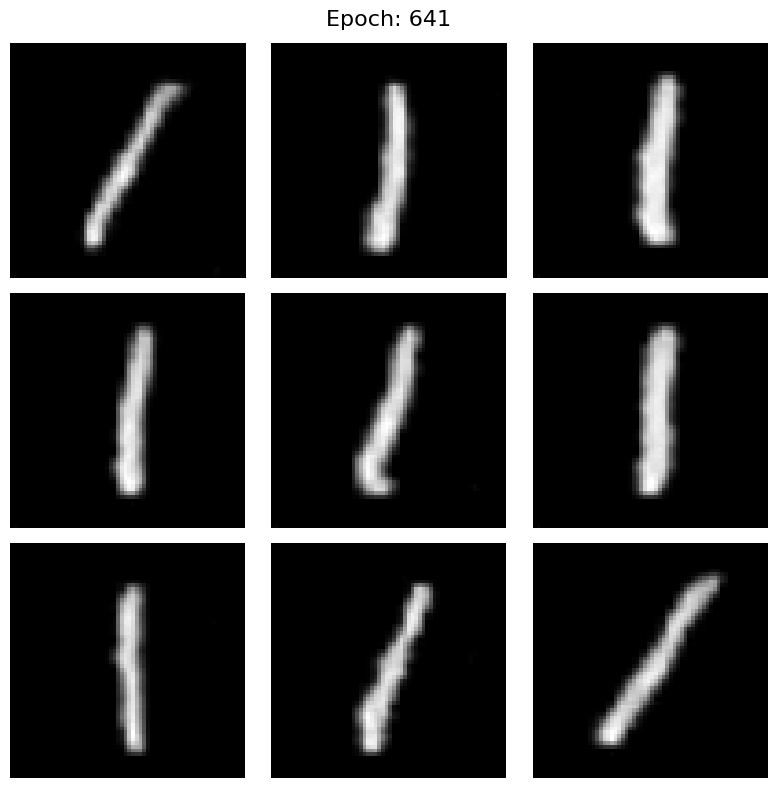

Epoch: 642/1000, d_loss: 0.1813, g_loss: 3.4606, time: 11.0795 sec


Epoch: 643/1000, d_loss: 0.1829, g_loss: 3.4642, time: 11.3461 sec


Epoch: 644/1000, d_loss: 0.4174, g_loss: 4.5201, time: 11.0191 sec


Epoch: 645/1000, d_loss: 0.2612, g_loss: 3.2605, time: 11.1255 sec


Epoch: 646/1000, d_loss: 0.1741, g_loss: 3.2895, time: 10.9791 sec


Epoch: 647/1000, d_loss: 0.2128, g_loss: 3.4319, time: 10.9773 sec


Epoch: 648/1000, d_loss: 0.2599, g_loss: 4.1580, time: 10.9635 sec


Epoch: 649/1000, d_loss: 0.2335, g_loss: 3.2436, time: 10.9763 sec


Epoch: 650/1000, d_loss: 0.2008, g_loss: 3.5852, time: 11.0027 sec


Epoch: 651/1000, d_loss: 0.1907, g_loss: 3.6564, time: 11.0172 sec


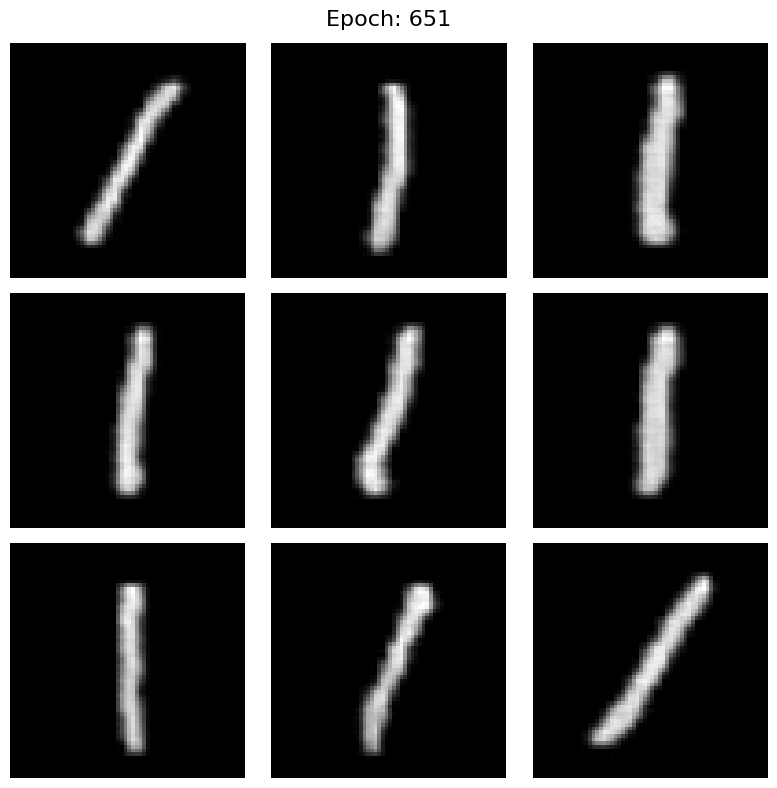

Epoch: 652/1000, d_loss: 0.2947, g_loss: 4.1031, time: 11.1313 sec


Epoch: 653/1000, d_loss: 0.2220, g_loss: 3.3486, time: 10.9866 sec


Epoch: 654/1000, d_loss: 0.2574, g_loss: 3.4630, time: 11.0657 sec


Epoch: 655/1000, d_loss: 0.1894, g_loss: 3.3410, time: 11.0261 sec


Epoch: 656/1000, d_loss: 0.2378, g_loss: 3.3795, time: 10.9873 sec


Epoch: 657/1000, d_loss: 0.2123, g_loss: 3.5008, time: 10.9997 sec


Epoch: 658/1000, d_loss: 0.3566, g_loss: 4.2997, time: 11.0116 sec


Epoch: 659/1000, d_loss: 0.1870, g_loss: 3.2326, time: 11.2418 sec


Epoch: 660/1000, d_loss: 0.1803, g_loss: 3.4553, time: 10.9755 sec


Epoch: 661/1000, d_loss: 0.3421, g_loss: 4.8379, time: 10.9473 sec


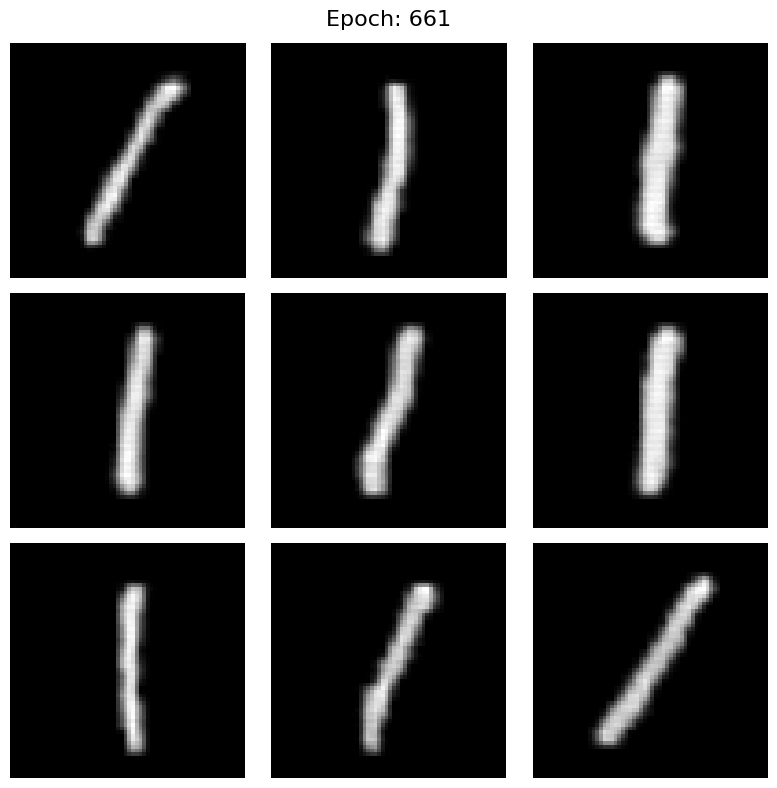

Epoch: 662/1000, d_loss: 0.2489, g_loss: 3.6034, time: 10.9772 sec


Epoch: 663/1000, d_loss: 0.1908, g_loss: 3.2228, time: 10.9812 sec


Epoch: 664/1000, d_loss: 0.1984, g_loss: 3.7998, time: 10.9840 sec


Epoch: 665/1000, d_loss: 0.2581, g_loss: 4.0225, time: 11.0027 sec


Epoch: 666/1000, d_loss: 0.1758, g_loss: 3.3994, time: 10.9809 sec


Epoch: 667/1000, d_loss: 0.2577, g_loss: 4.2396, time: 10.9533 sec


Epoch: 668/1000, d_loss: 0.3872, g_loss: 4.1202, time: 11.0232 sec


Epoch: 669/1000, d_loss: 0.1896, g_loss: 3.1992, time: 11.2715 sec


Epoch: 670/1000, d_loss: 0.2069, g_loss: 3.3565, time: 10.9608 sec


Epoch: 671/1000, d_loss: 0.3144, g_loss: 4.0796, time: 10.9776 sec


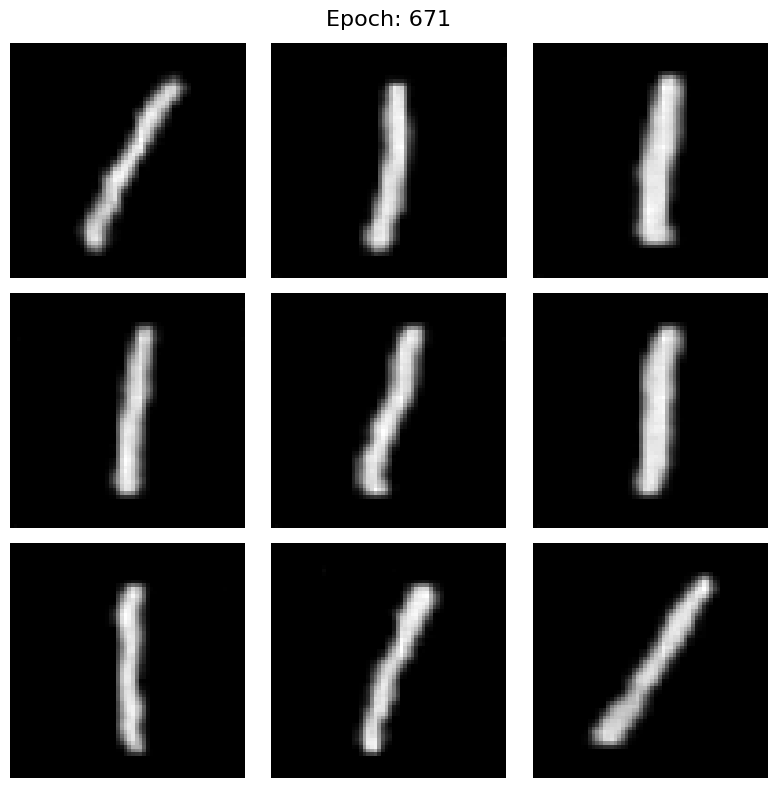

Epoch: 672/1000, d_loss: 0.1917, g_loss: 3.4083, time: 10.9448 sec


Epoch: 673/1000, d_loss: 0.2055, g_loss: 3.2644, time: 10.9772 sec


Epoch: 674/1000, d_loss: 0.1819, g_loss: 3.6429, time: 11.0067 sec


Epoch: 675/1000, d_loss: 0.3241, g_loss: 4.3017, time: 10.9825 sec


Epoch: 676/1000, d_loss: 0.1758, g_loss: 3.3186, time: 10.9669 sec


Epoch: 677/1000, d_loss: 0.1803, g_loss: 3.4929, time: 10.9494 sec


Epoch: 678/1000, d_loss: 0.2626, g_loss: 3.9792, time: 10.9658 sec


Epoch: 679/1000, d_loss: 0.1788, g_loss: 3.7016, time: 11.0377 sec


Epoch: 680/1000, d_loss: 0.3058, g_loss: 4.0347, time: 11.2234 sec


Epoch: 681/1000, d_loss: 0.1868, g_loss: 3.4006, time: 10.9943 sec


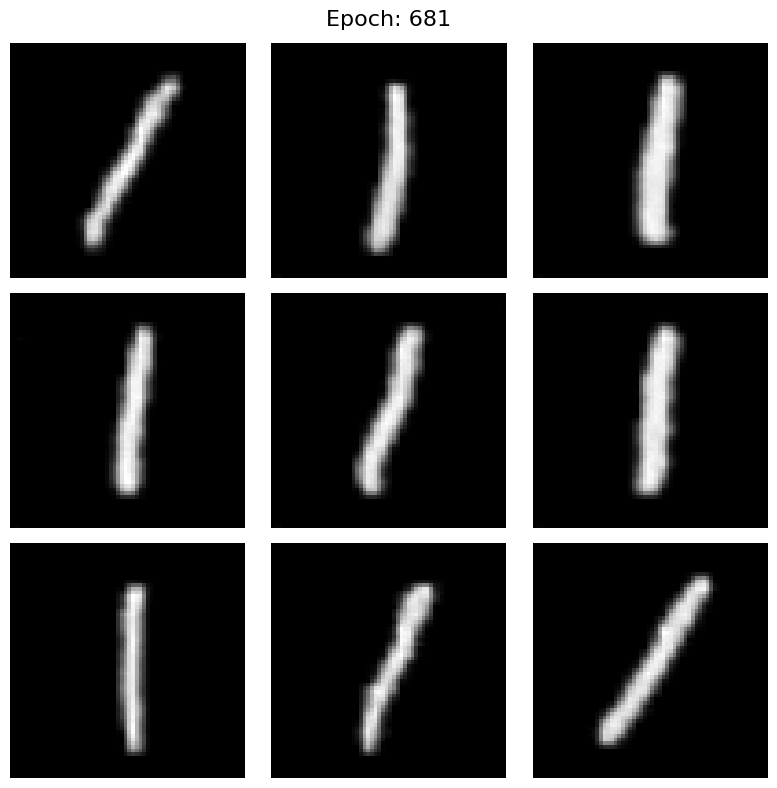

Epoch: 682/1000, d_loss: 0.1918, g_loss: 3.5793, time: 10.9435 sec


Epoch: 683/1000, d_loss: 0.1586, g_loss: 3.5913, time: 10.9529 sec


Epoch: 684/1000, d_loss: 0.2873, g_loss: 4.3766, time: 10.9823 sec


Epoch: 685/1000, d_loss: 0.2627, g_loss: 3.5651, time: 10.9781 sec


Epoch: 686/1000, d_loss: 0.1490, g_loss: 4.0168, time: 10.9512 sec


Epoch: 687/1000, d_loss: 0.1877, g_loss: 3.6035, time: 10.9578 sec


Epoch: 688/1000, d_loss: 0.2346, g_loss: 3.6898, time: 11.1795 sec


Epoch: 689/1000, d_loss: 0.2875, g_loss: 3.7279, time: 10.9708 sec


Epoch: 690/1000, d_loss: 0.1793, g_loss: 3.3222, time: 10.9861 sec


Epoch: 691/1000, d_loss: 0.1750, g_loss: 3.6234, time: 11.0399 sec


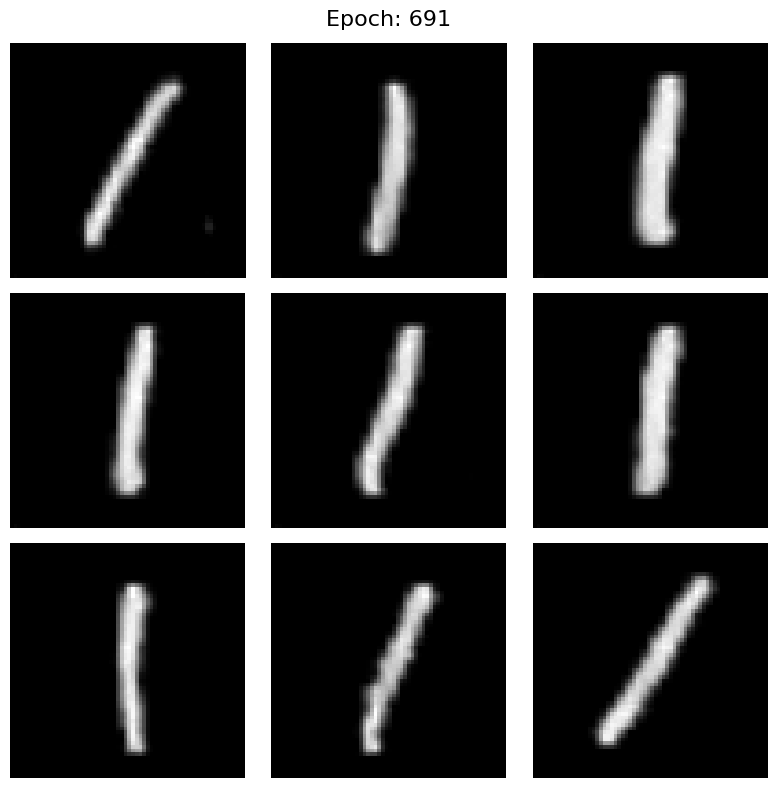

Epoch: 692/1000, d_loss: 0.2979, g_loss: 4.0475, time: 11.3886 sec


Epoch: 693/1000, d_loss: 0.1981, g_loss: 3.4686, time: 10.9746 sec


Epoch: 694/1000, d_loss: 0.1870, g_loss: 3.5477, time: 10.9700 sec


Epoch: 695/1000, d_loss: 0.2473, g_loss: 3.7126, time: 11.0748 sec


Epoch: 696/1000, d_loss: 0.1702, g_loss: 3.4997, time: 11.2167 sec


Epoch: 697/1000, d_loss: 0.2293, g_loss: 3.9631, time: 11.0515 sec


Epoch: 698/1000, d_loss: 0.1973, g_loss: 3.4423, time: 10.9547 sec


Epoch: 699/1000, d_loss: 0.1780, g_loss: 3.5556, time: 11.0059 sec


Epoch: 700/1000, d_loss: 0.2315, g_loss: 4.1797, time: 10.9583 sec


Epoch: 701/1000, d_loss: 0.1411, g_loss: 3.8850, time: 10.9891 sec


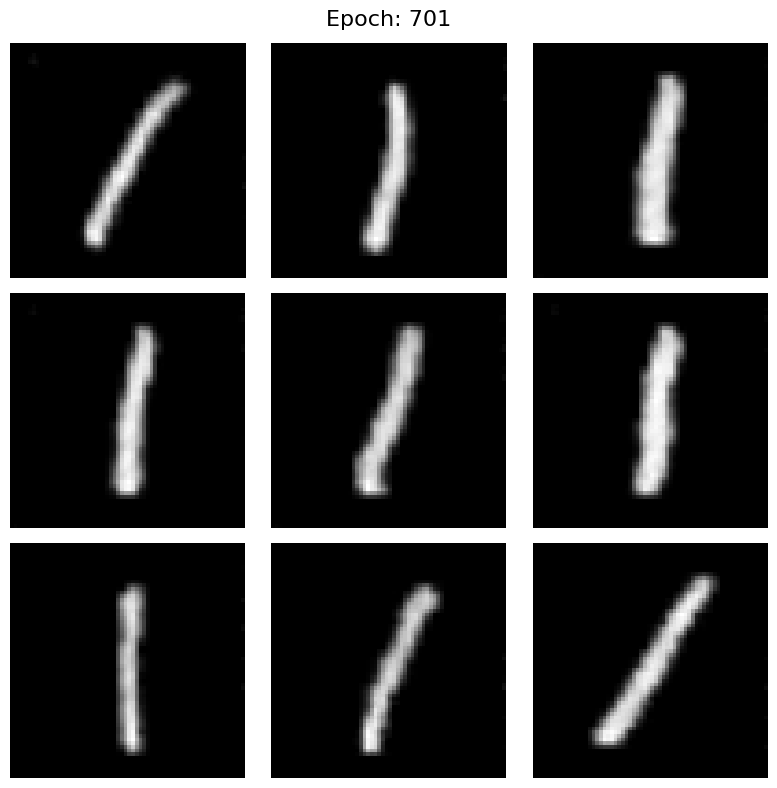

Epoch: 702/1000, d_loss: 0.3342, g_loss: 5.1206, time: 10.9576 sec


Epoch: 703/1000, d_loss: 0.2420, g_loss: 3.3772, time: 10.9671 sec


Epoch: 704/1000, d_loss: 0.2059, g_loss: 3.9377, time: 11.2906 sec


Epoch: 705/1000, d_loss: 0.2471, g_loss: 3.3583, time: 11.1372 sec


Epoch: 706/1000, d_loss: 0.1785, g_loss: 3.6038, time: 10.9435 sec


Epoch: 707/1000, d_loss: 0.1875, g_loss: 3.4764, time: 10.9902 sec


Epoch: 708/1000, d_loss: 0.1630, g_loss: 4.0002, time: 11.1421 sec


Epoch: 709/1000, d_loss: 0.2139, g_loss: 3.8134, time: 11.0497 sec


Epoch: 710/1000, d_loss: 0.2167, g_loss: 4.2976, time: 10.9372 sec


Epoch: 711/1000, d_loss: 0.1913, g_loss: 3.5625, time: 10.9867 sec


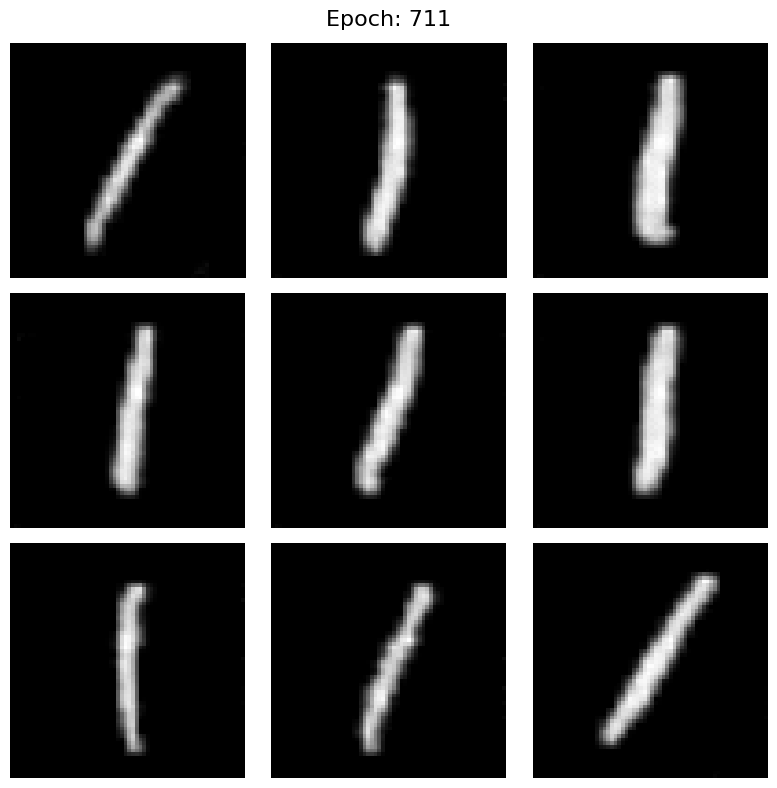

Epoch: 712/1000, d_loss: 0.1729, g_loss: 3.7466, time: 11.0630 sec


Epoch: 713/1000, d_loss: 0.1491, g_loss: 3.9347, time: 10.9848 sec


Epoch: 714/1000, d_loss: 0.3609, g_loss: 5.2385, time: 10.9531 sec


Epoch: 715/1000, d_loss: 0.2159, g_loss: 3.3056, time: 10.9571 sec


Epoch: 716/1000, d_loss: 0.1410, g_loss: 4.0201, time: 10.9966 sec


Epoch: 717/1000, d_loss: 0.1683, g_loss: 3.8454, time: 10.9918 sec


Epoch: 718/1000, d_loss: 0.1437, g_loss: 3.7206, time: 11.3462 sec


Epoch: 719/1000, d_loss: 0.3394, g_loss: 5.4612, time: 11.0268 sec


Epoch: 720/1000, d_loss: 0.3590, g_loss: 4.0870, time: 11.0449 sec


Epoch: 721/1000, d_loss: 0.1450, g_loss: 3.5530, time: 11.0215 sec


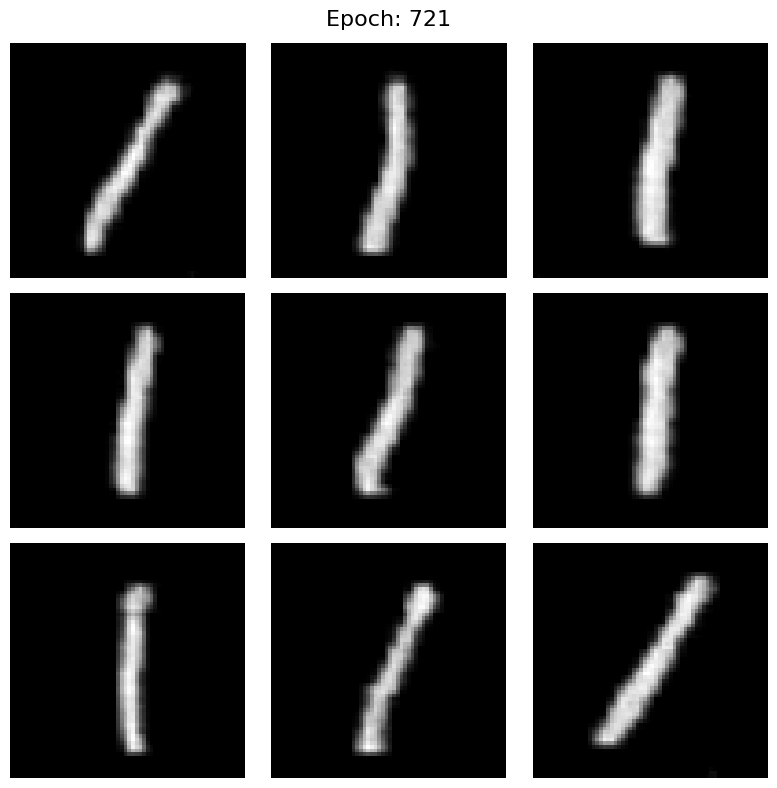

Epoch: 722/1000, d_loss: 0.1182, g_loss: 3.8831, time: 10.9528 sec


Epoch: 723/1000, d_loss: 0.2195, g_loss: 4.5246, time: 10.9869 sec


Epoch: 724/1000, d_loss: 0.3775, g_loss: 4.8062, time: 11.0306 sec


Epoch: 725/1000, d_loss: 0.1708, g_loss: 3.4913, time: 10.9596 sec


Epoch: 726/1000, d_loss: 0.1306, g_loss: 4.0987, time: 10.9713 sec


Epoch: 727/1000, d_loss: 0.2836, g_loss: 4.7593, time: 10.9782 sec


Epoch: 728/1000, d_loss: 0.2135, g_loss: 3.4274, time: 10.9430 sec


Epoch: 729/1000, d_loss: 0.1578, g_loss: 3.7525, time: 11.0365 sec


Epoch: 730/1000, d_loss: 0.1825, g_loss: 4.0459, time: 10.9614 sec


Epoch: 731/1000, d_loss: 0.1418, g_loss: 4.3382, time: 10.9779 sec


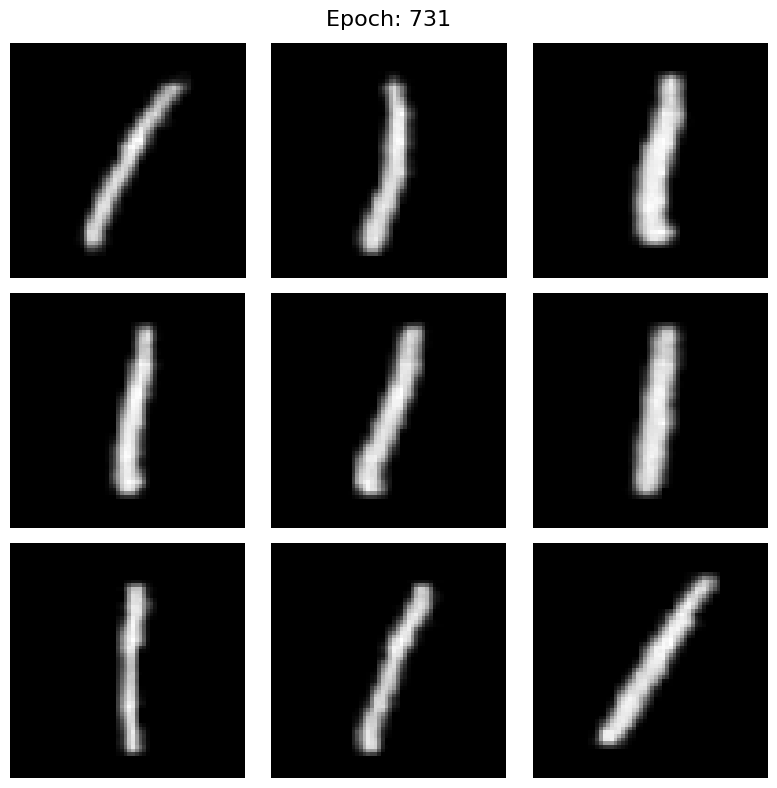

Epoch: 732/1000, d_loss: 0.2000, g_loss: 4.8254, time: 10.9460 sec


Epoch: 733/1000, d_loss: 0.2379, g_loss: 3.8412, time: 10.9411 sec


Epoch: 734/1000, d_loss: 0.1350, g_loss: 3.8543, time: 11.0254 sec


Epoch: 735/1000, d_loss: 0.1705, g_loss: 4.7073, time: 10.9429 sec


Epoch: 736/1000, d_loss: 0.2138, g_loss: 4.0896, time: 10.9959 sec


Epoch: 737/1000, d_loss: 0.2245, g_loss: 3.9241, time: 10.9565 sec


Epoch: 738/1000, d_loss: 0.2080, g_loss: 3.7339, time: 10.9624 sec


Epoch: 739/1000, d_loss: 0.1681, g_loss: 3.7288, time: 11.3329 sec


Epoch: 740/1000, d_loss: 0.1766, g_loss: 3.9241, time: 10.9605 sec


Epoch: 741/1000, d_loss: 0.1312, g_loss: 4.0067, time: 10.9972 sec


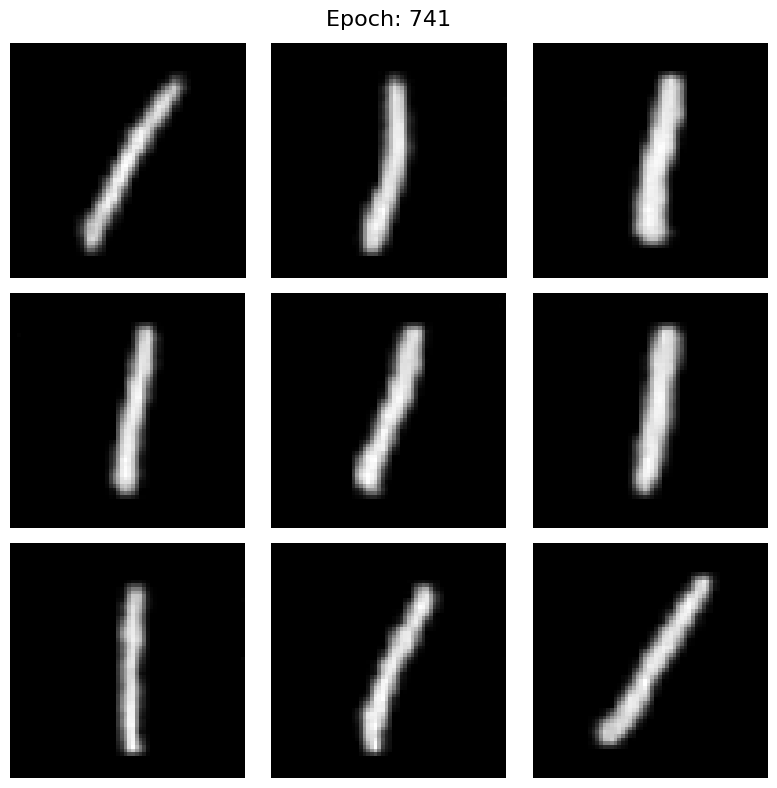

Epoch: 742/1000, d_loss: 0.2270, g_loss: 4.4779, time: 11.0132 sec


Epoch: 743/1000, d_loss: 0.1678, g_loss: 3.8348, time: 10.9374 sec


Epoch: 744/1000, d_loss: 0.1560, g_loss: 4.1402, time: 10.9928 sec


Epoch: 745/1000, d_loss: 0.3503, g_loss: 4.5148, time: 11.0193 sec


Epoch: 746/1000, d_loss: 0.1689, g_loss: 3.6580, time: 11.0003 sec


Epoch: 747/1000, d_loss: 0.1185, g_loss: 4.1810, time: 11.0494 sec


Epoch: 748/1000, d_loss: 0.1406, g_loss: 4.0870, time: 10.9829 sec


Epoch: 749/1000, d_loss: 0.2536, g_loss: 4.0615, time: 10.9892 sec


Epoch: 750/1000, d_loss: 0.1300, g_loss: 4.1250, time: 11.1332 sec


Epoch: 751/1000, d_loss: 0.1723, g_loss: 4.2316, time: 10.9648 sec


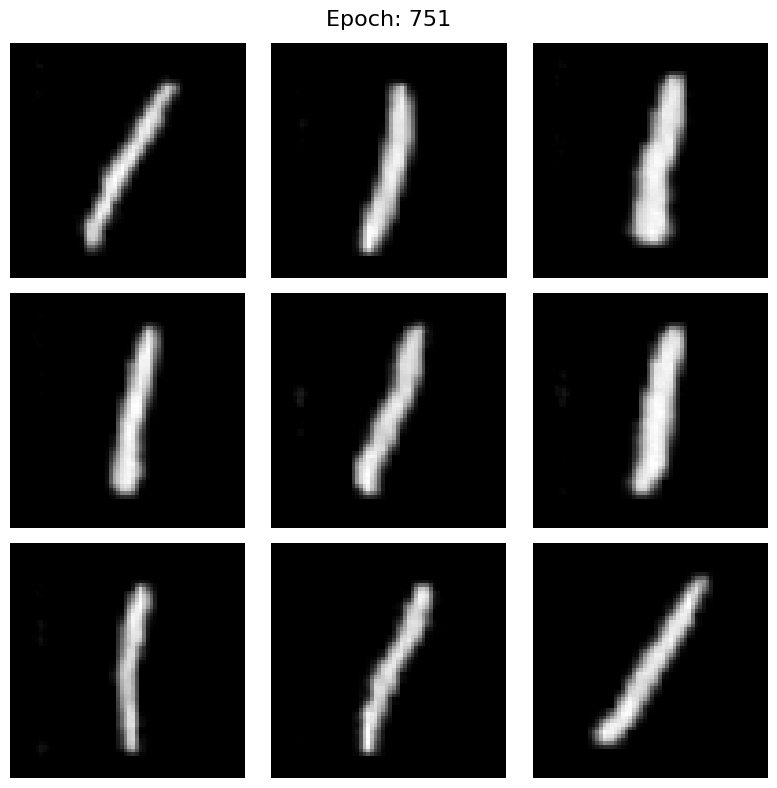

Epoch: 752/1000, d_loss: 0.1913, g_loss: 4.0327, time: 11.0350 sec


Epoch: 753/1000, d_loss: 0.1627, g_loss: 3.9884, time: 10.9874 sec


Epoch: 754/1000, d_loss: 0.1257, g_loss: 3.9668, time: 10.9591 sec


Epoch: 755/1000, d_loss: 0.2007, g_loss: 4.3489, time: 11.0066 sec


Epoch: 756/1000, d_loss: 0.2349, g_loss: 3.5874, time: 11.0231 sec


Epoch: 757/1000, d_loss: 0.1274, g_loss: 3.9983, time: 11.0933 sec


Epoch: 758/1000, d_loss: 0.2034, g_loss: 4.7942, time: 11.0755 sec


Epoch: 759/1000, d_loss: 0.1891, g_loss: 3.9092, time: 11.0698 sec


Epoch: 760/1000, d_loss: 0.1204, g_loss: 4.1077, time: 11.3128 sec


Epoch: 761/1000, d_loss: 0.2497, g_loss: 4.5549, time: 11.1916 sec


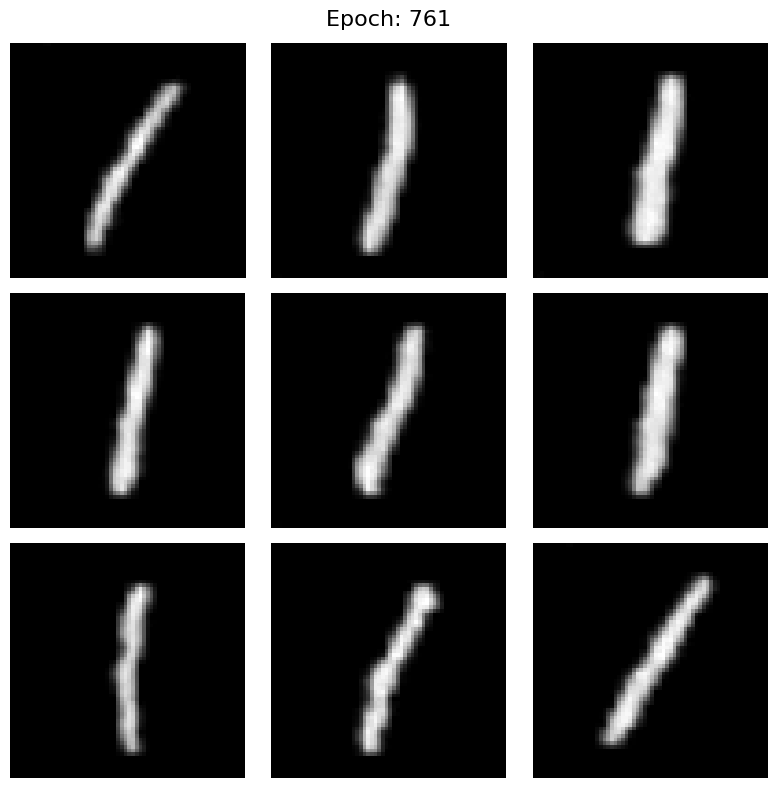

Epoch: 762/1000, d_loss: 0.1842, g_loss: 3.4791, time: 11.0946 sec


Epoch: 763/1000, d_loss: 0.1260, g_loss: 4.3886, time: 10.9774 sec


Epoch: 764/1000, d_loss: 0.1339, g_loss: 4.1822, time: 11.1225 sec


Epoch: 765/1000, d_loss: 0.2480, g_loss: 5.3879, time: 11.0828 sec


Epoch: 766/1000, d_loss: 0.1571, g_loss: 4.0213, time: 10.9635 sec


Epoch: 767/1000, d_loss: 0.1401, g_loss: 4.0851, time: 10.9834 sec


Epoch: 768/1000, d_loss: 0.1839, g_loss: 4.4693, time: 11.0021 sec


Epoch: 769/1000, d_loss: 0.1713, g_loss: 4.1456, time: 10.9772 sec


Epoch: 770/1000, d_loss: 0.1490, g_loss: 4.1126, time: 10.9846 sec


Epoch: 771/1000, d_loss: 0.1206, g_loss: 4.5903, time: 11.2793 sec


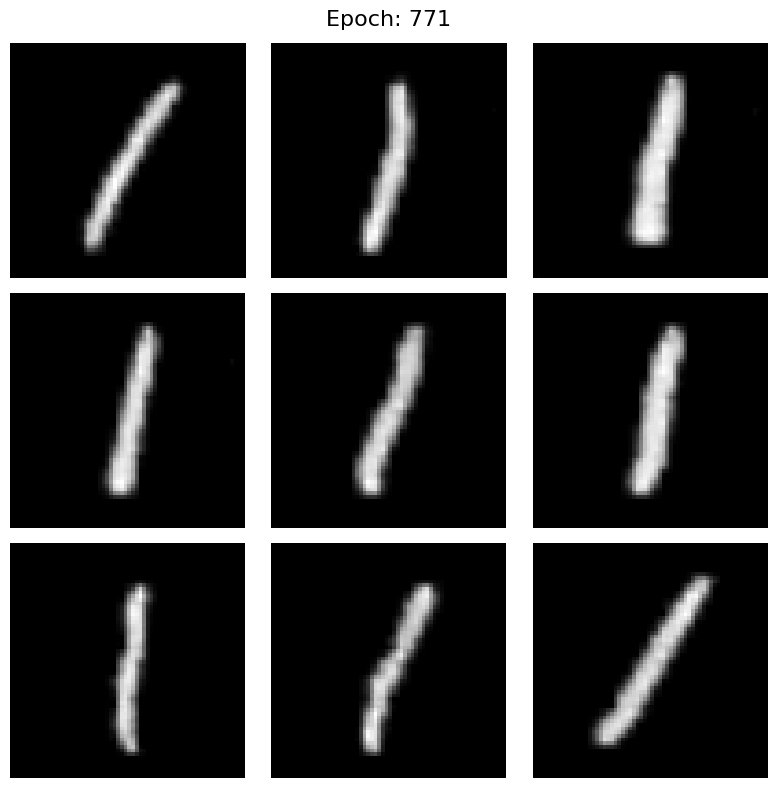

Epoch: 772/1000, d_loss: 0.2072, g_loss: 4.2847, time: 11.0098 sec


Epoch: 773/1000, d_loss: 0.1891, g_loss: 4.1273, time: 10.9838 sec


Epoch: 774/1000, d_loss: 0.1210, g_loss: 4.1402, time: 10.9799 sec


Epoch: 775/1000, d_loss: 0.1890, g_loss: 4.6330, time: 10.9504 sec


Epoch: 776/1000, d_loss: 0.1497, g_loss: 3.7721, time: 10.9925 sec


Epoch: 777/1000, d_loss: 0.1160, g_loss: 4.4476, time: 11.0126 sec


Epoch: 778/1000, d_loss: 0.1849, g_loss: 5.3163, time: 10.9857 sec


Epoch: 779/1000, d_loss: 0.2113, g_loss: 4.1339, time: 10.9530 sec


Epoch: 780/1000, d_loss: 0.1329, g_loss: 4.3249, time: 10.9578 sec


Epoch: 781/1000, d_loss: 0.1677, g_loss: 4.5174, time: 10.9814 sec


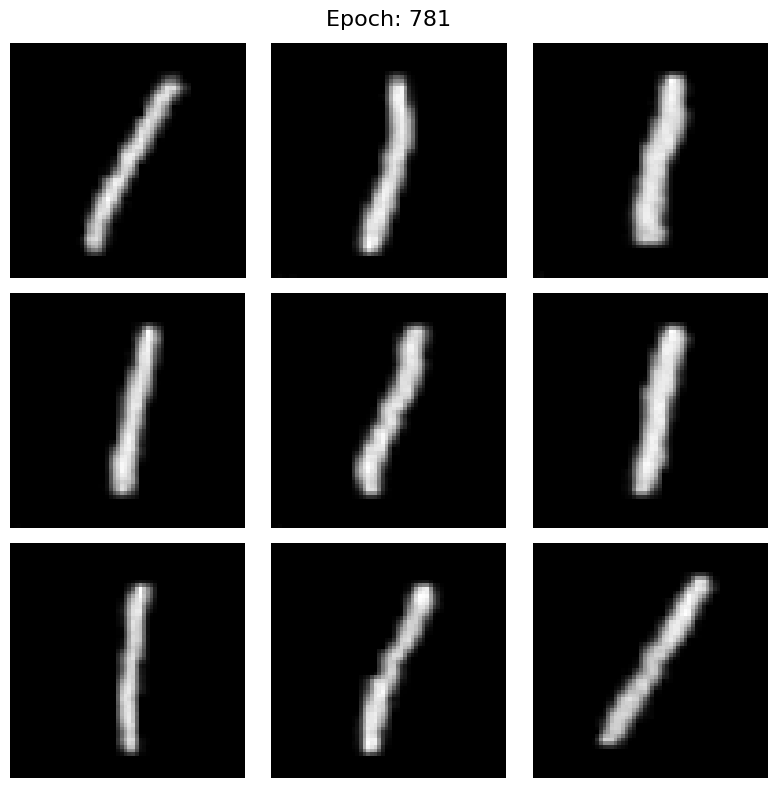

Epoch: 782/1000, d_loss: 0.1285, g_loss: 4.0265, time: 10.9498 sec


Epoch: 783/1000, d_loss: 0.1606, g_loss: 4.6906, time: 11.3952 sec


Epoch: 784/1000, d_loss: 0.1523, g_loss: 3.9258, time: 10.9470 sec


Epoch: 785/1000, d_loss: 0.2832, g_loss: 5.5635, time: 11.3837 sec


Epoch: 786/1000, d_loss: 0.1348, g_loss: 4.0975, time: 11.2130 sec


Epoch: 787/1000, d_loss: 0.1396, g_loss: 4.9200, time: 11.0114 sec


Epoch: 788/1000, d_loss: 0.1797, g_loss: 3.9834, time: 11.0612 sec


Epoch: 789/1000, d_loss: 0.1192, g_loss: 4.3344, time: 11.2393 sec


Epoch: 790/1000, d_loss: 0.2273, g_loss: 4.6853, time: 11.0220 sec


Epoch: 791/1000, d_loss: 0.0947, g_loss: 4.1921, time: 10.9805 sec


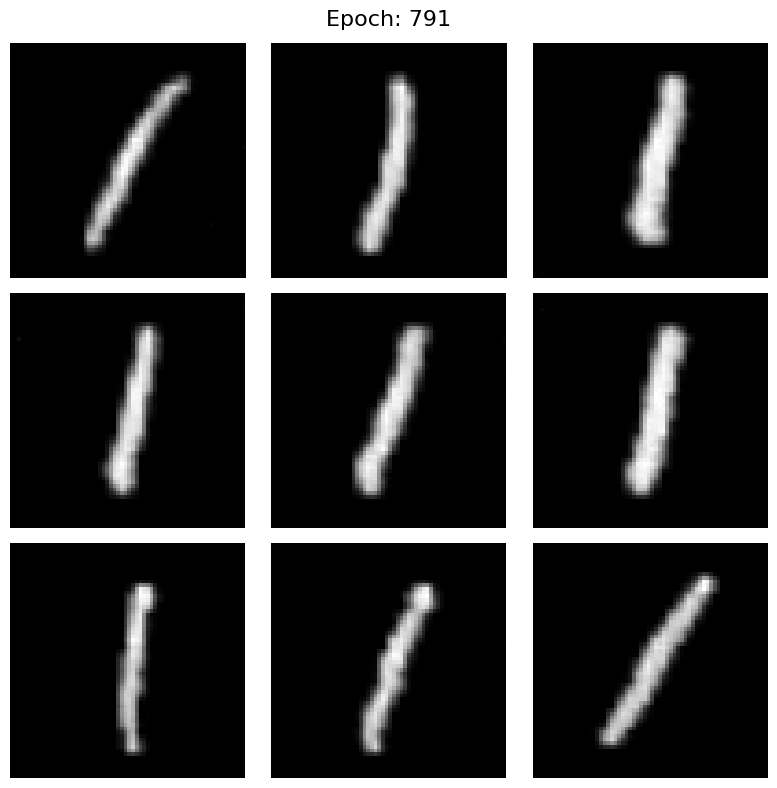

Epoch: 792/1000, d_loss: 0.2445, g_loss: 5.8973, time: 11.0031 sec


Epoch: 793/1000, d_loss: 0.2771, g_loss: 4.5084, time: 11.0166 sec


Epoch: 794/1000, d_loss: 0.1423, g_loss: 3.7592, time: 10.9668 sec


Epoch: 795/1000, d_loss: 0.1387, g_loss: 4.6146, time: 11.0134 sec


Epoch: 796/1000, d_loss: 0.3037, g_loss: 4.8198, time: 10.9695 sec


Epoch: 797/1000, d_loss: 0.1473, g_loss: 3.6360, time: 10.9552 sec


Epoch: 798/1000, d_loss: 0.1173, g_loss: 3.9672, time: 10.9523 sec


Epoch: 799/1000, d_loss: 0.2457, g_loss: 4.3283, time: 11.0047 sec


Epoch: 800/1000, d_loss: 0.1345, g_loss: 4.0509, time: 11.0054 sec


Epoch: 801/1000, d_loss: 0.1785, g_loss: 5.0645, time: 10.9419 sec


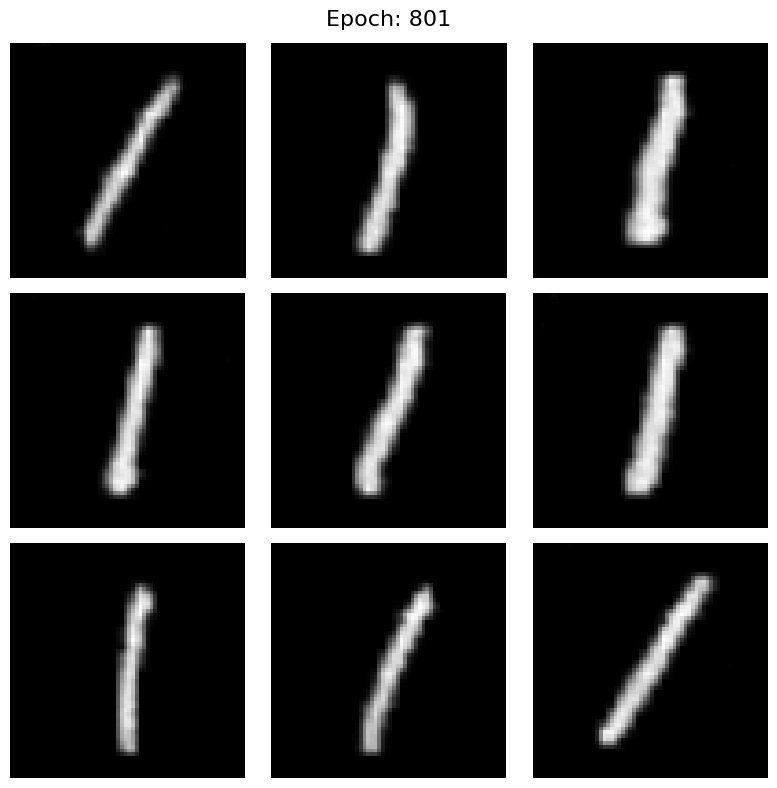

Epoch: 802/1000, d_loss: 0.1470, g_loss: 4.2333, time: 10.9553 sec


Epoch: 803/1000, d_loss: 0.1643, g_loss: 4.1308, time: 10.9895 sec


Epoch: 804/1000, d_loss: 0.1566, g_loss: 4.0615, time: 10.9449 sec


Epoch: 805/1000, d_loss: 0.1305, g_loss: 4.4496, time: 10.9511 sec


Epoch: 806/1000, d_loss: 0.1122, g_loss: 4.6660, time: 10.9427 sec


Epoch: 807/1000, d_loss: 0.1434, g_loss: 5.1827, time: 11.0590 sec


Epoch: 808/1000, d_loss: 0.2941, g_loss: 5.0318, time: 10.9473 sec


Epoch: 809/1000, d_loss: 0.1592, g_loss: 3.9265, time: 11.0083 sec


Epoch: 810/1000, d_loss: 0.1868, g_loss: 4.4614, time: 10.9917 sec


Epoch: 811/1000, d_loss: 0.1443, g_loss: 3.8759, time: 11.0250 sec


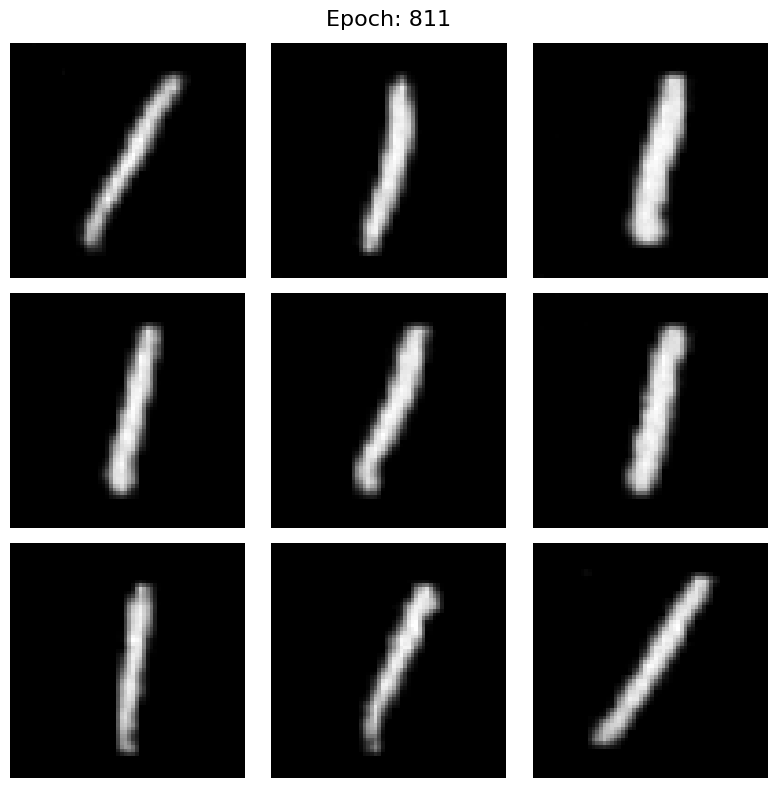

Epoch: 812/1000, d_loss: 0.1355, g_loss: 4.1877, time: 10.9624 sec


Epoch: 813/1000, d_loss: 0.1074, g_loss: 4.3901, time: 10.9332 sec


Epoch: 814/1000, d_loss: 0.1613, g_loss: 4.8908, time: 10.9695 sec


Epoch: 815/1000, d_loss: 0.1794, g_loss: 4.2208, time: 11.0169 sec


Epoch: 816/1000, d_loss: 0.1381, g_loss: 4.4415, time: 10.9940 sec


Epoch: 817/1000, d_loss: 0.0997, g_loss: 4.8479, time: 10.9552 sec


Epoch: 818/1000, d_loss: 0.1568, g_loss: 4.5647, time: 10.9453 sec


Epoch: 819/1000, d_loss: 0.1534, g_loss: 4.2889, time: 11.0087 sec


Epoch: 820/1000, d_loss: 0.1552, g_loss: 4.2080, time: 10.9925 sec


Epoch: 821/1000, d_loss: 0.1625, g_loss: 4.6010, time: 10.9719 sec


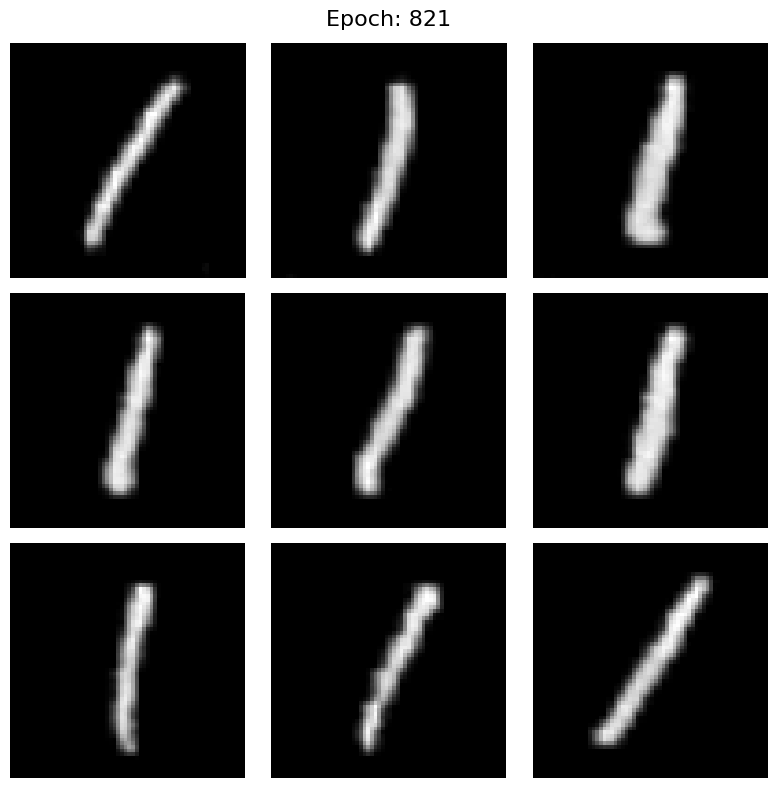

Epoch: 822/1000, d_loss: 0.1578, g_loss: 4.4408, time: 11.3060 sec


Epoch: 823/1000, d_loss: 0.1232, g_loss: 4.4590, time: 10.9244 sec


Epoch: 824/1000, d_loss: 0.1965, g_loss: 4.1408, time: 10.9851 sec


Epoch: 825/1000, d_loss: 0.1207, g_loss: 4.1889, time: 10.9713 sec


Epoch: 826/1000, d_loss: 0.1166, g_loss: 4.6192, time: 10.9454 sec


Epoch: 827/1000, d_loss: 0.1481, g_loss: 5.2509, time: 11.0149 sec


Epoch: 828/1000, d_loss: 0.1682, g_loss: 4.5448, time: 10.9724 sec


Epoch: 829/1000, d_loss: 0.1477, g_loss: 4.3294, time: 10.9653 sec


Epoch: 830/1000, d_loss: 0.1495, g_loss: 4.8006, time: 10.9545 sec


Epoch: 831/1000, d_loss: 0.1414, g_loss: 4.5986, time: 10.9629 sec


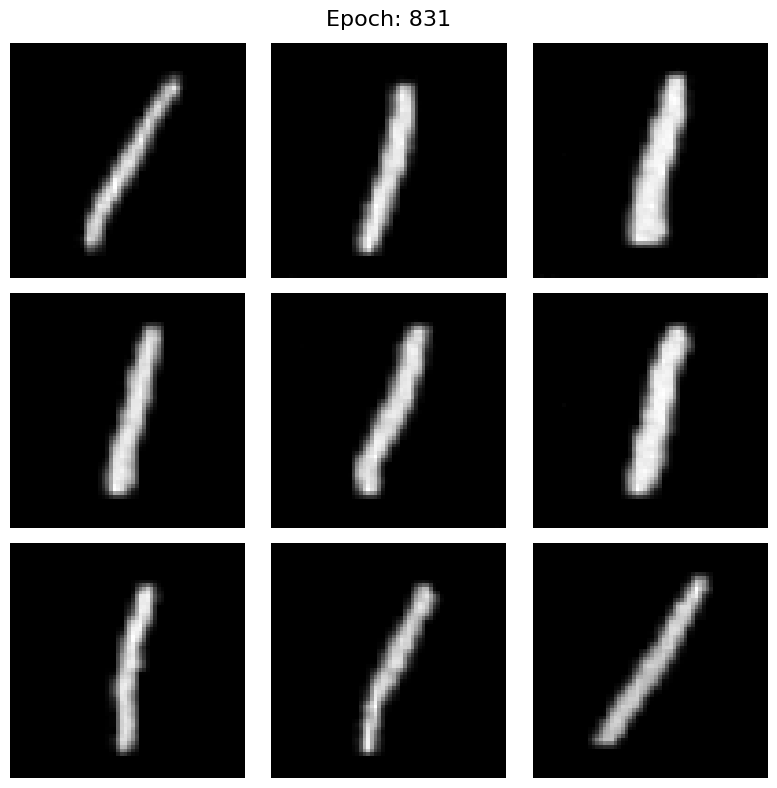

Epoch: 832/1000, d_loss: 0.1269, g_loss: 3.9434, time: 11.2773 sec


Epoch: 833/1000, d_loss: 0.1250, g_loss: 5.2317, time: 10.9869 sec


Epoch: 834/1000, d_loss: 0.1539, g_loss: 4.8043, time: 11.0413 sec


Epoch: 835/1000, d_loss: 0.0762, g_loss: 4.8118, time: 11.3988 sec


Epoch: 836/1000, d_loss: 0.1581, g_loss: 5.5151, time: 10.9693 sec


Epoch: 837/1000, d_loss: 0.1785, g_loss: 4.5206, time: 11.3456 sec


Epoch: 838/1000, d_loss: 0.0930, g_loss: 4.5942, time: 11.3014 sec


Epoch: 839/1000, d_loss: 0.1392, g_loss: 5.2417, time: 11.2761 sec


Epoch: 840/1000, d_loss: 0.2109, g_loss: 4.2904, time: 10.9245 sec


Epoch: 841/1000, d_loss: 0.1068, g_loss: 4.6133, time: 10.9461 sec


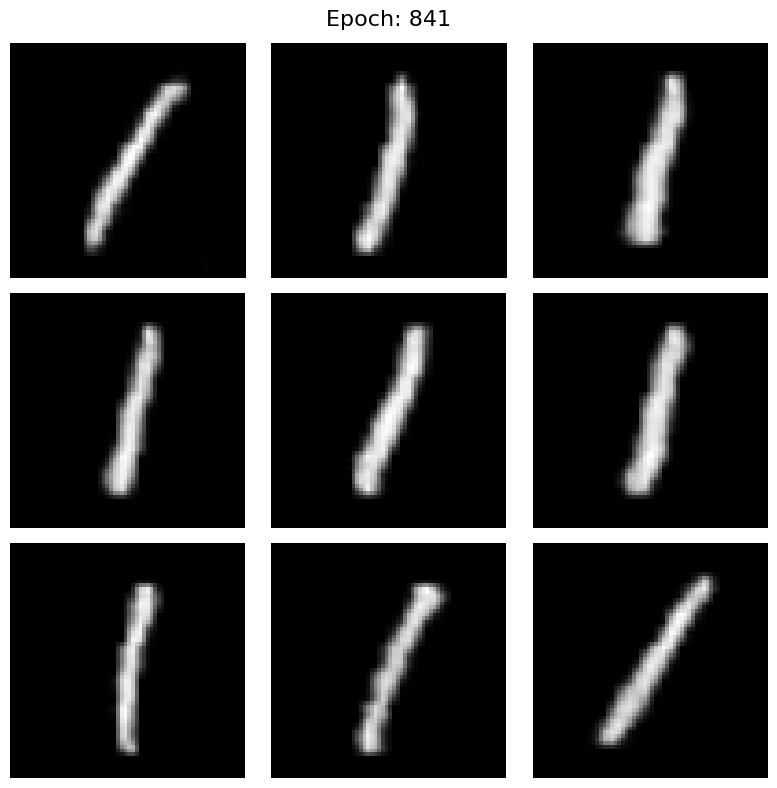

Epoch: 842/1000, d_loss: 0.0833, g_loss: 4.9487, time: 10.9504 sec


Epoch: 843/1000, d_loss: 0.0933, g_loss: 4.7311, time: 11.2071 sec


Epoch: 844/1000, d_loss: 0.1615, g_loss: 5.1313, time: 10.9689 sec


Epoch: 845/1000, d_loss: 0.1445, g_loss: 5.6511, time: 10.9472 sec


Epoch: 846/1000, d_loss: 0.1816, g_loss: 4.5141, time: 11.0329 sec


Epoch: 847/1000, d_loss: 0.1046, g_loss: 4.3638, time: 11.0429 sec


Epoch: 848/1000, d_loss: 0.2606, g_loss: 5.2110, time: 11.1341 sec


Epoch: 849/1000, d_loss: 0.1226, g_loss: 4.1612, time: 10.9679 sec


Epoch: 850/1000, d_loss: 0.1384, g_loss: 5.4423, time: 11.0014 sec


Epoch: 851/1000, d_loss: 0.2280, g_loss: 4.5165, time: 11.0612 sec


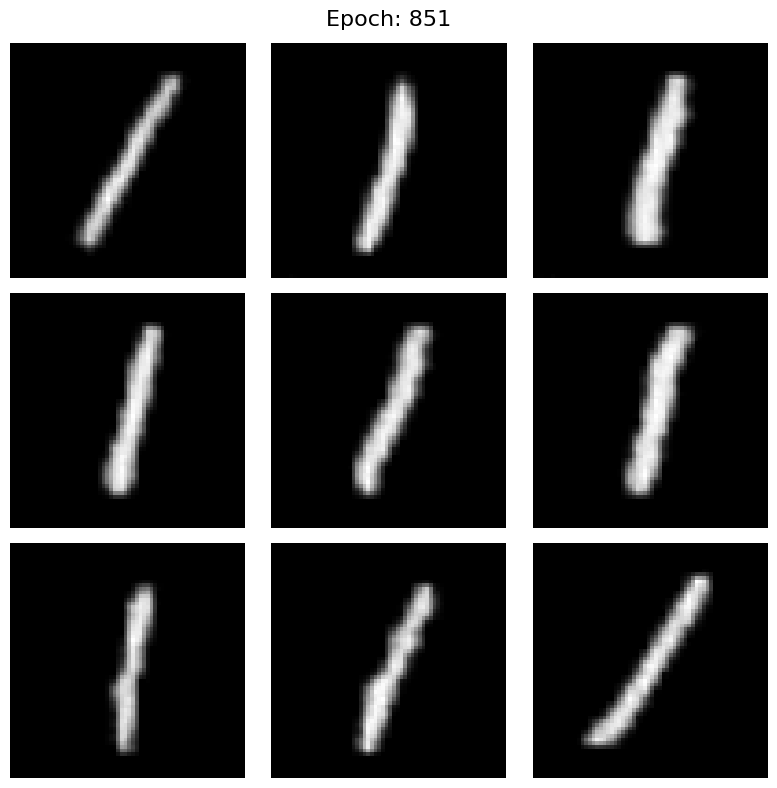

Epoch: 852/1000, d_loss: 0.1456, g_loss: 3.9106, time: 11.2708 sec


Epoch: 853/1000, d_loss: 0.0960, g_loss: 4.3975, time: 10.9925 sec


Epoch: 854/1000, d_loss: 0.1708, g_loss: 5.4050, time: 10.9392 sec


Epoch: 855/1000, d_loss: 0.1803, g_loss: 4.2865, time: 11.2894 sec


Epoch: 856/1000, d_loss: 0.1132, g_loss: 4.2154, time: 11.2587 sec


Epoch: 857/1000, d_loss: 0.1626, g_loss: 4.5791, time: 10.9942 sec


Epoch: 858/1000, d_loss: 0.0903, g_loss: 4.6914, time: 11.0093 sec


Epoch: 859/1000, d_loss: 0.1323, g_loss: 5.7838, time: 11.0387 sec


Epoch: 860/1000, d_loss: 0.1280, g_loss: 4.8664, time: 10.9308 sec


Epoch: 861/1000, d_loss: 0.0886, g_loss: 4.7094, time: 10.9474 sec


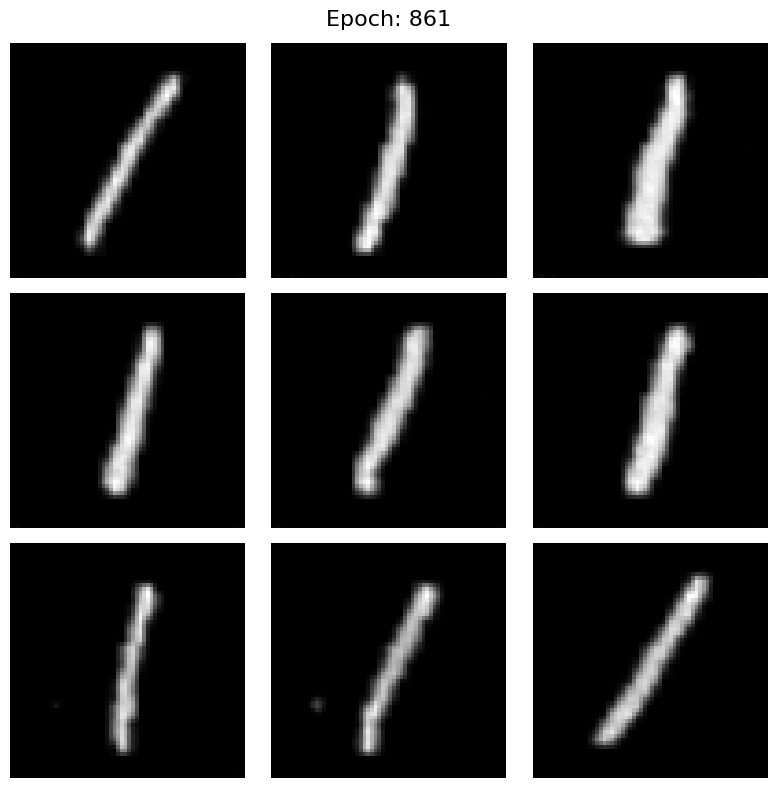

Epoch: 862/1000, d_loss: 0.1861, g_loss: 5.2657, time: 11.0408 sec


Epoch: 863/1000, d_loss: 0.1130, g_loss: 4.2810, time: 10.9911 sec


Epoch: 864/1000, d_loss: 0.0649, g_loss: 4.9656, time: 10.9688 sec


Epoch: 865/1000, d_loss: 0.1381, g_loss: 5.3671, time: 10.9785 sec


Epoch: 866/1000, d_loss: 0.1270, g_loss: 4.8457, time: 11.0284 sec


Epoch: 867/1000, d_loss: 0.1712, g_loss: 5.9140, time: 11.0080 sec


Epoch: 868/1000, d_loss: 0.1529, g_loss: 4.2568, time: 11.0263 sec


Epoch: 869/1000, d_loss: 0.1017, g_loss: 4.5333, time: 11.0229 sec


Epoch: 870/1000, d_loss: 0.1457, g_loss: 6.0073, time: 11.2700 sec


Epoch: 871/1000, d_loss: 0.1487, g_loss: 4.4517, time: 11.3312 sec


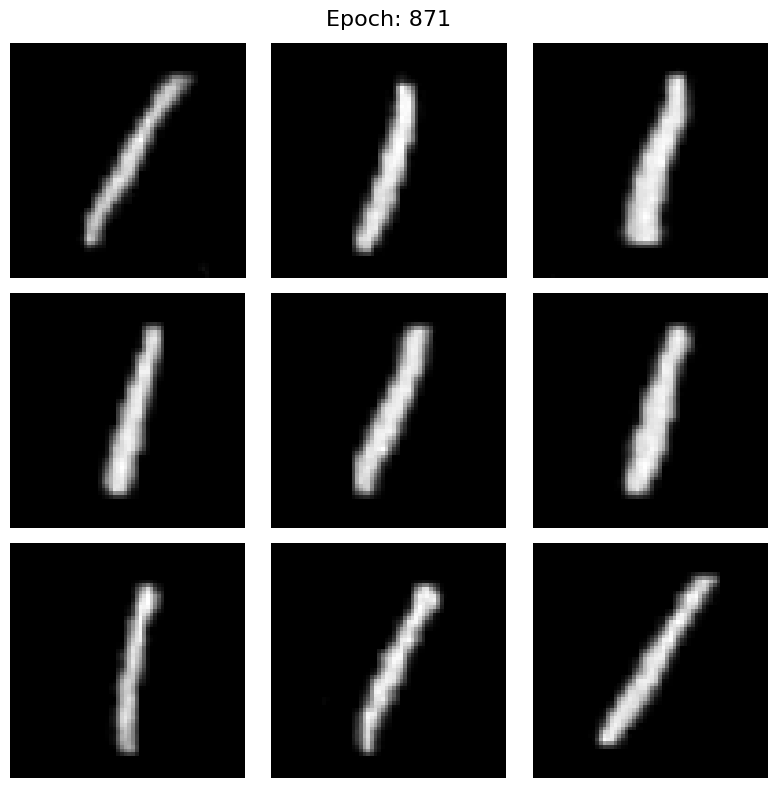

Epoch: 872/1000, d_loss: 0.1081, g_loss: 4.9311, time: 11.2157 sec


Epoch: 873/1000, d_loss: 0.1261, g_loss: 4.3865, time: 11.0210 sec


Epoch: 874/1000, d_loss: 0.0868, g_loss: 4.8393, time: 11.1232 sec


Epoch: 875/1000, d_loss: 0.1160, g_loss: 5.2663, time: 10.9548 sec


Epoch: 876/1000, d_loss: 0.1422, g_loss: 5.0107, time: 10.9928 sec


Epoch: 877/1000, d_loss: 0.0912, g_loss: 5.1153, time: 11.0090 sec


Epoch: 878/1000, d_loss: 0.2021, g_loss: 5.7557, time: 10.9458 sec


Epoch: 879/1000, d_loss: 0.1320, g_loss: 4.0358, time: 10.9896 sec


Epoch: 880/1000, d_loss: 0.1704, g_loss: 4.9677, time: 10.9851 sec


Epoch: 881/1000, d_loss: 0.0869, g_loss: 4.5258, time: 10.9742 sec


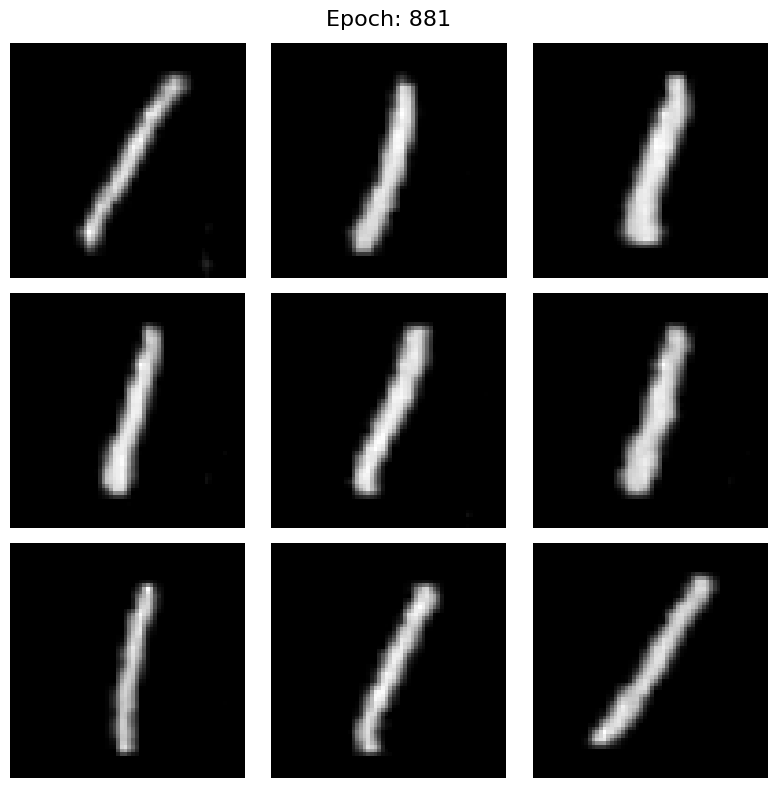

Epoch: 882/1000, d_loss: 0.1947, g_loss: 6.0022, time: 11.2279 sec


Epoch: 883/1000, d_loss: 0.2104, g_loss: 4.5213, time: 11.2859 sec


Epoch: 884/1000, d_loss: 0.1224, g_loss: 4.0734, time: 10.9767 sec


Epoch: 885/1000, d_loss: 0.0935, g_loss: 4.7176, time: 11.0804 sec


Epoch: 886/1000, d_loss: 0.1393, g_loss: 4.8692, time: 11.0508 sec


Epoch: 887/1000, d_loss: 0.0922, g_loss: 4.7482, time: 11.2848 sec


Epoch: 888/1000, d_loss: 0.1755, g_loss: 5.3211, time: 11.0521 sec


Epoch: 889/1000, d_loss: 0.1102, g_loss: 4.6874, time: 11.3705 sec


Epoch: 890/1000, d_loss: 0.1587, g_loss: 5.1559, time: 11.4158 sec


Epoch: 891/1000, d_loss: 0.1018, g_loss: 4.5617, time: 10.9572 sec


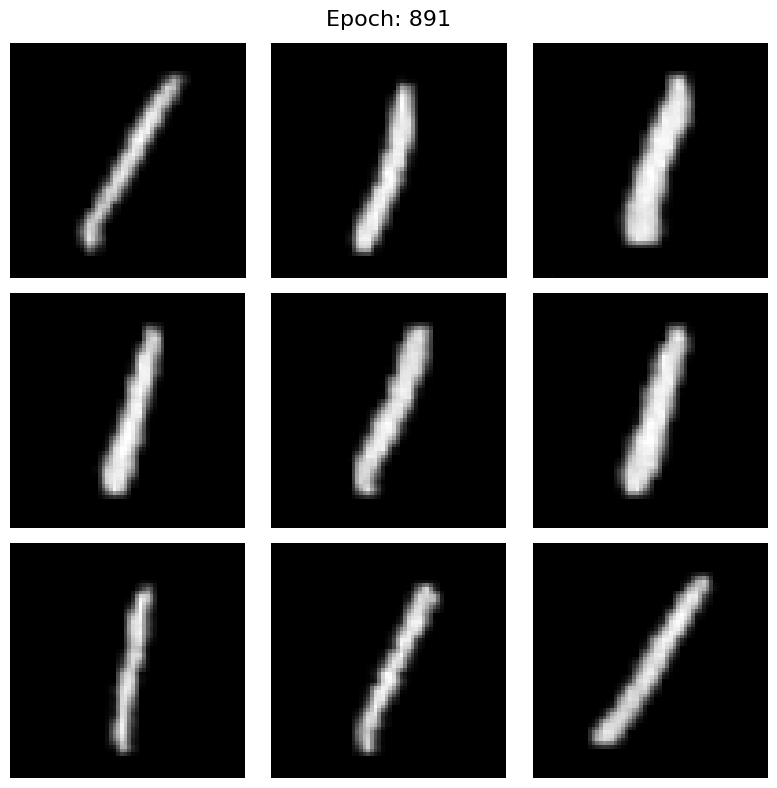

Epoch: 892/1000, d_loss: 0.1115, g_loss: 5.2292, time: 10.9908 sec


Epoch: 893/1000, d_loss: 0.1918, g_loss: 5.3911, time: 11.2252 sec


Epoch: 894/1000, d_loss: 0.1867, g_loss: 4.4986, time: 11.2189 sec


Epoch: 895/1000, d_loss: 0.1061, g_loss: 4.2539, time: 11.0072 sec


Epoch: 896/1000, d_loss: 0.1161, g_loss: 4.4731, time: 11.0201 sec


Epoch: 897/1000, d_loss: 0.0724, g_loss: 4.9736, time: 10.9465 sec


Epoch: 898/1000, d_loss: 0.2669, g_loss: 6.5847, time: 11.0592 sec


Epoch: 899/1000, d_loss: 0.1566, g_loss: 3.9529, time: 10.9493 sec


Epoch: 900/1000, d_loss: 0.0922, g_loss: 4.3519, time: 10.9369 sec


Epoch: 901/1000, d_loss: 0.1079, g_loss: 4.7610, time: 11.1682 sec


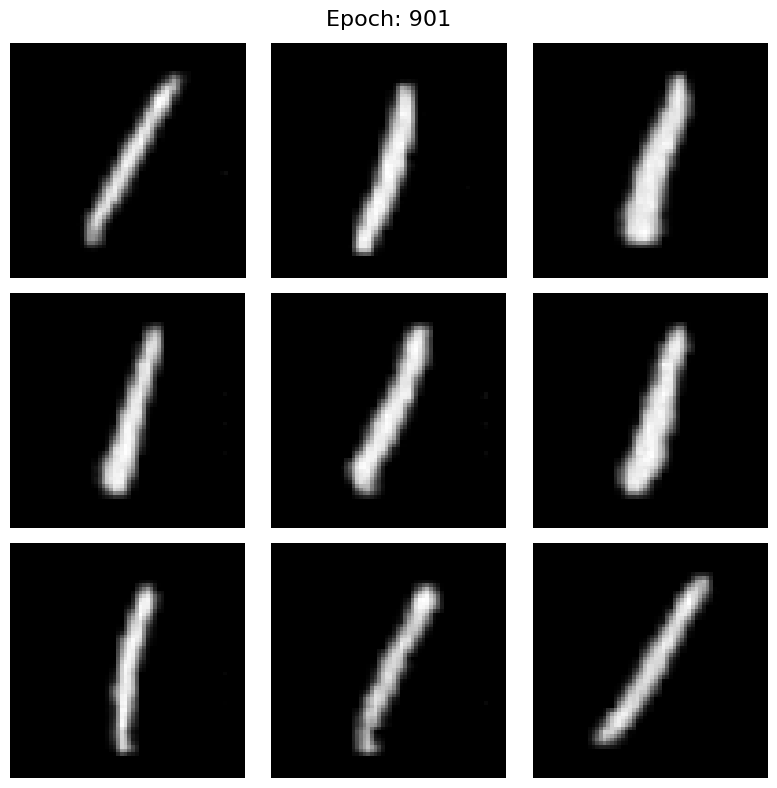

Epoch: 902/1000, d_loss: 0.0860, g_loss: 5.2818, time: 11.2874 sec


Epoch: 903/1000, d_loss: 0.1024, g_loss: 5.0876, time: 11.0150 sec


Epoch: 904/1000, d_loss: 0.2538, g_loss: 5.8725, time: 11.0946 sec


Epoch: 905/1000, d_loss: 0.1151, g_loss: 4.4001, time: 11.0366 sec


Epoch: 906/1000, d_loss: 0.1072, g_loss: 4.8397, time: 10.9595 sec


Epoch: 907/1000, d_loss: 0.1474, g_loss: 4.5989, time: 10.9852 sec


Epoch: 908/1000, d_loss: 0.1041, g_loss: 4.3873, time: 10.9366 sec


Epoch: 909/1000, d_loss: 0.1379, g_loss: 5.4951, time: 11.0673 sec


Epoch: 910/1000, d_loss: 0.1440, g_loss: 4.5030, time: 11.0804 sec


Epoch: 911/1000, d_loss: 0.0984, g_loss: 5.2234, time: 10.9886 sec


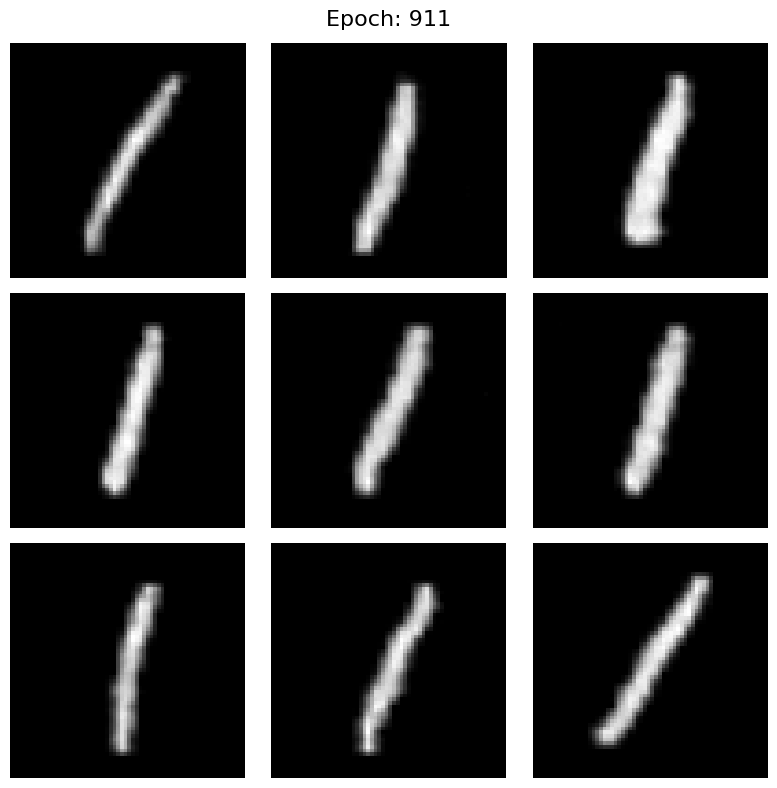

Epoch: 912/1000, d_loss: 0.0740, g_loss: 5.4693, time: 10.9872 sec


Epoch: 913/1000, d_loss: 0.2292, g_loss: 6.1723, time: 11.0047 sec


Epoch: 914/1000, d_loss: 0.1535, g_loss: 4.0993, time: 11.4741 sec


Epoch: 915/1000, d_loss: 0.0773, g_loss: 4.8133, time: 11.0432 sec


Epoch: 916/1000, d_loss: 0.1120, g_loss: 5.2895, time: 11.2043 sec


Epoch: 917/1000, d_loss: 0.1294, g_loss: 5.3781, time: 10.9366 sec


Epoch: 918/1000, d_loss: 0.1189, g_loss: 4.5569, time: 10.9487 sec


Epoch: 919/1000, d_loss: 0.0704, g_loss: 5.1344, time: 10.9688 sec


Epoch: 920/1000, d_loss: 0.1319, g_loss: 5.5477, time: 11.0125 sec


Epoch: 921/1000, d_loss: 0.1423, g_loss: 5.2346, time: 10.9910 sec


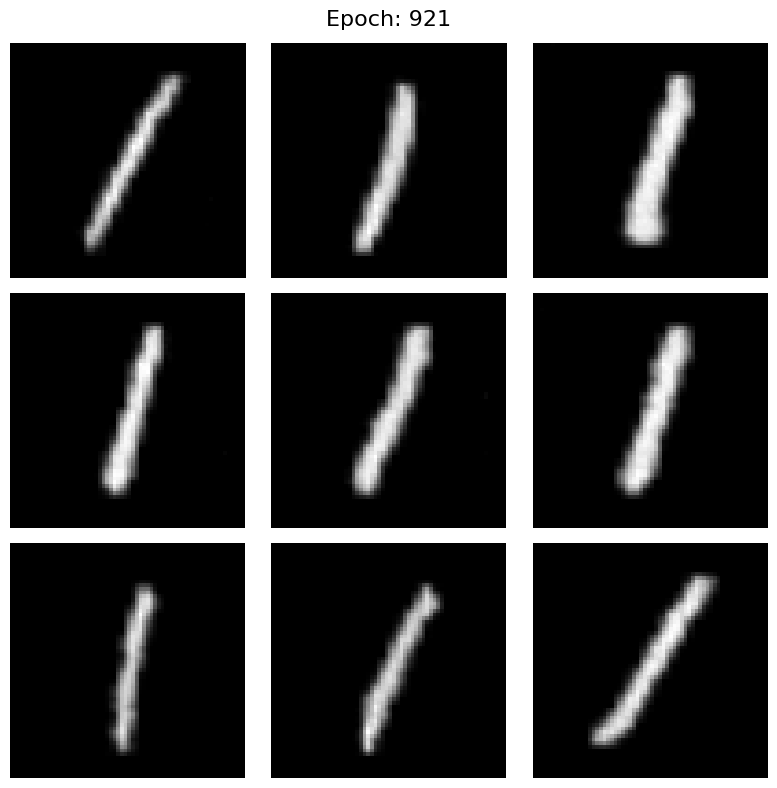

Epoch: 922/1000, d_loss: 0.0887, g_loss: 4.9131, time: 10.9786 sec


Epoch: 923/1000, d_loss: 0.1329, g_loss: 4.8842, time: 10.9767 sec


Epoch: 924/1000, d_loss: 0.0900, g_loss: 4.7467, time: 11.2570 sec


Epoch: 925/1000, d_loss: 0.1112, g_loss: 5.5256, time: 10.9910 sec


Epoch: 926/1000, d_loss: 0.0806, g_loss: 5.0372, time: 11.2229 sec


Epoch: 927/1000, d_loss: 0.1866, g_loss: 5.9048, time: 10.9616 sec


Epoch: 928/1000, d_loss: 0.1017, g_loss: 4.5790, time: 11.4915 sec


Epoch: 929/1000, d_loss: 0.1115, g_loss: 5.6758, time: 10.9393 sec


Epoch: 930/1000, d_loss: 0.0946, g_loss: 5.2497, time: 11.0783 sec


Epoch: 931/1000, d_loss: 0.0852, g_loss: 5.6140, time: 11.0299 sec


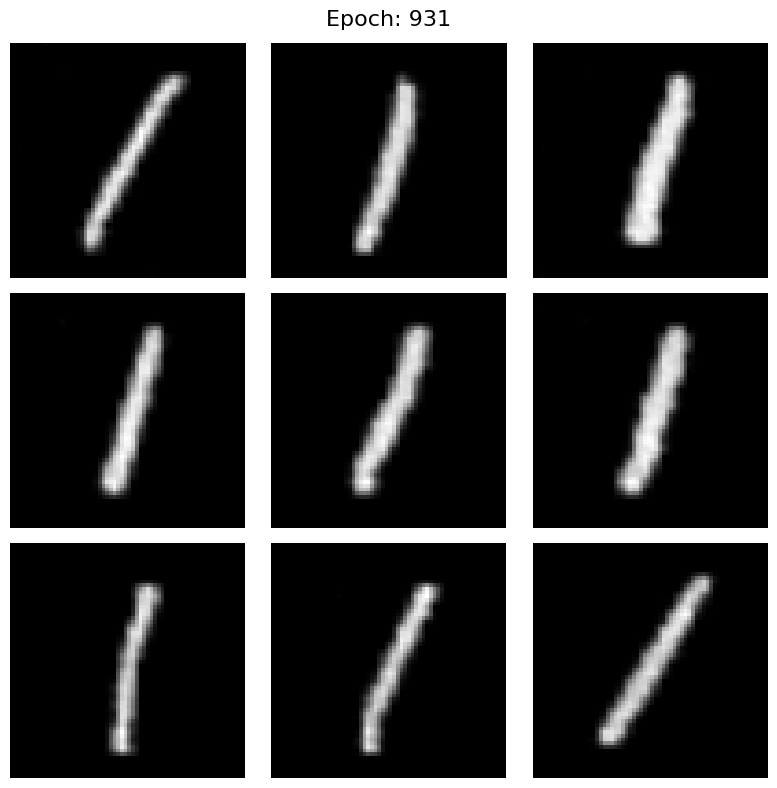

Epoch: 932/1000, d_loss: 0.0790, g_loss: 5.4175, time: 11.0135 sec


Epoch: 933/1000, d_loss: 0.0760, g_loss: 5.3502, time: 11.3230 sec


Epoch: 934/1000, d_loss: 0.1442, g_loss: 5.3328, time: 10.9853 sec


Epoch: 935/1000, d_loss: 0.0875, g_loss: 4.7721, time: 11.0462 sec


Epoch: 936/1000, d_loss: 0.1892, g_loss: 6.7884, time: 11.0039 sec


Epoch: 937/1000, d_loss: 0.1495, g_loss: 4.6677, time: 10.9816 sec


Epoch: 938/1000, d_loss: 0.0848, g_loss: 4.5566, time: 10.9506 sec


Epoch: 939/1000, d_loss: 0.0686, g_loss: 5.1538, time: 10.9580 sec


Epoch: 940/1000, d_loss: 0.0939, g_loss: 6.2389, time: 11.2294 sec


Epoch: 941/1000, d_loss: 0.0889, g_loss: 5.0058, time: 10.9636 sec


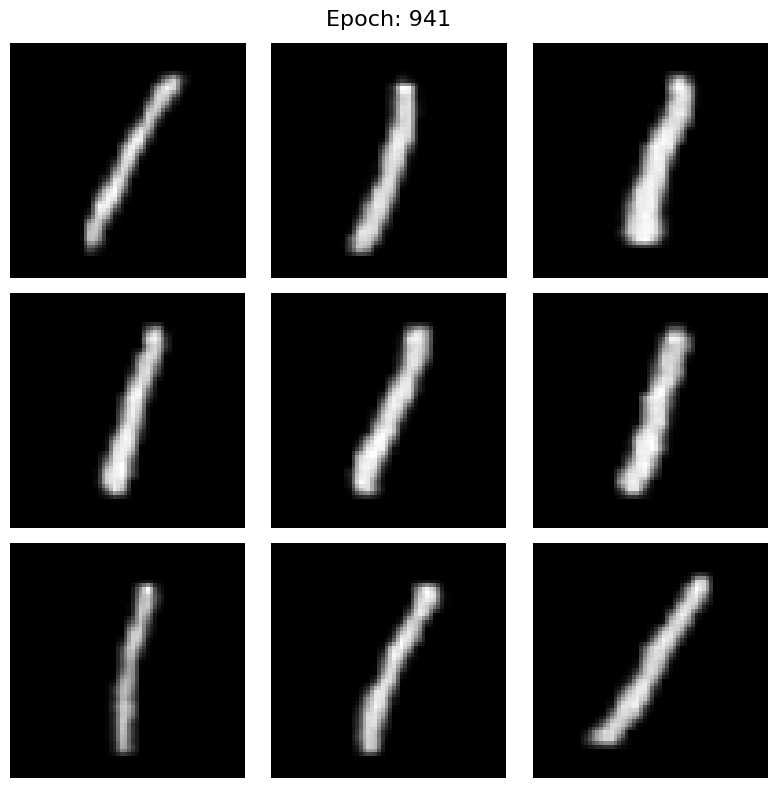

Epoch: 942/1000, d_loss: 0.0618, g_loss: 5.5941, time: 10.9561 sec


Epoch: 943/1000, d_loss: 0.1222, g_loss: 5.4733, time: 10.9900 sec


Epoch: 944/1000, d_loss: 0.0834, g_loss: 5.2696, time: 10.9895 sec


Epoch: 945/1000, d_loss: 0.0901, g_loss: 5.8909, time: 11.0073 sec


Epoch: 946/1000, d_loss: 0.1156, g_loss: 6.2530, time: 10.9582 sec


Epoch: 947/1000, d_loss: 0.0697, g_loss: 5.3592, time: 10.9459 sec


Epoch: 948/1000, d_loss: 0.1124, g_loss: 6.0108, time: 11.3122 sec


Epoch: 949/1000, d_loss: 0.1709, g_loss: 5.3816, time: 10.9789 sec


Epoch: 950/1000, d_loss: 0.0722, g_loss: 5.2352, time: 11.2704 sec


Epoch: 951/1000, d_loss: 0.0585, g_loss: 5.1814, time: 11.5281 sec


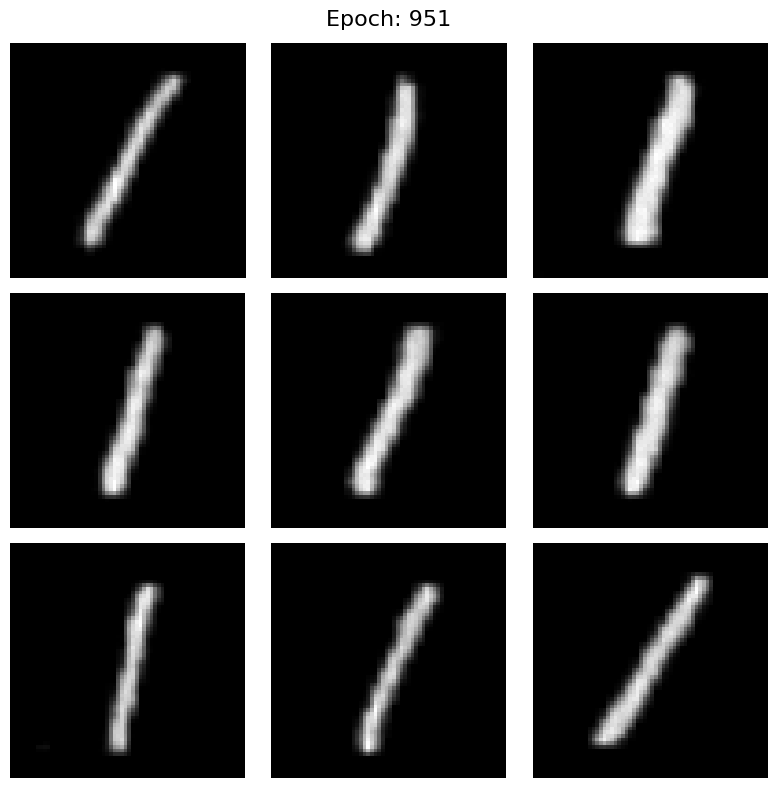

Epoch: 952/1000, d_loss: 0.1827, g_loss: 5.7813, time: 11.0110 sec


Epoch: 953/1000, d_loss: 0.0683, g_loss: 4.9620, time: 10.9544 sec


Epoch: 954/1000, d_loss: 0.0508, g_loss: 5.6999, time: 11.1937 sec


Epoch: 955/1000, d_loss: 0.1351, g_loss: 6.6793, time: 11.5013 sec


Epoch: 956/1000, d_loss: 0.2578, g_loss: 6.2243, time: 11.0022 sec


Epoch: 957/1000, d_loss: 0.0676, g_loss: 5.1056, time: 10.9454 sec


Epoch: 958/1000, d_loss: 0.0966, g_loss: 6.3735, time: 11.0212 sec


Epoch: 959/1000, d_loss: 0.0754, g_loss: 4.9234, time: 11.8310 sec


Epoch: 960/1000, d_loss: 0.0745, g_loss: 5.1840, time: 10.9922 sec


Epoch: 961/1000, d_loss: 0.1181, g_loss: 5.7132, time: 10.9626 sec


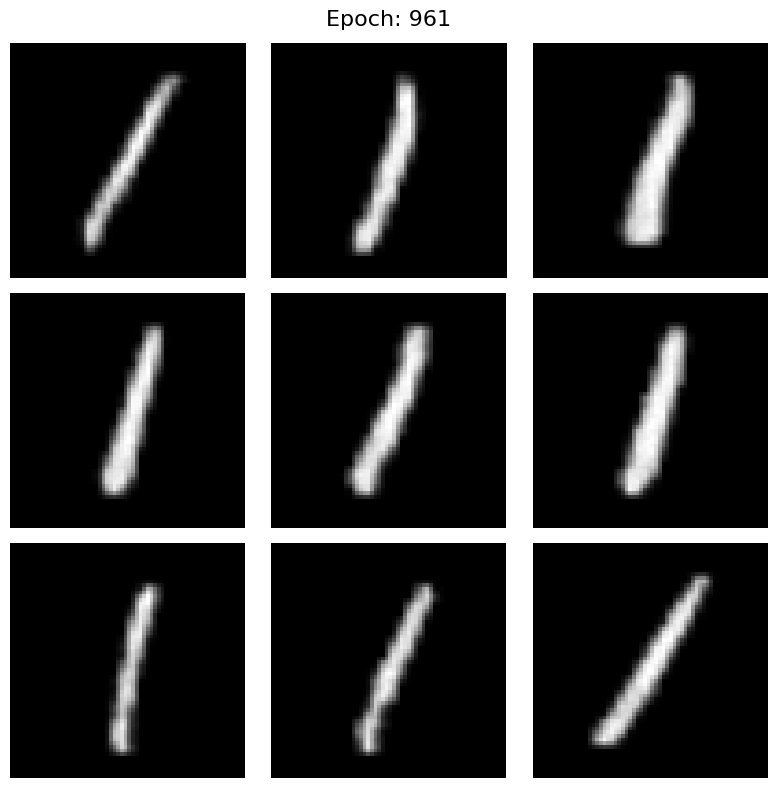

Epoch: 962/1000, d_loss: 0.1133, g_loss: 5.5892, time: 10.9446 sec


Epoch: 963/1000, d_loss: 0.0783, g_loss: 5.4436, time: 11.5671 sec


Epoch: 964/1000, d_loss: 0.0817, g_loss: 5.6766, time: 11.0210 sec


Epoch: 965/1000, d_loss: 0.0800, g_loss: 5.0390, time: 10.9805 sec


Epoch: 966/1000, d_loss: 0.1508, g_loss: 6.2700, time: 11.2213 sec


Epoch: 967/1000, d_loss: 0.1325, g_loss: 4.6678, time: 11.2751 sec


Epoch: 968/1000, d_loss: 0.0632, g_loss: 5.2645, time: 11.2712 sec


Epoch: 969/1000, d_loss: 0.1492, g_loss: 6.1136, time: 11.5084 sec


Epoch: 970/1000, d_loss: 0.1017, g_loss: 5.1264, time: 10.9724 sec


Epoch: 971/1000, d_loss: 0.0854, g_loss: 4.8605, time: 11.0091 sec


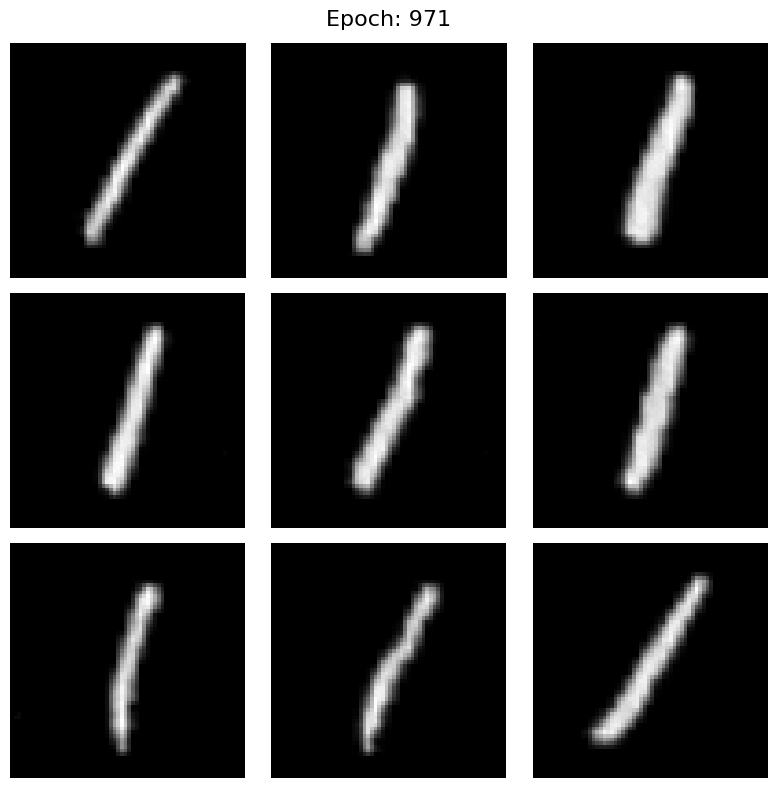

Epoch: 972/1000, d_loss: 0.1105, g_loss: 5.9563, time: 11.2359 sec


Epoch: 973/1000, d_loss: 0.1112, g_loss: 4.8421, time: 10.9768 sec


Epoch: 974/1000, d_loss: 0.0713, g_loss: 5.9346, time: 10.9641 sec


Epoch: 975/1000, d_loss: 0.1705, g_loss: 6.8007, time: 11.2113 sec


Epoch: 976/1000, d_loss: 0.0695, g_loss: 5.0020, time: 11.2484 sec


Epoch: 977/1000, d_loss: 0.0733, g_loss: 5.2354, time: 11.4687 sec


Epoch: 978/1000, d_loss: 0.1179, g_loss: 6.3515, time: 11.0205 sec


Epoch: 979/1000, d_loss: 0.2009, g_loss: 5.5810, time: 10.9946 sec


Epoch: 980/1000, d_loss: 0.0437, g_loss: 5.3817, time: 11.4993 sec


Epoch: 981/1000, d_loss: 0.1354, g_loss: 6.1985, time: 10.9681 sec


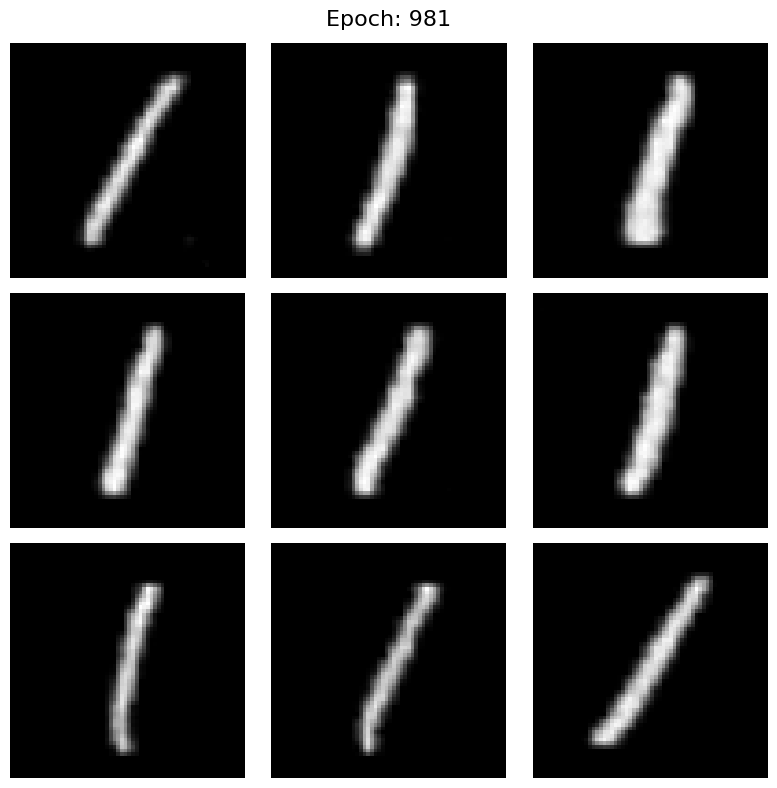

Epoch: 982/1000, d_loss: 0.1000, g_loss: 5.6061, time: 10.9707 sec


Epoch: 983/1000, d_loss: 0.1342, g_loss: 5.5345, time: 10.9609 sec


Epoch: 984/1000, d_loss: 0.0802, g_loss: 4.6835, time: 11.4525 sec


Epoch: 985/1000, d_loss: 0.0695, g_loss: 5.0204, time: 11.0012 sec


Epoch: 986/1000, d_loss: 0.0871, g_loss: 6.1199, time: 10.9524 sec


Epoch: 987/1000, d_loss: 0.1147, g_loss: 5.7844, time: 11.2867 sec


Epoch: 988/1000, d_loss: 0.0734, g_loss: 5.0638, time: 10.9629 sec


Epoch: 989/1000, d_loss: 0.0586, g_loss: 6.0019, time: 11.2900 sec


Epoch: 990/1000, d_loss: 0.1744, g_loss: 6.3356, time: 11.3176 sec


Epoch: 991/1000, d_loss: 0.0888, g_loss: 4.6236, time: 11.3289 sec


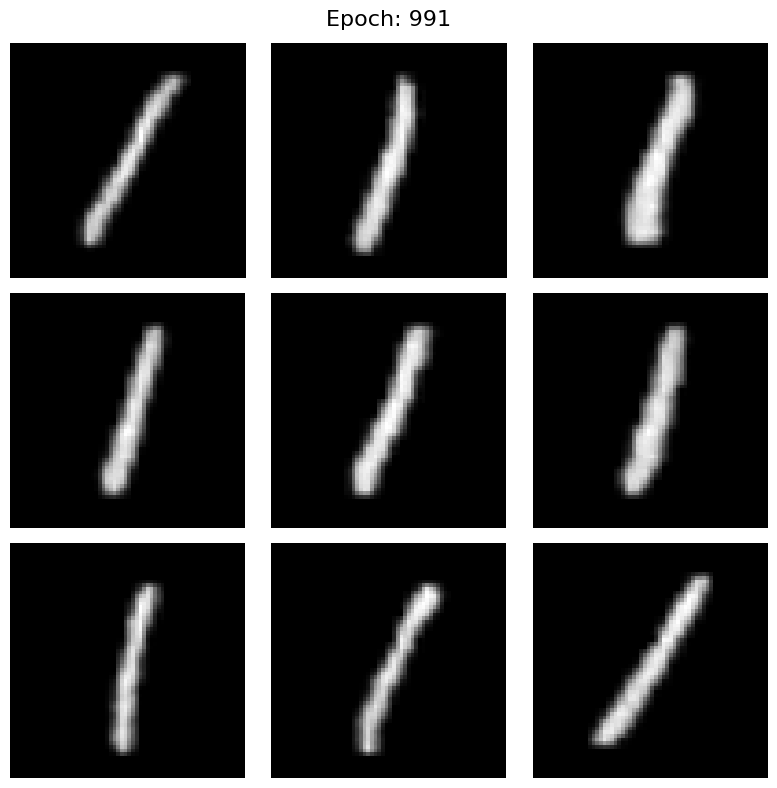

Epoch: 992/1000, d_loss: 0.0666, g_loss: 5.6004, time: 11.3162 sec


Epoch: 993/1000, d_loss: 0.0999, g_loss: 5.4781, time: 11.4805 sec


Epoch: 994/1000, d_loss: 0.1242, g_loss: 6.5879, time: 10.9630 sec


Epoch: 995/1000, d_loss: 0.1164, g_loss: 4.9495, time: 10.9757 sec


Epoch: 996/1000, d_loss: 0.0625, g_loss: 4.9052, time: 10.9576 sec


Epoch: 997/1000, d_loss: 0.0920, g_loss: 6.2064, time: 11.0055 sec


Epoch: 998/1000, d_loss: 0.1328, g_loss: 5.6894, time: 11.3902 sec


Epoch: 999/1000, d_loss: 0.0468, g_loss: 6.1277, time: 11.0148 sec


Epoch: 1000/1000, d_loss: 0.1981, g_loss: 6.9109, time: 11.3176 sec


In [21]:
g_losses = []
d_losses = []
generator = generator.to(device)
discriminator = discriminator.to(device)

print("Start training")
for epoch in range(num_epochs):
    start.record()
    minibatch_d_losses = []
    minibatch_g_losses = []

    generator.train()
    discriminator.train()

    for i, (images, _) in enumerate(train_data_loader):
        mini_batch = images.size()[0]
        if mini_batch == 1:
            continue

        images = images.to(device)
        real_labels = torch.full(
            (mini_batch,), real_label, dtype=torch.float, device=device
        )
        fake_labels = torch.full(
            (mini_batch,), fake_label, dtype=torch.float, device=device
        )

        # train discriminator
        discriminator.zero_grad()
        real_outputs = discriminator(images)
        real_loss = criterion(real_outputs, real_labels)
        real_loss.backward()

        z = torch.randn(mini_batch, z_dim, 1, 1, device=device)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs, fake_labels)
        fake_loss.backward()

        optimizer_d.step()
        minibatch_d_losses.append(real_loss.item() + fake_loss.item())

        # train generator
        generator.zero_grad()
        fake_outputs = discriminator(fake_images)
        real_labels = torch.full(
            (mini_batch,), real_label, dtype=torch.float, device=device
        )
        loss = criterion(fake_outputs, real_labels)
        loss.backward()
        optimizer_g.step()
        minibatch_g_losses.append(loss.item())

    end.record()
    torch.cuda.synchronize()
    print(
        f"Epoch: {epoch+1}/{num_epochs}, d_loss: {np.mean(minibatch_d_losses):.4f}, g_loss: {np.mean(minibatch_g_losses):.4f}, time: {start.elapsed_time(end)/1000:.4f} sec"
    )
    g_losses.append(np.mean(minibatch_g_losses))
    d_losses.append(np.mean(minibatch_d_losses))

    if epoch % 10 == 0:
        show_generated(
            generator,
            z_dim,
            device,
            title=f"Epoch: {epoch+1}",
            save_path=os.path.join(save_dir, f"dcgan-epoch-{epoch+1}.png"),
        )

In [22]:
# save model
torch.save(generator.state_dict(), os.path.join(save_dir, "dcgan-generator.pth"))
torch.save(
    discriminator.state_dict(), os.path.join(save_dir, "dcgan-discriminator.pth")
)
# save losses
losses = pd.DataFrame({"g_losses": g_losses, "d_losses": d_losses})
losses.to_csv(os.path.join(save_dir, "dcgan-losses.csv"), index=False)

## 学習結果の確認

まず、下の損失のグラフを確認すると、Discriminatorは単調減少、Generatorは単調増加する傾向にあることが概ね確認できる。Discriminatorは過学習してしまっており、そのため、Generatorはどんなに頑張ってもDiscriminatorを騙すことができなかったのだと推察される。

また、生成された画像を確認すると、同じような数字ばかりが生成されてしまっていることが分かる。Generatorの立場からすると、0~9の数字をそれぞれ作成するのと0のみを生成するので、損失関数の結果に変わりはないので、初期パラメータの具合によっては同じ数字ばかり生成するように収束してしまうことになる。これはモード崩壊と呼ばれる。

これらに対する対処方法を`5-dcgan-improved.ipynb`に作成することにする。

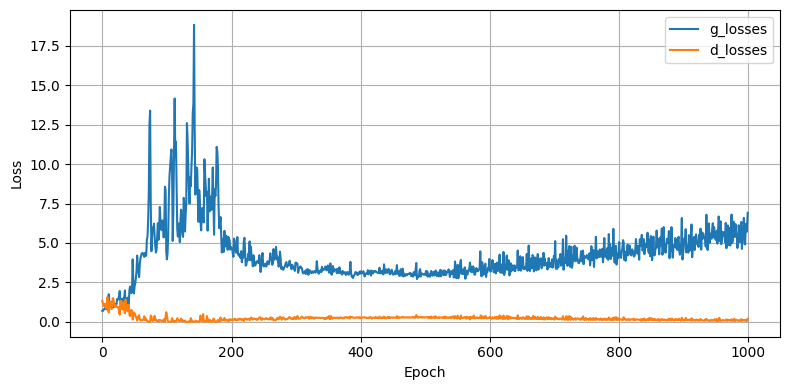

In [23]:
# display losses
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(g_losses, label="g_losses")
ax.plot(d_losses, label="d_losses")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

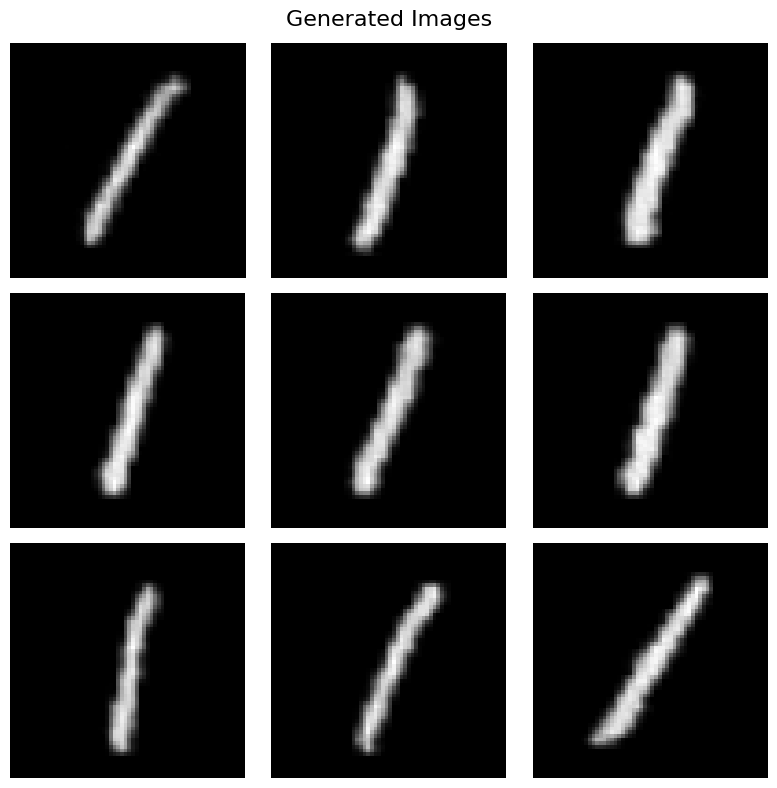

In [24]:
show_generated(generator, z_dim, device)

## 参考文献

- [つくりながら学ぶ！PyTorchによる発展ディープラーニング | 小川 雄太郎 | 工学 | Kindleストア | Amazon](https://www.amazon.co.jp/%E3%81%A4%E3%81%8F%E3%82%8A%E3%81%AA%E3%81%8C%E3%82%89%E5%AD%A6%E3%81%B6%EF%BC%81PyTorch%E3%81%AB%E3%82%88%E3%82%8B%E7%99%BA%E5%B1%95%E3%83%87%E3%82%A3%E3%83%BC%E3%83%97%E3%83%A9%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0-%E5%B0%8F%E5%B7%9D-%E9%9B%84%E5%A4%AA%E9%83%8E-ebook/dp/B07VPDVNKW/ref=sr_1_1?__mk_ja_JP=%E3%82%AB%E3%82%BF%E3%82%AB%E3%83%8A&crid=39VBRPTDUUH0F&keywords=%E4%BD%9C%E3%82%8A%E3%81%AA%E3%81%8C%E3%82%89%E5%AD%A6%E3%81%B6+pytorch&qid=1701503265&sprefix=%E4%BD%9C%E3%82%8A%E3%81%AA%E3%81%8C%E3%82%89%E5%AD%A6%E3%81%B6+pytorch%2Caps%2C221&sr=8-1)
- [DCGAN Tutorial — PyTorch Tutorials 2.2.0+cu121 documentation](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)